In [2]:
import torch

In [3]:
print("dupa")

dupa


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [183]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

val_loader = DataLoader(val_subset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2, persistent_workers=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [157]:
print('Train set size:', len(train_subset))
print('Validation set size:', len(val_subset))
print('Test set size:', len(test_set))

Train set size: 45000
Validation set size: 5000
Test set size: 10000


In [9]:
def get_class_counts(dataset, classes):
    counts = [0] * len(classes)
    for data, label in dataset:
        counts[label] += 1
    return counts

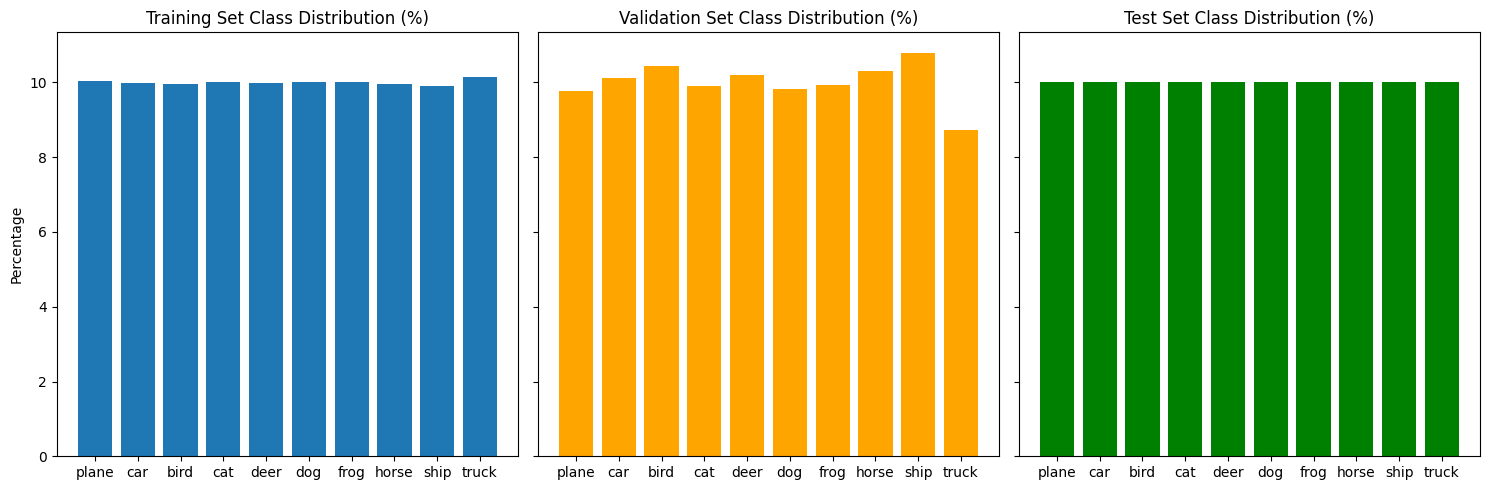

In [10]:
import matplotlib.pyplot as plt

train_counts = get_class_counts(train_subset, classes)
val_counts = get_class_counts(val_subset, classes)
test_counts = get_class_counts(test_set, classes)

train_percentages = [count / sum(train_counts) * 100 for count in train_counts]
val_percentages = [count / sum(val_counts) * 100 for count in val_counts]
test_percentages = [count / sum(test_counts) * 100 for count in test_counts]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].bar(classes, train_percentages)
ax[0].set_title("Training Set Class Distribution (%)")
ax[0].set_ylabel("Percentage")

ax[1].bar(classes, val_percentages, color='orange')
ax[1].set_title("Validation Set Class Distribution (%)")

ax[2].bar(classes, test_percentages, color='green')
ax[2].set_title("Test Set Class Distribution (%)")

plt.tight_layout()
plt.show()

In [11]:
import numpy as np

dataiter = iter(train_loader)

Batch of images has shape: torch.Size([4, 3, 32, 32])


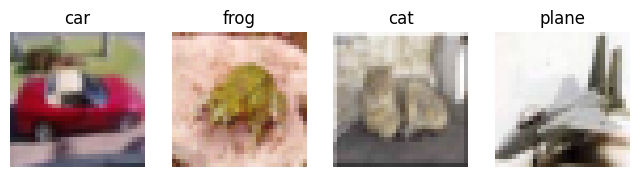

In [15]:
images, labels = next(dataiter)

print('Batch of images has shape:', images.shape)

def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(1, len(labels), figsize=(8, 2))
    for i in range(len(labels)):
        ax[i].imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')
    plt.show()

imshow(images, labels)

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 inputy, 6 outputow, 5x5 kernel
        self.pool = nn.AvgPool2d(2, 2)  # 2x2 pooling, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [50]:
net = Net().to(device)

In [51]:
from torchviz import make_dot
from IPython.display import Image, display

def computational_graph(model):
    inputs = torch.randn(1, 3, 32, 32).to(device)
    outputs = model(inputs)
    target = torch.tensor([1], dtype=torch.long).to(device)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, target)
    loss.backward()
    dot = make_dot(outputs, params=dict(net.named_parameters()))
    dot.render("computation_graph", format="png")
    display(Image(filename="computation_graph.png"))

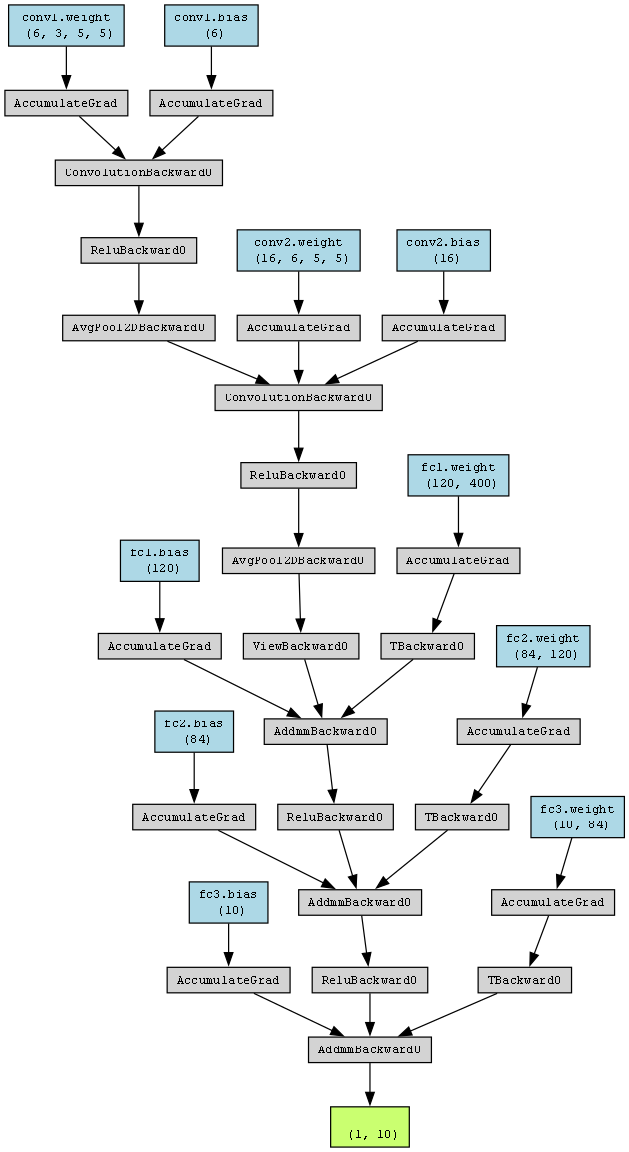

In [52]:
computational_graph(net)

In [53]:
sum(p.numel() for p in net.parameters())

62006

Pytorch używa Kaiming Uniform zwanym też He initialization zarówna dla nn.Conv2d jak i nn.Linear

In [54]:
# for name, param in net.named_parameters():
#     print(f'Layer: {name} | Initial Weights: \n{param.data}\n')

# 6

In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [72]:
import matplotlib.pyplot as plt

def calculate_loss(net, data_loader, criterion, device):
    net.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    net.train()
    return total_loss / len(data_loader)

def plot_losses(train_losses, val_losses, train_losses_batch, val_losses_batch):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot train_losses and val_losses on the first subplot
    axs[0].plot(train_losses, label='Training Loss (Epoch)')
    axs[0].plot(val_losses, label='Validation Loss (Epoch)')
    axs[0].set_title('Training and Validation Loss (Epoch)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot train_losses_batch and val_losses_batch on the second subplot
    axs[1].plot(train_losses_batch, label='Training Loss (Batch)')
    axs[1].plot(val_losses_batch, label='Validation Loss (Batch)')
    axs[1].set_title('Training and Validation Loss (Batch)')
    axs[1].set_xlabel('Iterations (in thousands)')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
    
def test_accuracy(net, image_loader, device, df_type = "test"):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in image_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    net.train()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {df_type} images: {accuracy:.2f}%')
    return accuracy

In [57]:
train_losses = []
train_losses_batch = []
val_losses = []
val_losses_batch = []

In [58]:
import copy
best_net = copy.deepcopy(net)
best_val_loss = float('inf')

In [ ]:
early_stop_counter = 0
early_stop_range = 3
for epoch in range(50):
    running_loss = 0.0
    print(f"Starting epoch {epoch + 1}")
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            avg_running_loss = running_loss / 2000
            train_losses_batch.append(avg_running_loss)
            print(f'Epoch {epoch + 1}, images {i + 1}, Train Loss: {avg_running_loss:.4f}')
            running_loss = 0.0

            val_loss = calculate_loss(net, val_loader, criterion, device)
            val_losses_batch.append(val_loss)
            print(f'Epoch {epoch + 1}, images {i + 1}, Validation Loss: {val_loss:.4f}')
         
            
    print(f"Finished epoch {epoch + 1}")
    train_loss = calculate_loss(net, train_loader, criterion, device)
    print(f"Train loss: {train_loss}")
    train_losses.append(train_loss)
    
    val_loss = calculate_loss(net, val_loader, criterion, device)
    print(f"Validation loss: {val_loss}")
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_net = copy.deepcopy(net)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_range:
            print(f'Early stopping at epoch {epoch + 1}')
            break
            
print('Finished Training')

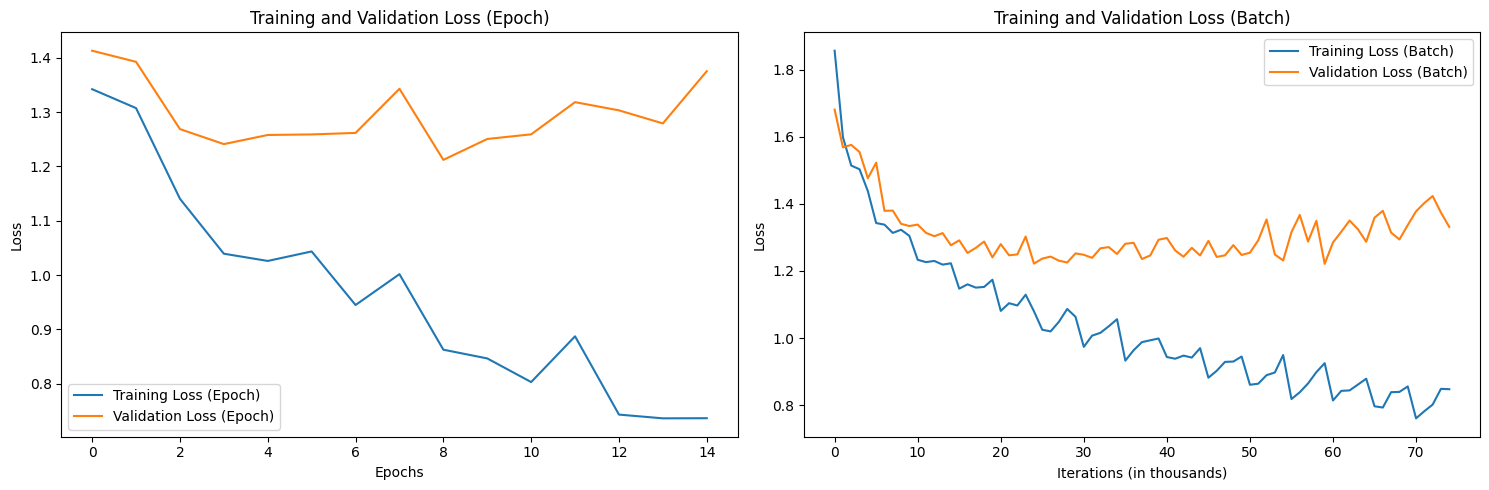

In [68]:
plot_losses(train_losses, val_losses, train_losses_batch, val_losses_batch)

In [65]:
test_accuracy(best_net, train_loader, device, "train")
test_accuracy(best_net, val_loader, device, "validation")
test_accuracy(best_net, test_loader, device, "test")

Accuracy of the network on the train images: 69.32%
Accuracy of the network on the validation images: 59.08%
Accuracy of the network on the test images: 60.26%


60.26

In [69]:
testdataiter = iter(test_loader)

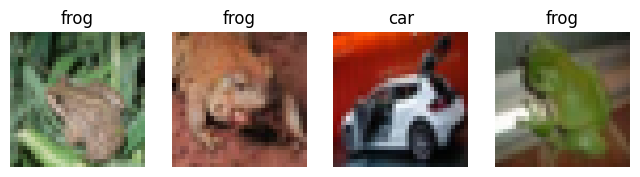

GroundTruth: frog frog car frog
Predicted: deer frog car frog


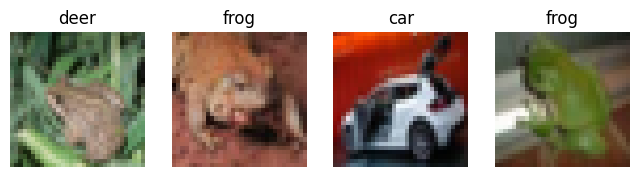

In [71]:
images, labels = next(testdataiter)

imshow(images, labels)
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

images, labels = images.to(device), labels.to(device)

outputs = best_net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

imshow(images.cpu(), predicted)

In [105]:
class DynamicNet(nn.Module):
    def __init__(self, hidden_layers, dropout_rate):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 inputy, 6 outputow, 5x5 kernel
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.after_conv_size = 16 * 5 * 5
        self.output_size = 10
        self.hidden_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        self.hidden_layers.append(nn.Linear(16 * 5 * 5, hidden_layers[0]))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_layers[i]))
        self.hidden_layers.append(nn.Linear(hidden_layers[-1], self.output_size))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        for layer in self.hidden_layers[:-1]:
            if isinstance(layer, nn.Linear):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        x = self.hidden_layers[-1](x) 
        return x

In [128]:
def train_model(lr, hidden_layers, dropout_rate, weight_decay):
    net = DynamicNet(hidden_layers, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_net = copy.deepcopy(net)
    best_val_loss = float('inf')
    
    early_stop_counter = 0
    early_stop_range = 3
    
    for epoch in range(50):
        running_loss = 0.0
        print(f"Starting epoch {epoch + 1}")
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                avg_running_loss = running_loss / 2000
                print(f'Epoch {epoch + 1}, images {i + 1}, Train Loss: {avg_running_loss:.4f}')
                running_loss = 0.0


        print(f"Finished epoch {epoch + 1}")
        train_loss = calculate_loss(net, train_loader, criterion, device)
        print(f"Train loss: {train_loss}")

        val_loss = calculate_loss(net, val_loader, criterion, device)
        print(f"Validation loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_net = copy.deepcopy(net)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_range:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    print('Finished Training')
    return test_accuracy(best_net, test_loader, device, "test")

In [129]:
import optuna

def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    hidden_layers = [trial.suggest_int(f'layer_{i}', 10, 100) for i in range(trial.suggest_int('layers', 1, 5))]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    print(f'lr: {lr}, hidden_layers: {hidden_layers}, dropout_rate: {dropout_rate}, weight_decay: {weight_decay}')
    return train_model(lr, hidden_layers, dropout_rate, weight_decay)

In [ ]:
if False:
    # study = optuna.create_study(direction='maximize')

In [ ]:
study.optimize(objective, n_trials=10)

print(study.best_params)
print(study.best_value)

In [ ]:
if False:
    # study_with_bn = optuna.create_study(direction='maximize')

In [ ]:
study_with_bn.optimize(objective, n_trials=50)

In [ ]:
study_with_bn.optimize(objective, n_trials=100)

In [123]:
print(study_with_bn.best_params)
print(study_with_bn.best_value)

{'lr': 0.0030034862760356007, 'layers': 1, 'layer_0': 83, 'dropout_rate': 0.31925104873368815, 'weight_decay': 2.4079540794135313e-06}
66.5


In [193]:
class MyNet(nn.Module):
    def __init__(self, dropout_rate, pool_function):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, padding=3, padding_mode="reflect")  # 3 inputy, 16 outputow, 7x7 kernel
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2, padding_mode="reflect")
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, padding_mode="reflect")
        self.pool = pool_function(2, 2)  # 2x2 pooling, stride 2
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [196]:
def my_train_model(lr, dropout_rate, pool_function, weight_decay):
    net = MyNet(dropout_rate, pool_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_net = copy.deepcopy(net)
    best_val_loss = float('inf')
    
    early_stop_counter = 0
    early_stop_range = 5
    
    for epoch in range(50):
        print(f"Starting epoch {epoch + 1}")
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        print(f"Finished epoch {epoch + 1}")
        train_loss = calculate_loss(net, train_loader, criterion, device)
        print(f"Train loss: {train_loss}")

        val_loss = calculate_loss(net, val_loader, criterion, device)
        print(f"Validation loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_net = copy.deepcopy(net)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_range:
                print(f'Early stopping at epoch {epoch + 1}')
                break

    print('Finished Training')
    return test_accuracy(best_net, test_loader, device, "test")

In [181]:
def my_objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    pool_func = trial.suggest_categorical('pool_function', ["MaxPool2d", "AvgPool2d"])
    if pool_func == "MaxPool2d":
        pool_function = nn.MaxPool2d
    else:
        pool_function = nn.AvgPool2d
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    print(f"lr: {lr}, dropout_rate: {dropout_rate}, pool_function: {pool_func}, weight_decay: {weight_decay}")
    return my_train_model(lr, dropout_rate, pool_function, weight_decay)

In [189]:
if False:
    # my_study = optuna.create_study(direction='maximize')

[I 2024-10-30 00:45:35,619] A new study created in memory with name: no-name-30bba14b-2c77-4fb3-8f60-746c38734405


In [198]:
my_study.optimize(my_objective, n_trials=100)

lr: 0.00010124403194340665, dropout_rate: 0.47989409216813567, pool_function: MaxPool2d, weight_decay: 2.3428334184305144e-05
Starting epoch 1
Finished epoch 1
Train loss: 1.3968989837228956
Validation loss: 1.4100395456241195
Starting epoch 2
Finished epoch 2
Train loss: 1.2131999396820312
Validation loss: 1.2447252235594828
Starting epoch 3
Finished epoch 3
Train loss: 1.0899915957416977
Validation loss: 1.1209812050412415
Starting epoch 4
Finished epoch 4
Train loss: 1.0203434773684394
Validation loss: 1.0621680287039204
Starting epoch 5
Finished epoch 5
Train loss: 0.9431652093958838
Validation loss: 1.0070863016851388
Starting epoch 6
Finished epoch 6
Train loss: 0.9269865612527879
Validation loss: 0.994931740935441
Starting epoch 7
Finished epoch 7
Train loss: 0.8452415701211049
Validation loss: 0.9268407016802745
Starting epoch 8
Finished epoch 8
Train loss: 0.8195112879045822
Validation loss: 0.9268302554917184
Starting epoch 9
Finished epoch 9
Train loss: 0.7661296592677156
Va

[I 2024-10-30 01:25:21,036] Trial 12 finished with value: 72.1 and parameters: {'lr': 0.00010124403194340665, 'dropout_rate': 0.47989409216813567, 'pool_function': 'MaxPool2d', 'weight_decay': 2.3428334184305144e-05}. Best is trial 5 with value: 74.73.


Accuracy of the network on the test images: 72.10%
lr: 0.00045941754772714586, dropout_rate: 0.5397995582206765, pool_function: MaxPool2d, weight_decay: 7.89372782249814e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.3057036963691928
Validation loss: 1.3222397432965078
Starting epoch 2
Finished epoch 2
Train loss: 1.1141362204649978
Validation loss: 1.1405513992734775
Starting epoch 3
Finished epoch 3
Train loss: 1.0065359303776729
Validation loss: 1.0602213022815195
Starting epoch 4
Finished epoch 4
Train loss: 0.9444412889426367
Validation loss: 1.0020352484314305
Starting epoch 5
Finished epoch 5
Train loss: 0.9660896081914271
Validation loss: 1.0391134524800976
Starting epoch 6
Finished epoch 6
Train loss: 0.8430723290157047
Validation loss: 0.9412397222154459
Starting epoch 7
Finished epoch 7
Train loss: 0.7557414982152816
Validation loss: 0.8573264280322251
Starting epoch 8
Finished epoch 8
Train loss: 0.7372847075740242
Validation loss: 0.8419366057511348
Starting epoch 9
F

[I 2024-10-30 01:30:15,307] Trial 13 finished with value: 74.47 and parameters: {'lr': 0.00045941754772714586, 'dropout_rate': 0.5397995582206765, 'pool_function': 'MaxPool2d', 'weight_decay': 7.89372782249814e-06}. Best is trial 5 with value: 74.73.


Accuracy of the network on the test images: 74.47%
lr: 0.00032928340423518643, dropout_rate: 0.21464715796176184, pool_function: MaxPool2d, weight_decay: 2.9692250361625842e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.135279255381017
Validation loss: 1.1649280809293128
Starting epoch 2
Finished epoch 2
Train loss: 0.9539143269419585
Validation loss: 1.0337274636432623
Starting epoch 3
Finished epoch 3
Train loss: 0.8371686182000067
Validation loss: 0.9233839086666229
Starting epoch 4
Finished epoch 4
Train loss: 0.7715194580312646
Validation loss: 0.8876639967131766
Starting epoch 5
Finished epoch 5
Train loss: 0.6859495002238905
Validation loss: 0.824329211643547
Starting epoch 6
Finished epoch 6
Train loss: 0.6103164452818496
Validation loss: 0.7709570916215326
Starting epoch 7
Finished epoch 7
Train loss: 0.5737927647541835
Validation loss: 0.763642310716544
Starting epoch 8
Finished epoch 8
Train loss: 0.5615130740654071
Validation loss: 0.7955446057258897
Starting epoch 9
F

[I 2024-10-30 01:35:23,273] Trial 14 finished with value: 76.12 and parameters: {'lr': 0.00032928340423518643, 'dropout_rate': 0.21464715796176184, 'pool_function': 'MaxPool2d', 'weight_decay': 2.9692250361625842e-06}. Best is trial 14 with value: 76.12.


Accuracy of the network on the test images: 76.12%
lr: 0.0001342308607169639, dropout_rate: 0.21956245447391748, pool_function: MaxPool2d, weight_decay: 1.2075660495595246e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.2590765110041626
Validation loss: 1.2758539394967874
Starting epoch 2
Finished epoch 2
Train loss: 1.0245565545838524
Validation loss: 1.0822366369757683
Starting epoch 3
Finished epoch 3
Train loss: 0.9459983250013716
Validation loss: 1.0247788174896484
Starting epoch 4
Finished epoch 4
Train loss: 0.8232702508452265
Validation loss: 0.9209560108412603
Starting epoch 5
Finished epoch 5
Train loss: 0.7815191988709469
Validation loss: 0.900452931595456
Starting epoch 6
Finished epoch 6
Train loss: 0.7711364699748703
Validation loss: 0.9043036906202887
Starting epoch 7
Finished epoch 7
Train loss: 0.7009548910687643
Validation loss: 0.853679792136903
Starting epoch 8
Finished epoch 8
Train loss: 0.647494442120205
Validation loss: 0.8165285439248298
Starting epoch 9
Fi

[I 2024-10-30 01:41:02,721] Trial 15 finished with value: 74.21 and parameters: {'lr': 0.0001342308607169639, 'dropout_rate': 0.21956245447391748, 'pool_function': 'MaxPool2d', 'weight_decay': 1.2075660495595246e-06}. Best is trial 14 with value: 76.12.


Accuracy of the network on the test images: 74.21%
lr: 0.003340986683175964, dropout_rate: 0.20775399528693145, pool_function: MaxPool2d, weight_decay: 0.00010350977139964863
Starting epoch 1
Finished epoch 1
Train loss: 1.372810448791935
Validation loss: 1.387139081954956
Starting epoch 2
Finished epoch 2
Train loss: 1.0785851678106069
Validation loss: 1.133023614716378
Starting epoch 3
Finished epoch 3
Train loss: 1.0964358332060546
Validation loss: 1.1820774814885133
Starting epoch 4
Finished epoch 4
Train loss: 0.9279322752989855
Validation loss: 1.0572929716413948
Starting epoch 5
Finished epoch 5
Train loss: 0.8028972727361094
Validation loss: 0.9375830167418073
Starting epoch 6
Finished epoch 6
Train loss: 0.7869692150167141
Validation loss: 0.9362337004606891
Starting epoch 7
Finished epoch 7
Train loss: 0.76265495860924
Validation loss: 0.9571805144571195
Starting epoch 8
Finished epoch 8
Train loss: 0.7093185875207376
Validation loss: 0.9128813629697083
Starting epoch 9
Finis

[I 2024-10-30 01:46:31,665] Trial 16 finished with value: 72.17 and parameters: {'lr': 0.003340986683175964, 'dropout_rate': 0.20775399528693145, 'pool_function': 'MaxPool2d', 'weight_decay': 0.00010350977139964863}. Best is trial 14 with value: 76.12.


Accuracy of the network on the test images: 72.17%
lr: 0.0044294396531127985, dropout_rate: 0.4353587446581796, pool_function: MaxPool2d, weight_decay: 4.9434768185246e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.4956691200714545
Validation loss: 1.5126065775087685
Starting epoch 2
Finished epoch 2
Train loss: 1.2895638107321494
Validation loss: 1.3170802680550107
Starting epoch 3
Finished epoch 3
Train loss: 1.1378870029862924
Validation loss: 1.1855102583860895
Starting epoch 4
Finished epoch 4
Train loss: 1.1168525223199917
Validation loss: 1.1730422506666487
Starting epoch 5
Finished epoch 5
Train loss: 1.0234583372669857
Validation loss: 1.1009384845472445
Starting epoch 6
Finished epoch 6
Train loss: 0.9321597886153291
Validation loss: 1.023012879927447
Starting epoch 7
Finished epoch 7
Train loss: 0.9026209675384568
Validation loss: 1.021743079659286
Starting epoch 8
Finished epoch 8
Train loss: 0.8348662391908641
Validation loss: 0.9645343111578826
Starting epoch 9
Finis

[I 2024-10-30 01:54:40,943] Trial 17 finished with value: 72.04 and parameters: {'lr': 0.0044294396531127985, 'dropout_rate': 0.4353587446581796, 'pool_function': 'MaxPool2d', 'weight_decay': 4.9434768185246e-06}. Best is trial 14 with value: 76.12.


Accuracy of the network on the test images: 72.04%
lr: 0.0002874069237937963, dropout_rate: 0.4989018973366501, pool_function: MaxPool2d, weight_decay: 0.002107061104728937
Starting epoch 1
Finished epoch 1
Train loss: 1.3506575907132434
Validation loss: 1.3747359647113047
Starting epoch 2
Finished epoch 2
Train loss: 1.0998439427038924
Validation loss: 1.1298186915695287
Starting epoch 3
Finished epoch 3
Train loss: 0.9467498023796352
Validation loss: 1.0036995805752504
Starting epoch 4
Finished epoch 4
Train loss: 0.9310418331377373
Validation loss: 0.9783248863402446
Starting epoch 5
Finished epoch 5
Train loss: 0.8872258404551793
Validation loss: 0.9557263080481511
Starting epoch 6
Finished epoch 6
Train loss: 0.7629514597965287
Validation loss: 0.8478057008640022
Starting epoch 7
Finished epoch 7
Train loss: 0.7763868156018288
Validation loss: 0.8585974287455249
Starting epoch 8
Finished epoch 8
Train loss: 0.7252013953488688
Validation loss: 0.8523337091230283
Starting epoch 9
Fi

[I 2024-10-30 02:01:41,160] Trial 18 finished with value: 77.01 and parameters: {'lr': 0.0002874069237937963, 'dropout_rate': 0.4989018973366501, 'pool_function': 'MaxPool2d', 'weight_decay': 0.002107061104728937}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 77.01%
lr: 0.0002635336218656907, dropout_rate: 0.41243531288655244, pool_function: MaxPool2d, weight_decay: 0.002481568544207094
Starting epoch 1
Finished epoch 1
Train loss: 1.2655134930115857
Validation loss: 1.289011310619913
Starting epoch 2
Finished epoch 2
Train loss: 1.0347242487095396
Validation loss: 1.0816963539002047
Starting epoch 3
Finished epoch 3
Train loss: 0.9996381840260213
Validation loss: 1.0553700715113596
Starting epoch 4
Finished epoch 4
Train loss: 0.9203842190367666
Validation loss: 0.9773796493080771
Starting epoch 5
Finished epoch 5
Train loss: 0.9451462150933307
Validation loss: 1.0358577101093949
Starting epoch 6
Finished epoch 6
Train loss: 0.7831012128131476
Validation loss: 0.8845096887296932
Starting epoch 7
Finished epoch 7
Train loss: 0.8199615480633772
Validation loss: 0.9485753121649384
Starting epoch 8
Finished epoch 8
Train loss: 0.6776754800402364
Validation loss: 0.816220970100658
Starting epoch 9
Fin

[I 2024-10-30 02:06:37,497] Trial 19 finished with value: 74.58 and parameters: {'lr': 0.0002635336218656907, 'dropout_rate': 0.41243531288655244, 'pool_function': 'MaxPool2d', 'weight_decay': 0.002481568544207094}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 74.58%
lr: 0.000249050418070082, dropout_rate: 0.5763418191947682, pool_function: AvgPool2d, weight_decay: 3.5018533992861576e-05
Starting epoch 1
Finished epoch 1
Train loss: 1.3540775124367537
Validation loss: 1.3654488439013244
Starting epoch 2
Finished epoch 2
Train loss: 1.192886325596238
Validation loss: 1.2063977129899772
Starting epoch 3
Finished epoch 3
Train loss: 1.0593833514113924
Validation loss: 1.0827185249632332
Starting epoch 4
Finished epoch 4
Train loss: 1.0185612682001592
Validation loss: 1.0444082029306205
Starting epoch 5
Finished epoch 5
Train loss: 0.936055641205665
Validation loss: 0.9734242790064235
Starting epoch 6
Finished epoch 6
Train loss: 0.8779825692110733
Validation loss: 0.9281646381517884
Starting epoch 7
Finished epoch 7
Train loss: 0.845734924183895
Validation loss: 0.9205948319404748
Starting epoch 8
Finished epoch 8
Train loss: 0.8428385743411958
Validation loss: 0.9248651734962585
Starting epoch 9
Fini

[I 2024-10-30 02:12:26,199] Trial 20 finished with value: 75.47 and parameters: {'lr': 0.000249050418070082, 'dropout_rate': 0.5763418191947682, 'pool_function': 'AvgPool2d', 'weight_decay': 3.5018533992861576e-05}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 75.47%
lr: 0.0006520612811251351, dropout_rate: 0.2609495566285686, pool_function: MaxPool2d, weight_decay: 3.6369477458417934e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.179119606134988
Validation loss: 1.2129820721923925
Starting epoch 2
Finished epoch 2
Train loss: 1.020017413442323
Validation loss: 1.070798867447361
Starting epoch 3
Finished epoch 3
Train loss: 0.7922374003943434
Validation loss: 0.888004720211029
Starting epoch 4
Finished epoch 4
Train loss: 0.8082658315306449
Validation loss: 0.8988019172932692
Starting epoch 5
Finished epoch 5
Train loss: 0.64690110900763
Validation loss: 0.7784372644059977
Starting epoch 6
Finished epoch 6
Train loss: 0.7367794736743227
Validation loss: 0.8745035519645472
Starting epoch 7
Finished epoch 7
Train loss: 0.6038644102421227
Validation loss: 0.7780612515416115
Starting epoch 8
Finished epoch 8
Train loss: 0.5346751451312267
Validation loss: 0.7527308552318318
Starting epoch 9
Finish

[I 2024-10-30 02:15:58,379] Trial 21 finished with value: 74.79 and parameters: {'lr': 0.0006520612811251351, 'dropout_rate': 0.2609495566285686, 'pool_function': 'MaxPool2d', 'weight_decay': 3.6369477458417934e-06}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 74.79%
lr: 0.00026224519053977263, dropout_rate: 0.5118884461675721, pool_function: MaxPool2d, weight_decay: 0.0019874916117419714
Starting epoch 1
Finished epoch 1
Train loss: 1.2849632392729438
Validation loss: 1.3179741972570966
Starting epoch 2
Finished epoch 2
Train loss: 1.0929465653969197
Validation loss: 1.1314146412405999
Starting epoch 3
Finished epoch 3
Train loss: 0.9916122047377548
Validation loss: 1.0453109521015433
Starting epoch 4
Finished epoch 4
Train loss: 1.0012204697687912
Validation loss: 1.056573901586472
Starting epoch 5
Finished epoch 5
Train loss: 0.8708762399846981
Validation loss: 0.9444213207739933
Starting epoch 6
Finished epoch 6
Train loss: 0.8067199106790872
Validation loss: 0.8925614763217368
Starting epoch 7
Finished epoch 7
Train loss: 0.7759119139000635
Validation loss: 0.8781388531065291
Starting epoch 8
Finished epoch 8
Train loss: 0.8280858228667544
Validation loss: 0.9379116898509348
Starting epoch 9
F

[I 2024-10-30 02:23:32,346] Trial 22 finished with value: 76.57 and parameters: {'lr': 0.00026224519053977263, 'dropout_rate': 0.5118884461675721, 'pool_function': 'MaxPool2d', 'weight_decay': 0.0019874916117419714}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 76.57%
lr: 0.00021209336305200337, dropout_rate: 0.5216401014250255, pool_function: MaxPool2d, weight_decay: 0.0017293929590842662
Starting epoch 1
Finished epoch 1
Train loss: 1.3523247916815377
Validation loss: 1.374860462109754
Starting epoch 2
Finished epoch 2
Train loss: 1.1297529883306756
Validation loss: 1.1654628268472709
Starting epoch 3
Finished epoch 3
Train loss: 1.0077979002087016
Validation loss: 1.0516403480699867
Starting epoch 4
Finished epoch 4
Train loss: 0.9284104985934923
Validation loss: 0.9890451780550039
Starting epoch 5
Finished epoch 5
Train loss: 0.8710252101021451
Validation loss: 0.951791804497409
Starting epoch 6
Finished epoch 6
Train loss: 0.8660301247554717
Validation loss: 0.9388396288179288
Starting epoch 7
Finished epoch 7
Train loss: 0.7757828119551788
Validation loss: 0.8768208482462889
Starting epoch 8
Finished epoch 8
Train loss: 0.7492903127006038
Validation loss: 0.8727892354415481
Starting epoch 9
Fi

[I 2024-10-30 02:28:46,794] Trial 23 finished with value: 74.68 and parameters: {'lr': 0.00021209336305200337, 'dropout_rate': 0.5216401014250255, 'pool_function': 'MaxPool2d', 'weight_decay': 0.0017293929590842662}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 74.68%
lr: 0.00040802300317994755, dropout_rate: 0.6153618702824253, pool_function: MaxPool2d, weight_decay: 0.001606602839989665
Starting epoch 1
Finished epoch 1
Train loss: 1.3717317353687815
Validation loss: 1.3966060876846313
Starting epoch 2
Finished epoch 2
Train loss: 1.1589637284339873
Validation loss: 1.2009754268227109
Starting epoch 3
Finished epoch 3
Train loss: 1.0314738512378088
Validation loss: 1.0727148917829914
Starting epoch 4
Finished epoch 4
Train loss: 0.9562209853485449
Validation loss: 1.0088864724347546
Starting epoch 5
Finished epoch 5
Train loss: 0.930574983125387
Validation loss: 1.0020817081639721
Starting epoch 6
Finished epoch 6
Train loss: 0.8903567961707722
Validation loss: 0.9453519475498017
Starting epoch 7
Finished epoch 7
Train loss: 0.8849024783658406
Validation loss: 0.9560013193233757
Starting epoch 8
Finished epoch 8
Train loss: 0.8890682226516884
Validation loss: 1.001169926801305
Starting epoch 9
Fin

[I 2024-10-30 02:37:01,164] Trial 24 finished with value: 75.64 and parameters: {'lr': 0.00040802300317994755, 'dropout_rate': 0.6153618702824253, 'pool_function': 'MaxPool2d', 'weight_decay': 0.001606602839989665}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 75.64%
lr: 0.0009351685264030135, dropout_rate: 0.4983906271809642, pool_function: MaxPool2d, weight_decay: 0.006143642217705305
Starting epoch 1
Finished epoch 1
Train loss: 1.4001235775517162
Validation loss: 1.4294406038940333
Starting epoch 2
Finished epoch 2
Train loss: 1.2610446220606715
Validation loss: 1.306536117556748
Starting epoch 3
Finished epoch 3
Train loss: 1.0591314187182037
Validation loss: 1.0776110386392872
Starting epoch 4
Finished epoch 4
Train loss: 1.0193878559246077
Validation loss: 1.0552677075574353
Starting epoch 5
Finished epoch 5
Train loss: 0.954250567905769
Validation loss: 1.0073344745453756
Starting epoch 6
Finished epoch 6
Train loss: 1.0120012590710628
Validation loss: 1.0483832063188978
Starting epoch 7
Finished epoch 7
Train loss: 0.9603484014966595
Validation loss: 1.0134930386664762
Starting epoch 8
Finished epoch 8
Train loss: 0.884324820459355
Validation loss: 0.9413205647164848
Starting epoch 9
Finis

[I 2024-10-30 02:41:47,885] Trial 25 finished with value: 69.9 and parameters: {'lr': 0.0009351685264030135, 'dropout_rate': 0.4983906271809642, 'pool_function': 'MaxPool2d', 'weight_decay': 0.006143642217705305}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 69.90%
lr: 0.00016580368293606296, dropout_rate: 0.5929319520140085, pool_function: MaxPool2d, weight_decay: 0.00023041779662859047
Starting epoch 1
Finished epoch 1
Train loss: 1.4581190134162334
Validation loss: 1.4731126469411668
Starting epoch 2
Finished epoch 2
Train loss: 1.257065714041053
Validation loss: 1.2764001799996492
Starting epoch 3
Finished epoch 3
Train loss: 1.0936376586736478
Validation loss: 1.1288712905470732
Starting epoch 4
Finished epoch 4
Train loss: 1.006233569740317
Validation loss: 1.0482788108716345
Starting epoch 5
Finished epoch 5
Train loss: 0.9467200026413864
Validation loss: 1.002656043335131
Starting epoch 6
Finished epoch 6
Train loss: 0.9455917578219689
Validation loss: 1.013501794095252
Starting epoch 7
Finished epoch 7
Train loss: 0.8511330819587464
Validation loss: 0.9328051273989829
Starting epoch 8
Finished epoch 8
Train loss: 0.806413564918392
Validation loss: 0.9086100071858448
Starting epoch 9
Fini

[I 2024-10-30 02:47:55,444] Trial 26 finished with value: 74.06 and parameters: {'lr': 0.00016580368293606296, 'dropout_rate': 0.5929319520140085, 'pool_function': 'MaxPool2d', 'weight_decay': 0.00023041779662859047}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 74.06%
lr: 0.0003801136252979169, dropout_rate: 0.44501969774205163, pool_function: MaxPool2d, weight_decay: 0.0008173993082220101
Starting epoch 1
Finished epoch 1
Train loss: 1.2251070909832247
Validation loss: 1.2486599930532418
Starting epoch 2
Finished epoch 2
Train loss: 1.1074271762972616
Validation loss: 1.1488808215044106
Starting epoch 3
Finished epoch 3
Train loss: 0.9467628214193221
Validation loss: 0.9892465043219791
Starting epoch 4
Finished epoch 4
Train loss: 0.870577517518272
Validation loss: 0.9500913293498336
Starting epoch 5
Finished epoch 5
Train loss: 0.7944969074388896
Validation loss: 0.8692400189721661
Starting epoch 6
Finished epoch 6
Train loss: 0.7499521599437806
Validation loss: 0.8484876727222637
Starting epoch 7
Finished epoch 7
Train loss: 0.7525779292273369
Validation loss: 0.880649523940056
Starting epoch 8
Finished epoch 8
Train loss: 0.7034862963396687
Validation loss: 0.8418956478689886
Starting epoch 9
Fi

[I 2024-10-30 02:55:23,658] Trial 27 finished with value: 76.37 and parameters: {'lr': 0.0003801136252979169, 'dropout_rate': 0.44501969774205163, 'pool_function': 'MaxPool2d', 'weight_decay': 0.0008173993082220101}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 76.37%
lr: 0.0009146778714351179, dropout_rate: 0.4485316705550545, pool_function: AvgPool2d, weight_decay: 0.0007469454096508926
Starting epoch 1
Finished epoch 1
Train loss: 1.3150781016444686
Validation loss: 1.3202451084070146
Starting epoch 2
Finished epoch 2
Train loss: 1.1895358276096064
Validation loss: 1.203511043718666
Starting epoch 3
Finished epoch 3
Train loss: 0.9821029053822256
Validation loss: 1.0229249630764032
Starting epoch 4
Finished epoch 4
Train loss: 0.9457518745798885
Validation loss: 1.0021544751847626
Starting epoch 5
Finished epoch 5
Train loss: 0.8597366883768286
Validation loss: 0.9270898525122624
Starting epoch 6
Finished epoch 6
Train loss: 0.7855371803828987
Validation loss: 0.855745254618347
Starting epoch 7
Finished epoch 7
Train loss: 0.7385340562380199
Validation loss: 0.819246808814395
Starting epoch 8
Finished epoch 8
Train loss: 0.7080501261423392
Validation loss: 0.8063582273045923
Starting epoch 9
Fini

[I 2024-10-30 03:01:30,511] Trial 28 finished with value: 76.75 and parameters: {'lr': 0.0009146778714351179, 'dropout_rate': 0.4485316705550545, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0007469454096508926}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 76.75%
lr: 0.0010085530620131274, dropout_rate: 0.4099120547029925, pool_function: AvgPool2d, weight_decay: 0.0026468755437979883
Starting epoch 1
Finished epoch 1
Train loss: 1.3344425002394964
Validation loss: 1.3589423773395028
Starting epoch 2
Finished epoch 2
Train loss: 1.2260136434433726
Validation loss: 1.2228115614812085
Starting epoch 3
Finished epoch 3
Train loss: 1.0642615065306913
Validation loss: 1.0922185979830992
Starting epoch 4
Finished epoch 4
Train loss: 0.9901208610253378
Validation loss: 1.0301672751736488
Starting epoch 5
Finished epoch 5
Train loss: 0.9085679051294848
Validation loss: 0.9574959300885535
Starting epoch 6
Finished epoch 6
Train loss: 0.921842829441465
Validation loss: 0.9721180075293134
Starting epoch 7
Finished epoch 7
Train loss: 0.8826156727328908
Validation loss: 0.9354029407926426
Starting epoch 8
Finished epoch 8
Train loss: 0.9128831270830633
Validation loss: 0.960637776714981
Starting epoch 9
Fin

[I 2024-10-30 03:09:08,357] Trial 29 finished with value: 74.54 and parameters: {'lr': 0.0010085530620131274, 'dropout_rate': 0.4099120547029925, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0026468755437979883}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 74.54%
lr: 0.006872031261294757, dropout_rate: 0.505412163450357, pool_function: AvgPool2d, weight_decay: 0.001066534226862291
Starting epoch 1
Finished epoch 1
Train loss: 1.6677423638490896
Validation loss: 1.674122864273703
Starting epoch 2
Finished epoch 2
Train loss: 1.5722094067632517
Validation loss: 1.5780908188242821
Starting epoch 3
Finished epoch 3
Train loss: 1.5726115107112686
Validation loss: 1.5900638050334468
Starting epoch 4
Finished epoch 4
Train loss: 1.4459011920733746
Validation loss: 1.4787519912051548
Starting epoch 5
Finished epoch 5
Train loss: 1.4825609934270678
Validation loss: 1.4969722920921957
Starting epoch 6
Finished epoch 6
Train loss: 1.4373725898399705
Validation loss: 1.4515057361809311
Starting epoch 7
Finished epoch 7
Train loss: 1.4711521508936012
Validation loss: 1.4831838903913073
Starting epoch 8
Finished epoch 8
Train loss: 1.4879132838815174
Validation loss: 1.5066596201271008
Starting epoch 9
Finis

[I 2024-10-30 03:14:11,175] Trial 30 finished with value: 52.71 and parameters: {'lr': 0.006872031261294757, 'dropout_rate': 0.505412163450357, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001066534226862291}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 52.71%
lr: 0.0020983310419057347, dropout_rate: 0.37724921313231824, pool_function: AvgPool2d, weight_decay: 0.004594484910661963
Starting epoch 1
Finished epoch 1
Train loss: 1.5084906363199175
Validation loss: 1.5093041552100213
Starting epoch 2
Finished epoch 2
Train loss: 1.47517736291072
Validation loss: 1.4910247215799466
Starting epoch 3
Finished epoch 3
Train loss: 1.2568399648168194
Validation loss: 1.2801113364043508
Starting epoch 4
Finished epoch 4
Train loss: 1.2745739391024602
Validation loss: 1.3048887939969445
Starting epoch 5
Finished epoch 5
Train loss: 1.147447946695207
Validation loss: 1.1710462186746537
Starting epoch 6
Finished epoch 6
Train loss: 1.0748542254921725
Validation loss: 1.1134696735697946
Starting epoch 7
Finished epoch 7
Train loss: 1.1145495298320551
Validation loss: 1.142752716116085
Starting epoch 8
Finished epoch 8
Train loss: 1.1535661284942194
Validation loss: 1.1830690780263038
Starting epoch 9
Finis

[I 2024-10-30 03:17:03,193] Trial 31 finished with value: 62.54 and parameters: {'lr': 0.0020983310419057347, 'dropout_rate': 0.37724921313231824, 'pool_function': 'AvgPool2d', 'weight_decay': 0.004594484910661963}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 62.54%
lr: 0.0017794228790071337, dropout_rate: 0.466588726322146, pool_function: AvgPool2d, weight_decay: 0.009766173843466392
Starting epoch 1
Finished epoch 1
Train loss: 1.5956560802866402
Validation loss: 1.60664921505436
Starting epoch 2
Finished epoch 2
Train loss: 1.4474644853277416
Validation loss: 1.46484239086224
Starting epoch 3
Finished epoch 3
Train loss: 1.3836280179938782
Validation loss: 1.4001126422244272
Starting epoch 4
Finished epoch 4
Train loss: 1.3876052714021136
Validation loss: 1.4190242336054517
Starting epoch 5
Finished epoch 5
Train loss: 1.3109826437106942
Validation loss: 1.329502712389466
Starting epoch 6
Finished epoch 6
Train loss: 1.31837973199843
Validation loss: 1.3238459939409972
Starting epoch 7
Finished epoch 7
Train loss: 1.2451383072430138
Validation loss: 1.2652425002899899
Starting epoch 8
Finished epoch 8
Train loss: 1.4642208975600113
Validation loss: 1.44782630121632
Starting epoch 9
Finished epo

[I 2024-10-30 03:19:26,949] Trial 32 finished with value: 55.41 and parameters: {'lr': 0.0017794228790071337, 'dropout_rate': 0.466588726322146, 'pool_function': 'AvgPool2d', 'weight_decay': 0.009766173843466392}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 55.41%
lr: 0.0005790484325136266, dropout_rate: 0.4394401652137094, pool_function: MaxPool2d, weight_decay: 0.0004947103643344145
Starting epoch 1
Finished epoch 1
Train loss: 1.2639906069193652
Validation loss: 1.298467657368654
Starting epoch 2
Finished epoch 2
Train loss: 1.0281118703125722
Validation loss: 1.0758891003147053
Starting epoch 3
Finished epoch 3
Train loss: 0.8911593163487923
Validation loss: 0.9713089171868221
Starting epoch 4
Finished epoch 4
Train loss: 0.8244468608305822
Validation loss: 0.9041051819066334
Starting epoch 5
Finished epoch 5
Train loss: 0.7878963349766992
Validation loss: 0.8764756340889415
Starting epoch 6
Finished epoch 6
Train loss: 0.7291895204939228
Validation loss: 0.8295883249705005
Starting epoch 7
Finished epoch 7
Train loss: 0.6664283635689167
Validation loss: 0.78313089480066
Starting epoch 8
Finished epoch 8
Train loss: 0.6241883027401052
Validation loss: 0.7655867326791119
Starting epoch 9
Fini

[I 2024-10-30 03:23:13,477] Trial 33 finished with value: 75.5 and parameters: {'lr': 0.0005790484325136266, 'dropout_rate': 0.4394401652137094, 'pool_function': 'MaxPool2d', 'weight_decay': 0.0004947103643344145}. Best is trial 18 with value: 77.01.


Accuracy of the network on the test images: 75.50%
lr: 0.00035419658815768286, dropout_rate: 0.5304505014629387, pool_function: AvgPool2d, weight_decay: 0.0005806436710421717
Starting epoch 1
Finished epoch 1
Train loss: 1.2839510411172363
Validation loss: 1.2901054624539272
Starting epoch 2
Finished epoch 2
Train loss: 1.1144636835540196
Validation loss: 1.1452892422676086
Starting epoch 3
Finished epoch 3
Train loss: 1.0502275068368485
Validation loss: 1.0878601803141794
Starting epoch 4
Finished epoch 4
Train loss: 0.9234691870153247
Validation loss: 0.9747027185312502
Starting epoch 5
Finished epoch 5
Train loss: 0.86796680980315
Validation loss: 0.9216898248833456
Starting epoch 6
Finished epoch 6
Train loss: 0.82836634172729
Validation loss: 0.8998914011724436
Starting epoch 7
Finished epoch 7
Train loss: 0.7741319056978951
Validation loss: 0.8502238821831478
Starting epoch 8
Finished epoch 8
Train loss: 0.7475042448835163
Validation loss: 0.8480724088705269
Starting epoch 9
Fini

[I 2024-10-30 03:29:57,449] Trial 34 finished with value: 77.77 and parameters: {'lr': 0.00035419658815768286, 'dropout_rate': 0.5304505014629387, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005806436710421717}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.77%
lr: 0.00017560138357953215, dropout_rate: 0.535969487767175, pool_function: AvgPool2d, weight_decay: 0.0028605220542588065
Starting epoch 1
Finished epoch 1
Train loss: 1.410979397600224
Validation loss: 1.4102337125000681
Starting epoch 2
Finished epoch 2
Train loss: 1.2049614909954247
Validation loss: 1.2303060756367483
Starting epoch 3
Finished epoch 3
Train loss: 1.1324127097882188
Validation loss: 1.157389465410998
Starting epoch 4
Finished epoch 4
Train loss: 1.0490026479929835
Validation loss: 1.0848167348819173
Starting epoch 5
Finished epoch 5
Train loss: 1.0256164798773852
Validation loss: 1.072089683857693
Starting epoch 6
Finished epoch 6
Train loss: 0.9441625515704639
Validation loss: 0.9953800644844201
Starting epoch 7
Finished epoch 7
Train loss: 0.904359223322404
Validation loss: 0.9659972437627756
Starting epoch 8
Finished epoch 8
Train loss: 0.88772524534258
Validation loss: 0.9473513300251809
Starting epoch 9
Finishe

[I 2024-10-30 03:37:03,740] Trial 35 finished with value: 76.23 and parameters: {'lr': 0.00017560138357953215, 'dropout_rate': 0.535969487767175, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0028605220542588065}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 76.23%
lr: 0.00010504085775438031, dropout_rate: 0.5761399259265801, pool_function: AvgPool2d, weight_decay: 0.0004838796831287763
Starting epoch 1
Finished epoch 1
Train loss: 1.4998471536107663
Validation loss: 1.5126697075594762
Starting epoch 2
Finished epoch 2
Train loss: 1.288530453308813
Validation loss: 1.3043771420314814
Starting epoch 3
Finished epoch 3
Train loss: 1.1819795028656699
Validation loss: 1.209209432267839
Starting epoch 4
Finished epoch 4
Train loss: 1.103649790903822
Validation loss: 1.1363251482605174
Starting epoch 5
Finished epoch 5
Train loss: 1.0157420676739062
Validation loss: 1.0505856100920659
Starting epoch 6
Finished epoch 6
Train loss: 0.9720424764022475
Validation loss: 1.0147380244200397
Starting epoch 7
Finished epoch 7
Train loss: 0.9407304976540588
Validation loss: 0.9901497143848687
Starting epoch 8
Finished epoch 8
Train loss: 0.9027081226616271
Validation loss: 0.9576702326726002
Starting epoch 9
Fin

[I 2024-10-30 03:46:05,899] Trial 36 finished with value: 75.0 and parameters: {'lr': 0.00010504085775438031, 'dropout_rate': 0.5761399259265801, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0004838796831287763}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.00%
lr: 0.0007464752758721894, dropout_rate: 0.49176576293852514, pool_function: AvgPool2d, weight_decay: 0.001381655951629246
Starting epoch 1
Finished epoch 1
Train loss: 1.3548177951773432
Validation loss: 1.3671184664319276
Starting epoch 2
Finished epoch 2
Train loss: 1.1093943419402257
Validation loss: 1.1486200876296706
Starting epoch 3
Finished epoch 3
Train loss: 1.0188559710598195
Validation loss: 1.0470884935871052
Starting epoch 4
Finished epoch 4
Train loss: 0.9575503084705328
Validation loss: 0.9935319575534505
Starting epoch 5
Finished epoch 5
Train loss: 0.9665624292589877
Validation loss: 1.026008957510541
Starting epoch 6
Finished epoch 6
Train loss: 0.8870184366043866
Validation loss: 0.9324529074179898
Starting epoch 7
Finished epoch 7
Train loss: 0.843770172423137
Validation loss: 0.9288265741175148
Starting epoch 8
Finished epoch 8
Train loss: 0.7821811889619292
Validation loss: 0.8589798189272546
Starting epoch 9
Fin

[I 2024-10-30 03:52:34,317] Trial 37 finished with value: 77.04 and parameters: {'lr': 0.0007464752758721894, 'dropout_rate': 0.49176576293852514, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001381655951629246}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.04%
lr: 0.001194131042038685, dropout_rate: 0.37938863697592196, pool_function: AvgPool2d, weight_decay: 0.00019709683908261856
Starting epoch 1
Finished epoch 1
Train loss: 1.3494410085695046
Validation loss: 1.362293263149869
Starting epoch 2
Finished epoch 2
Train loss: 1.1265144762454002
Validation loss: 1.1662206961091157
Starting epoch 3
Finished epoch 3
Train loss: 1.0203567361611379
Validation loss: 1.0668003638838506
Starting epoch 4
Finished epoch 4
Train loss: 0.882346559816332
Validation loss: 0.9533060417053806
Starting epoch 5
Finished epoch 5
Train loss: 0.8506521663940283
Validation loss: 0.9322686016939248
Starting epoch 6
Finished epoch 6
Train loss: 0.7487568739634841
Validation loss: 0.845640889588435
Starting epoch 7
Finished epoch 7
Train loss: 0.6967659134897003
Validation loss: 0.8032006923180477
Starting epoch 8
Finished epoch 8
Train loss: 0.6767140381096438
Validation loss: 0.8196928491637965
Starting epoch 9
Fin

[I 2024-10-30 03:56:06,553] Trial 38 finished with value: 74.86 and parameters: {'lr': 0.001194131042038685, 'dropout_rate': 0.37938863697592196, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00019709683908261856}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 74.86%
lr: 0.0008453379458229742, dropout_rate: 0.47862168626716994, pool_function: AvgPool2d, weight_decay: 0.0012193640005939358
Starting epoch 1
Finished epoch 1
Train loss: 1.3866703365403197
Validation loss: 1.3974352486573967
Starting epoch 2
Finished epoch 2
Train loss: 1.1532258167280403
Validation loss: 1.1811641534422612
Starting epoch 3
Finished epoch 3
Train loss: 1.0185718585941583
Validation loss: 1.0459434093943067
Starting epoch 4
Finished epoch 4
Train loss: 0.9475993641785213
Validation loss: 0.9925151463526829
Starting epoch 5
Finished epoch 5
Train loss: 0.9003104165927179
Validation loss: 0.96726501367654
Starting epoch 6
Finished epoch 6
Train loss: 0.8152491702157382
Validation loss: 0.8753480641705216
Starting epoch 7
Finished epoch 7
Train loss: 0.7619216015937063
Validation loss: 0.8409190101987997
Starting epoch 8
Finished epoch 8
Train loss: 0.7435423482709856
Validation loss: 0.8312390084099618
Starting epoch 9
Fi

[I 2024-10-30 04:01:48,118] Trial 39 finished with value: 75.4 and parameters: {'lr': 0.0008453379458229742, 'dropout_rate': 0.47862168626716994, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0012193640005939358}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.40%
lr: 0.002590730760505633, dropout_rate: 0.5582593328566593, pool_function: AvgPool2d, weight_decay: 6.655781183492994e-05
Starting epoch 1
Finished epoch 1
Train loss: 1.4839767357857412
Validation loss: 1.4980534041763112
Starting epoch 2
Finished epoch 2
Train loss: 1.3251836658710272
Validation loss: 1.3579382121942605
Starting epoch 3
Finished epoch 3
Train loss: 1.1639057819353578
Validation loss: 1.2024581356413047
Starting epoch 4
Finished epoch 4
Train loss: 1.0700731508343797
Validation loss: 1.1189323310639447
Starting epoch 5
Finished epoch 5
Train loss: 0.9989713684158623
Validation loss: 1.0728161577965802
Starting epoch 6
Finished epoch 6
Train loss: 0.890990284608456
Validation loss: 0.9851906174307417
Starting epoch 7
Finished epoch 7
Train loss: 0.8470046109100903
Validation loss: 0.9585539026624837
Starting epoch 8
Finished epoch 8
Train loss: 0.8044759680721552
Validation loss: 0.9243348723004579
Starting epoch 9
Fin

[I 2024-10-30 04:09:15,079] Trial 40 finished with value: 74.97 and parameters: {'lr': 0.002590730760505633, 'dropout_rate': 0.5582593328566593, 'pool_function': 'AvgPool2d', 'weight_decay': 6.655781183492994e-05}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 74.97%
lr: 0.0014921305616676847, dropout_rate: 0.4082977276277942, pool_function: AvgPool2d, weight_decay: 0.0005266299314125418
Starting epoch 1
Finished epoch 1
Train loss: 1.276110814239594
Validation loss: 1.3102177100576413
Starting epoch 2
Finished epoch 2
Train loss: 1.1758648085950025
Validation loss: 1.2070001694047527
Starting epoch 3
Finished epoch 3
Train loss: 0.9949977741482077
Validation loss: 1.051051364582815
Starting epoch 4
Finished epoch 4
Train loss: 0.9139858277960712
Validation loss: 0.9800670765767432
Starting epoch 5
Finished epoch 5
Train loss: 0.8713096918031181
Validation loss: 0.9507903340895465
Starting epoch 6
Finished epoch 6
Train loss: 0.7859902246335592
Validation loss: 0.8724553106696742
Starting epoch 7
Finished epoch 7
Train loss: 0.7797956844552154
Validation loss: 0.8804477760746221
Starting epoch 8
Finished epoch 8
Train loss: 0.7565915062652891
Validation loss: 0.8744877686925755
Starting epoch 9
Fin

[I 2024-10-30 04:14:09,716] Trial 41 finished with value: 75.91 and parameters: {'lr': 0.0014921305616676847, 'dropout_rate': 0.4082977276277942, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005266299314125418}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.91%
lr: 0.0005738855150812925, dropout_rate: 0.3430295383558491, pool_function: AvgPool2d, weight_decay: 0.0037678414108072507
Starting epoch 1
Finished epoch 1
Train loss: 1.24032454085672
Validation loss: 1.249515620006877
Starting epoch 2
Finished epoch 2
Train loss: 1.0858604486901962
Validation loss: 1.1089743937656378
Starting epoch 3
Finished epoch 3
Train loss: 1.0497028342399854
Validation loss: 1.0849724358813777
Starting epoch 4
Finished epoch 4
Train loss: 0.9351877798912114
Validation loss: 0.9731547054211804
Starting epoch 5
Finished epoch 5
Train loss: 0.9362743115416637
Validation loss: 0.9769508020513377
Starting epoch 6
Finished epoch 6
Train loss: 0.877345886693072
Validation loss: 0.9261692612414147
Starting epoch 7
Finished epoch 7
Train loss: 0.8742398710096654
Validation loss: 0.9423629706072959
Starting epoch 8
Finished epoch 8
Train loss: 0.8489035366271181
Validation loss: 0.9161107699582531
Starting epoch 9
Finis

[I 2024-10-30 04:19:39,642] Trial 42 finished with value: 74.82 and parameters: {'lr': 0.0005738855150812925, 'dropout_rate': 0.3430295383558491, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0037678414108072507}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 74.82%
lr: 0.0002927732728907496, dropout_rate: 0.4964172856776803, pool_function: AvgPool2d, weight_decay: 0.001654109518437071
Starting epoch 1
Finished epoch 1
Train loss: 1.3615354550757472
Validation loss: 1.380419273664997
Starting epoch 2
Finished epoch 2
Train loss: 1.1334542752837322
Validation loss: 1.1558170288231722
Starting epoch 3
Finished epoch 3
Train loss: 1.0429255298968316
Validation loss: 1.074137195280403
Starting epoch 4
Finished epoch 4
Train loss: 0.9635069507313859
Validation loss: 0.9896719554427323
Starting epoch 5
Finished epoch 5
Train loss: 0.9019873403409905
Validation loss: 0.9629596236405099
Starting epoch 6
Finished epoch 6
Train loss: 0.9016619148666162
Validation loss: 0.9590179149512272
Starting epoch 7
Finished epoch 7
Train loss: 0.7935798808709899
Validation loss: 0.8644000432293886
Starting epoch 8
Finished epoch 8
Train loss: 0.778095095798998
Validation loss: 0.8616538119923537
Starting epoch 9
Finis

[I 2024-10-30 04:25:55,980] Trial 43 finished with value: 77.2 and parameters: {'lr': 0.0002927732728907496, 'dropout_rate': 0.4964172856776803, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001654109518437071}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.20%
lr: 0.00039169678356867655, dropout_rate: 0.4603655607891777, pool_function: AvgPool2d, weight_decay: 0.00029425316640304885
Starting epoch 1
Finished epoch 1
Train loss: 1.3277178736299
Validation loss: 1.3565777050461738
Starting epoch 2
Finished epoch 2
Train loss: 1.1214212485044326
Validation loss: 1.1454861688006455
Starting epoch 3
Finished epoch 3
Train loss: 1.026636322212287
Validation loss: 1.0524256514136199
Starting epoch 4
Finished epoch 4
Train loss: 0.8954163577087229
Validation loss: 0.9458859642599798
Starting epoch 5
Finished epoch 5
Train loss: 0.8672706310894782
Validation loss: 0.9288947690444388
Starting epoch 6
Finished epoch 6
Train loss: 0.8161095632418894
Validation loss: 0.8847395587878623
Starting epoch 7
Finished epoch 7
Train loss: 0.757588107649875
Validation loss: 0.8521059172548306
Starting epoch 8
Finished epoch 8
Train loss: 0.6988190197953114
Validation loss: 0.8021615679097024
Starting epoch 9
Fini

[I 2024-10-30 04:32:12,234] Trial 44 finished with value: 77.44 and parameters: {'lr': 0.00039169678356867655, 'dropout_rate': 0.4603655607891777, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00029425316640304885}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.44%
lr: 0.000328798626756443, dropout_rate: 0.4878112333910885, pool_function: AvgPool2d, weight_decay: 0.00027507740902757476
Starting epoch 1
Finished epoch 1
Train loss: 1.2970602678422312
Validation loss: 1.3200271330821287
Starting epoch 2
Finished epoch 2
Train loss: 1.1309936242740715
Validation loss: 1.1630558724615985
Starting epoch 3
Finished epoch 3
Train loss: 0.9751646092536184
Validation loss: 1.0222228788266516
Starting epoch 4
Finished epoch 4
Train loss: 0.9050482113308829
Validation loss: 0.9526850850718795
Starting epoch 5
Finished epoch 5
Train loss: 0.8429204375928568
Validation loss: 0.9116212448496728
Starting epoch 6
Finished epoch 6
Train loss: 0.8110646129120472
Validation loss: 0.8978450047742029
Starting epoch 7
Finished epoch 7
Train loss: 0.7915530524824897
Validation loss: 0.869479951774998
Starting epoch 8
Finished epoch 8
Train loss: 0.7042197903039698
Validation loss: 0.7958442120795037
Starting epoch 9
Fi

[I 2024-10-30 04:36:54,628] Trial 45 finished with value: 75.75 and parameters: {'lr': 0.000328798626756443, 'dropout_rate': 0.4878112333910885, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00027507740902757476}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.75%
lr: 0.0001722216668678674, dropout_rate: 0.5299763673561411, pool_function: AvgPool2d, weight_decay: 0.00014875823968035236
Starting epoch 1
Finished epoch 1
Train loss: 1.3987223532238833
Validation loss: 1.4229108030629005
Starting epoch 2
Finished epoch 2
Train loss: 1.1934704991546012
Validation loss: 1.2204391762709161
Starting epoch 3
Finished epoch 3
Train loss: 1.0811487782611522
Validation loss: 1.115498515071383
Starting epoch 4
Finished epoch 4
Train loss: 1.0388370053769853
Validation loss: 1.0938145062726015
Starting epoch 5
Finished epoch 5
Train loss: 0.9285652629856361
Validation loss: 0.9914139797733088
Starting epoch 6
Finished epoch 6
Train loss: 0.8862446935869907
Validation loss: 0.9481139126097321
Starting epoch 7
Finished epoch 7
Train loss: 0.8332831191313377
Validation loss: 0.9125961638559961
Starting epoch 8
Finished epoch 8
Train loss: 0.8100644358524466
Validation loss: 0.8949979513314119
Starting epoch 9
F

[I 2024-10-30 04:42:11,929] Trial 46 finished with value: 75.58 and parameters: {'lr': 0.0001722216668678674, 'dropout_rate': 0.5299763673561411, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00014875823968035236}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.58%
lr: 0.0004372214018239402, dropout_rate: 0.6148370676638324, pool_function: AvgPool2d, weight_decay: 0.00037945304908203935
Starting epoch 1
Finished epoch 1
Train loss: 1.3853325842116517
Validation loss: 1.4008146801571937
Starting epoch 2
Finished epoch 2
Train loss: 1.2173588868990466
Validation loss: 1.2398318132017827
Starting epoch 3
Finished epoch 3
Train loss: 1.0560836182813231
Validation loss: 1.0929151705116222
Starting epoch 4
Finished epoch 4
Train loss: 1.0081083591135156
Validation loss: 1.060581649944281
Starting epoch 5
Finished epoch 5
Train loss: 0.9393236099529877
Validation loss: 0.9812825337337081
Starting epoch 6
Finished epoch 6
Train loss: 0.9188341490114167
Validation loss: 0.9652440961758801
Starting epoch 7
Finished epoch 7
Train loss: 1.0191894939967565
Validation loss: 1.089937978869031
Starting epoch 8
Finished epoch 8
Train loss: 0.8265919664182304
Validation loss: 0.8899323598594423
Starting epoch 9
Fi

[I 2024-10-30 04:49:01,760] Trial 47 finished with value: 77.2 and parameters: {'lr': 0.0004372214018239402, 'dropout_rate': 0.6148370676638324, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00037945304908203935}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.20%
lr: 0.0005600319838654797, dropout_rate: 0.664505037072405, pool_function: AvgPool2d, weight_decay: 0.0003347937022408117
Starting epoch 1
Finished epoch 1
Train loss: 1.479390414115293
Validation loss: 1.4909760914031107
Starting epoch 2
Finished epoch 2
Train loss: 1.320892588585594
Validation loss: 1.3407294309822617
Starting epoch 3
Finished epoch 3
Train loss: 1.1772978083411259
Validation loss: 1.2115653210384831
Starting epoch 4
Finished epoch 4
Train loss: 1.0700904428323448
Validation loss: 1.1118676867454675
Starting epoch 5
Finished epoch 5
Train loss: 1.0602628784816825
Validation loss: 1.0976699662815994
Starting epoch 6
Finished epoch 6
Train loss: 0.9396662266015499
Validation loss: 0.9898649328833173
Starting epoch 7
Finished epoch 7
Train loss: 0.9114462061816272
Validation loss: 0.9710169400379156
Starting epoch 8
Finished epoch 8
Train loss: 0.8774270003962026
Validation loss: 0.9466084367150713
Starting epoch 9
Fini

[I 2024-10-30 04:54:42,365] Trial 48 finished with value: 75.46 and parameters: {'lr': 0.0005600319838654797, 'dropout_rate': 0.664505037072405, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0003347937022408117}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.46%
lr: 0.03603979191717156, dropout_rate: 0.6165848801480543, pool_function: AvgPool2d, weight_decay: 9.638817436620965e-05
Starting epoch 1
Finished epoch 1
Train loss: 2.3049239383662266
Validation loss: 2.305642776428514
Starting epoch 2
Finished epoch 2
Train loss: 2.3105432192484536
Validation loss: 2.3098075177259507
Starting epoch 3
Finished epoch 3
Train loss: 2.307250044239101
Validation loss: 2.305211328397131
Starting epoch 4
Finished epoch 4
Train loss: 2.306027817234725
Validation loss: 2.307074681968446
Starting epoch 5
Finished epoch 5
Train loss: 2.3099202464130135
Validation loss: 2.3125508636426013
Starting epoch 6
Finished epoch 6
Train loss: 2.3092184026104046
Validation loss: 2.3115332263290504
Starting epoch 7
Finished epoch 7
Train loss: 2.3063612385853522
Validation loss: 2.3059580326080322
Starting epoch 8
Finished epoch 8
Train loss: 2.3048135002369396
Validation loss: 2.30493454568705
Starting epoch 9
Finished e

[I 2024-10-30 04:57:51,236] Trial 49 finished with value: 10.0 and parameters: {'lr': 0.03603979191717156, 'dropout_rate': 0.6165848801480543, 'pool_function': 'AvgPool2d', 'weight_decay': 9.638817436620965e-05}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 10.00%
lr: 0.0004550610352390506, dropout_rate: 0.5584124331362924, pool_function: AvgPool2d, weight_decay: 0.0011539386311170785
Starting epoch 1
Finished epoch 1
Train loss: 1.3698038657082678
Validation loss: 1.3766704046042861
Starting epoch 2
Finished epoch 2
Train loss: 1.1944374545889707
Validation loss: 1.2130977359546977
Starting epoch 3
Finished epoch 3
Train loss: 1.0741732920749694
Validation loss: 1.110456214968566
Starting epoch 4
Finished epoch 4
Train loss: 1.0272287756056335
Validation loss: 1.0600418676236631
Starting epoch 5
Finished epoch 5
Train loss: 0.9808779550556096
Validation loss: 1.0396398683642125
Starting epoch 6
Finished epoch 6
Train loss: 0.9162950767594699
Validation loss: 0.9577890959135287
Starting epoch 7
Finished epoch 7
Train loss: 0.8259733176307638
Validation loss: 0.8894149714214786
Starting epoch 8
Finished epoch 8
Train loss: 0.8031267980014337
Validation loss: 0.8743905419377005
Starting epoch 9
Fi

[I 2024-10-30 05:03:08,460] Trial 50 finished with value: 76.43 and parameters: {'lr': 0.0004550610352390506, 'dropout_rate': 0.5584124331362924, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011539386311170785}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 76.43%
lr: 0.0006926288081364232, dropout_rate: 0.631778288782092, pool_function: AvgPool2d, weight_decay: 0.0006952876296182751
Starting epoch 1
Finished epoch 1
Train loss: 1.4278174428628028
Validation loss: 1.4480691092788793
Starting epoch 2
Finished epoch 2
Train loss: 1.2652278964877044
Validation loss: 1.2773674027934956
Starting epoch 3
Finished epoch 3
Train loss: 1.1052691061698383
Validation loss: 1.1299346510771733
Starting epoch 4
Finished epoch 4
Train loss: 1.022277364386848
Validation loss: 1.048363361009367
Starting epoch 5
Finished epoch 5
Train loss: 0.9289013321889404
Validation loss: 0.9764623710304309
Starting epoch 6
Finished epoch 6
Train loss: 0.8956623861318628
Validation loss: 0.9503350724839861
Starting epoch 7
Finished epoch 7
Train loss: 0.82985734257532
Validation loss: 0.8961837990268781
Starting epoch 8
Finished epoch 8
Train loss: 0.8112504131927842
Validation loss: 0.8822460280861825
Starting epoch 9
Finish

[I 2024-10-30 05:08:26,915] Trial 51 finished with value: 75.13 and parameters: {'lr': 0.0006926288081364232, 'dropout_rate': 0.631778288782092, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0006952876296182751}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 75.13%
lr: 0.0013589128530460267, dropout_rate: 0.6789455303009575, pool_function: AvgPool2d, weight_decay: 0.0003713776179780273
Starting epoch 1
Finished epoch 1
Train loss: 1.6318273906938219
Validation loss: 1.628879310978446
Starting epoch 2
Finished epoch 2
Train loss: 1.4331147157730748
Validation loss: 1.45682650310978
Starting epoch 3
Finished epoch 3
Train loss: 1.3479720263847157
Validation loss: 1.377655716079056
Starting epoch 4
Finished epoch 4
Train loss: 1.205867257199562
Validation loss: 1.2247260231880626
Starting epoch 5
Finished epoch 5
Train loss: 1.0435228382515924
Validation loss: 1.0998043884896929
Starting epoch 6
Finished epoch 6
Train loss: 1.0130419748932569
Validation loss: 1.0635517596439192
Starting epoch 7
Finished epoch 7
Train loss: 0.9409653961700841
Validation loss: 1.002039759022415
Starting epoch 8
Finished epoch 8
Train loss: 0.8631283016855529
Validation loss: 0.940351079603669
Starting epoch 9
Finished

[I 2024-10-30 05:12:57,238] Trial 52 finished with value: 73.34 and parameters: {'lr': 0.0013589128530460267, 'dropout_rate': 0.6789455303009575, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0003713776179780273}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 73.34%
lr: 0.00032679379407972306, dropout_rate: 0.46548708054752647, pool_function: AvgPool2d, weight_decay: 0.0014426569433479077
Starting epoch 1
Finished epoch 1
Train loss: 1.268080351576368
Validation loss: 1.2828557548249604
Starting epoch 2
Finished epoch 2
Train loss: 1.1254269274397783
Validation loss: 1.1513998398355618
Starting epoch 3
Finished epoch 3
Train loss: 0.9739506913570114
Validation loss: 1.0217553384744438
Starting epoch 4
Finished epoch 4
Train loss: 0.8847031011891517
Validation loss: 0.9221939507183755
Starting epoch 5
Finished epoch 5
Train loss: 0.8293711470642577
Validation loss: 0.8822382623982278
Starting epoch 6
Finished epoch 6
Train loss: 0.7943547927452134
Validation loss: 0.8702463655714776
Starting epoch 7
Finished epoch 7
Train loss: 0.7388806522273814
Validation loss: 0.8139911592006683
Starting epoch 8
Finished epoch 8
Train loss: 0.719923663685825
Validation loss: 0.8034628620193263
Starting epoch 9
F

[I 2024-10-30 05:18:26,696] Trial 53 finished with value: 77.63 and parameters: {'lr': 0.00032679379407972306, 'dropout_rate': 0.46548708054752647, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014426569433479077}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.63%
lr: 0.00045287495280169564, dropout_rate: 0.4725824875240013, pool_function: AvgPool2d, weight_decay: 0.0010527961703430916
Starting epoch 1
Finished epoch 1
Train loss: 1.2897858014323649
Validation loss: 1.320511033200914
Starting epoch 2
Finished epoch 2
Train loss: 1.1376098238921961
Validation loss: 1.1554367352443136
Starting epoch 3
Finished epoch 3
Train loss: 0.9892262035468494
Validation loss: 1.0236953762686176
Starting epoch 4
Finished epoch 4
Train loss: 0.8840271261412791
Validation loss: 0.9341345531925275
Starting epoch 5
Finished epoch 5
Train loss: 0.8819027121980392
Validation loss: 0.9450803205465815
Starting epoch 6
Finished epoch 6
Train loss: 0.813602203838183
Validation loss: 0.8826881738225366
Starting epoch 7
Finished epoch 7
Train loss: 0.8001720413682134
Validation loss: 0.8768646897404058
Starting epoch 8
Finished epoch 8
Train loss: 0.7514617322562176
Validation loss: 0.8562486329276091
Starting epoch 9
Fi

[I 2024-10-30 05:25:41,315] Trial 54 finished with value: 77.55 and parameters: {'lr': 0.00045287495280169564, 'dropout_rate': 0.4725824875240013, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0010527961703430916}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 77.55%
lr: 0.00013627136324060864, dropout_rate: 0.46257984428622356, pool_function: AvgPool2d, weight_decay: 0.000165525258642658
Starting epoch 1
Finished epoch 1
Train loss: 1.341823354458758
Validation loss: 1.364108498688716
Starting epoch 2
Finished epoch 2
Train loss: 1.1976659837646864
Validation loss: 1.2323792903286637
Starting epoch 3
Finished epoch 3
Train loss: 1.1080226735519703
Validation loss: 1.144379042895736
Starting epoch 4
Finished epoch 4
Train loss: 0.9698021069815079
Validation loss: 1.0181438566013505
Starting epoch 5
Finished epoch 5
Train loss: 0.8924530739680875
Validation loss: 0.9511401913348277
Starting epoch 6
Finished epoch 6
Train loss: 0.8733308919160689
Validation loss: 0.9349015503172662
Starting epoch 7
Finished epoch 7
Train loss: 0.8453693137409506
Validation loss: 0.9288303552159838
Starting epoch 8
Finished epoch 8
Train loss: 0.8090192241158651
Validation loss: 0.8805703803612168
Starting epoch 9
Fin

[I 2024-10-30 05:31:22,292] Trial 55 finished with value: 76.29 and parameters: {'lr': 0.00013627136324060864, 'dropout_rate': 0.46257984428622356, 'pool_function': 'AvgPool2d', 'weight_decay': 0.000165525258642658}. Best is trial 34 with value: 77.77.


Accuracy of the network on the test images: 76.29%
lr: 0.0003437544441853673, dropout_rate: 0.46133772160341824, pool_function: AvgPool2d, weight_decay: 0.0006065557058960127
Starting epoch 1
Finished epoch 1
Train loss: 1.2952577680158717
Validation loss: 1.3160433932474465
Starting epoch 2
Finished epoch 2
Train loss: 1.1292445372416775
Validation loss: 1.1619972692933052
Starting epoch 3
Finished epoch 3
Train loss: 1.002828082550309
Validation loss: 1.0484756071856067
Starting epoch 4
Finished epoch 4
Train loss: 0.9219487969682161
Validation loss: 0.9814503857284594
Starting epoch 5
Finished epoch 5
Train loss: 0.8737940899048109
Validation loss: 0.9409262048211068
Starting epoch 6
Finished epoch 6
Train loss: 0.8112374313901144
Validation loss: 0.8904790084832793
Starting epoch 7
Finished epoch 7
Train loss: 0.7487229506068815
Validation loss: 0.8402552997610372
Starting epoch 8
Finished epoch 8
Train loss: 0.7135283511711844
Validation loss: 0.8190306698440746
Starting epoch 9
F

[I 2024-10-30 05:37:38,242] Trial 56 finished with value: 78.01 and parameters: {'lr': 0.0003437544441853673, 'dropout_rate': 0.46133772160341824, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0006065557058960127}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 78.01%
lr: 0.0003458459404169432, dropout_rate: 0.4280610622765854, pool_function: AvgPool2d, weight_decay: 0.0008781790874852641
Starting epoch 1
Finished epoch 1
Train loss: 1.2365888579144237
Validation loss: 1.2535046202361964
Starting epoch 2
Finished epoch 2
Train loss: 1.1167662777033103
Validation loss: 1.1497703441389047
Starting epoch 3
Finished epoch 3
Train loss: 1.0004653969849775
Validation loss: 1.0388681584862387
Starting epoch 4
Finished epoch 4
Train loss: 0.868638331257204
Validation loss: 0.9291782519619936
Starting epoch 5
Finished epoch 5
Train loss: 0.8582523950635751
Validation loss: 0.9319081864539226
Starting epoch 6
Finished epoch 6
Train loss: 0.794985758978675
Validation loss: 0.8641358686100905
Starting epoch 7
Finished epoch 7
Train loss: 0.7397016997911783
Validation loss: 0.8499399932326784
Starting epoch 8
Finished epoch 8
Train loss: 0.755893818287453
Validation loss: 0.8708449486334613
Starting epoch 9
Fini

[I 2024-10-30 05:44:06,294] Trial 57 finished with value: 77.76 and parameters: {'lr': 0.0003458459404169432, 'dropout_rate': 0.4280610622765854, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0008781790874852641}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.76%
lr: 0.00021963420849184753, dropout_rate: 0.4132055047682396, pool_function: AvgPool2d, weight_decay: 0.0006484901014093797
Starting epoch 1
Finished epoch 1
Train loss: 1.278283461197607
Validation loss: 1.300992955447762
Starting epoch 2
Finished epoch 2
Train loss: 1.0930987903643095
Validation loss: 1.134253720569003
Starting epoch 3
Finished epoch 3
Train loss: 1.0000478104233488
Validation loss: 1.0394078090692023
Starting epoch 4
Finished epoch 4
Train loss: 0.9015989030983402
Validation loss: 0.9623229784570682
Starting epoch 5
Finished epoch 5
Train loss: 0.8740914026175989
Validation loss: 0.9401201812704657
Starting epoch 6
Finished epoch 6
Train loss: 0.824218217286135
Validation loss: 0.8994825603855643
Starting epoch 7
Finished epoch 7
Train loss: 0.7666269900659847
Validation loss: 0.8570731883975351
Starting epoch 8
Finished epoch 8
Train loss: 0.7152876307143331
Validation loss: 0.8182231521910164
Starting epoch 9
Fini

[I 2024-10-30 05:50:33,722] Trial 58 finished with value: 77.62 and parameters: {'lr': 0.00021963420849184753, 'dropout_rate': 0.4132055047682396, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0006484901014093797}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.62%
lr: 0.0002188958895147714, dropout_rate: 0.42466901098835086, pool_function: AvgPool2d, weight_decay: 0.0009049066803080788
Starting epoch 1
Finished epoch 1
Train loss: 1.3055316562252681
Validation loss: 1.3252947926521301
Starting epoch 2
Finished epoch 2
Train loss: 1.119109793427826
Validation loss: 1.145587377487474
Starting epoch 3
Finished epoch 3
Train loss: 1.0235623215307306
Validation loss: 1.0691804809934775
Starting epoch 4
Finished epoch 4
Train loss: 0.9345258045001664
Validation loss: 0.9872190754884368
Starting epoch 5
Finished epoch 5
Train loss: 0.8553636862228504
Validation loss: 0.9006428855239965
Starting epoch 6
Finished epoch 6
Train loss: 0.849530253074825
Validation loss: 0.9158991787843643
Starting epoch 7
Finished epoch 7
Train loss: 0.7743696400944697
Validation loss: 0.8548442968137705
Starting epoch 8
Finished epoch 8
Train loss: 0.792742864621304
Validation loss: 0.8725315294447978
Starting epoch 9
Fini

[I 2024-10-30 05:56:01,915] Trial 59 finished with value: 76.15 and parameters: {'lr': 0.0002188958895147714, 'dropout_rate': 0.42466901098835086, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009049066803080788}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 76.15%
lr: 0.00014092325429974233, dropout_rate: 0.3611018883268676, pool_function: AvgPool2d, weight_decay: 0.0005957217179606944
Starting epoch 1
Finished epoch 1
Train loss: 1.3054136535590986
Validation loss: 1.328843496407673
Starting epoch 2
Finished epoch 2
Train loss: 1.0987266604580097
Validation loss: 1.1233785429577918
Starting epoch 3
Finished epoch 3
Train loss: 0.9928538082928715
Validation loss: 1.0280145139071593
Starting epoch 4
Finished epoch 4
Train loss: 0.9026147437459964
Validation loss: 0.9473131777374608
Starting epoch 5
Finished epoch 5
Train loss: 0.8737997481521343
Validation loss: 0.9340789363642407
Starting epoch 6
Finished epoch 6
Train loss: 0.8127238707247574
Validation loss: 0.8781645770665187
Starting epoch 7
Finished epoch 7
Train loss: 0.7630700869770362
Validation loss: 0.8505896838607302
Starting epoch 8
Finished epoch 8
Train loss: 0.7566462995824699
Validation loss: 0.8524153627407779
Starting epoch 9
F

[I 2024-10-30 06:03:17,093] Trial 60 finished with value: 77.85 and parameters: {'lr': 0.00014092325429974233, 'dropout_rate': 0.3611018883268676, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005957217179606944}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.85%
lr: 0.00012897558413719072, dropout_rate: 0.28472578190321884, pool_function: AvgPool2d, weight_decay: 0.0005988122171329262
Starting epoch 1
Finished epoch 1
Train loss: 1.2904653135732123
Validation loss: 1.301946397799595
Starting epoch 2
Finished epoch 2
Train loss: 1.1322794534165384
Validation loss: 1.154115017432316
Starting epoch 3
Finished epoch 3
Train loss: 1.002556142479965
Validation loss: 1.051194179209934
Starting epoch 4
Finished epoch 4
Train loss: 0.9248206911776705
Validation loss: 0.9776014974162837
Starting epoch 5
Finished epoch 5
Train loss: 0.9013439136442769
Validation loss: 0.9702206834865983
Starting epoch 6
Finished epoch 6
Train loss: 0.8548100052061196
Validation loss: 0.9311062615768165
Starting epoch 7
Finished epoch 7
Train loss: 0.821652179100705
Validation loss: 0.9102149309626051
Starting epoch 8
Finished epoch 8
Train loss: 0.7680387318812115
Validation loss: 0.8728839548150445
Starting epoch 9
Fini

[I 2024-10-30 06:10:07,494] Trial 61 finished with value: 77.4 and parameters: {'lr': 0.00012897558413719072, 'dropout_rate': 0.28472578190321884, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005988122171329262}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.40%
lr: 0.00021045535524911332, dropout_rate: 0.3426450633076775, pool_function: AvgPool2d, weight_decay: 1.8320973501032385e-05
Starting epoch 1
Finished epoch 1
Train loss: 1.2466117283852285
Validation loss: 1.2577694791137792
Starting epoch 2
Finished epoch 2
Train loss: 1.1118447197695192
Validation loss: 1.1440669117839473
Starting epoch 3
Finished epoch 3
Train loss: 0.9614149444308278
Validation loss: 1.0122031125293416
Starting epoch 4
Finished epoch 4
Train loss: 0.9056338823553342
Validation loss: 0.9712124637737396
Starting epoch 5
Finished epoch 5
Train loss: 0.8500875723048483
Validation loss: 0.9262694473479204
Starting epoch 6
Finished epoch 6
Train loss: 0.7691221863094931
Validation loss: 0.8717980453163195
Starting epoch 7
Finished epoch 7
Train loss: 0.7770004128850599
Validation loss: 0.8972726775582429
Starting epoch 8
Finished epoch 8
Train loss: 0.6963516226158807
Validation loss: 0.825891608835026
Starting epoch 9


[I 2024-10-30 06:14:50,262] Trial 62 finished with value: 76.03 and parameters: {'lr': 0.00021045535524911332, 'dropout_rate': 0.3426450633076775, 'pool_function': 'AvgPool2d', 'weight_decay': 1.8320973501032385e-05}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 76.03%
lr: 0.0001406232730744397, dropout_rate: 0.3919290274047055, pool_function: AvgPool2d, weight_decay: 0.0010890734669516597
Starting epoch 1
Finished epoch 1
Train loss: 1.3073334203769573
Validation loss: 1.3246531718096155
Starting epoch 2
Finished epoch 2
Train loss: 1.1591642404500695
Validation loss: 1.193724571899244
Starting epoch 3
Finished epoch 3
Train loss: 1.0269618359498294
Validation loss: 1.0620431076189516
Starting epoch 4
Finished epoch 4
Train loss: 0.9293038932118081
Validation loss: 0.9685428248848885
Starting epoch 5
Finished epoch 5
Train loss: 0.8956018531246226
Validation loss: 0.956431880498388
Starting epoch 6
Finished epoch 6
Train loss: 0.8846764546298099
Validation loss: 0.9605112930012357
Starting epoch 7
Finished epoch 7
Train loss: 0.792202471839509
Validation loss: 0.8627270160207323
Starting epoch 8
Finished epoch 8
Train loss: 0.7770076350447296
Validation loss: 0.8619721848873576
Starting epoch 9
Fini

[I 2024-10-30 06:20:07,833] Trial 63 finished with value: 75.67 and parameters: {'lr': 0.0001406232730744397, 'dropout_rate': 0.3919290274047055, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0010890734669516597}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 75.67%
lr: 0.00031523822859660846, dropout_rate: 0.39672299751568263, pool_function: AvgPool2d, weight_decay: 0.0006491539292060462
Starting epoch 1
Finished epoch 1
Train loss: 1.2869188527562725
Validation loss: 1.3155779808190218
Starting epoch 2
Finished epoch 2
Train loss: 1.1465006514737686
Validation loss: 1.1825190414289
Starting epoch 3
Finished epoch 3
Train loss: 1.011134912866858
Validation loss: 1.0662601111800807
Starting epoch 4
Finished epoch 4
Train loss: 0.8839774278138831
Validation loss: 0.9488854818283372
Starting epoch 5
Finished epoch 5
Train loss: 0.7998134272693317
Validation loss: 0.8837518390196903
Starting epoch 6
Finished epoch 6
Train loss: 0.7762624220637964
Validation loss: 0.8683138859879439
Starting epoch 7
Finished epoch 7
Train loss: 0.7150484857698155
Validation loss: 0.8342562600685532
Starting epoch 8
Finished epoch 8
Train loss: 0.678540171283564
Validation loss: 0.7932997425650335
Starting epoch 9
Fini

[I 2024-10-30 06:28:21,242] Trial 64 finished with value: 77.87 and parameters: {'lr': 0.00031523822859660846, 'dropout_rate': 0.39672299751568263, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0006491539292060462}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.87%
lr: 0.0003121264503255143, dropout_rate: 0.36394781330674497, pool_function: AvgPool2d, weight_decay: 0.00043321871202602833
Starting epoch 1
Finished epoch 1
Train loss: 1.2599648015246632
Validation loss: 1.2771716543063996
Starting epoch 2
Finished epoch 2
Train loss: 1.1018906682200185
Validation loss: 1.1472916470211783
Starting epoch 3
Finished epoch 3
Train loss: 0.9794523388295624
Validation loss: 1.0267953212094154
Starting epoch 4
Finished epoch 4
Train loss: 0.9115952024793659
Validation loss: 0.9802038176044537
Starting epoch 5
Finished epoch 5
Train loss: 0.8328436570931769
Validation loss: 0.922358558625932
Starting epoch 6
Finished epoch 6
Train loss: 0.7602404243846946
Validation loss: 0.8548240052286986
Starting epoch 7
Finished epoch 7
Train loss: 0.7025329448817551
Validation loss: 0.8175636078142057
Starting epoch 8
Finished epoch 8
Train loss: 0.675128284156026
Validation loss: 0.8021311723882225
Starting epoch 9
F

[I 2024-10-30 06:33:04,328] Trial 65 finished with value: 76.8 and parameters: {'lr': 0.0003121264503255143, 'dropout_rate': 0.36394781330674497, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00043321871202602833}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 76.80%
lr: 0.00010249229793284344, dropout_rate: 0.39781158719805665, pool_function: AvgPool2d, weight_decay: 0.0007213795277823372
Starting epoch 1
Finished epoch 1
Train loss: 1.3888479122983368
Validation loss: 1.4127184437338713
Starting epoch 2
Finished epoch 2
Train loss: 1.2392768919595014
Validation loss: 1.2630231623436994
Starting epoch 3
Finished epoch 3
Train loss: 1.0962354284952782
Validation loss: 1.12584960878275
Starting epoch 4
Finished epoch 4
Train loss: 1.0624110574576562
Validation loss: 1.1156099203285899
Starting epoch 5
Finished epoch 5
Train loss: 0.9499171669379819
Validation loss: 0.9969863417042288
Starting epoch 6
Finished epoch 6
Train loss: 0.8845228561926328
Validation loss: 0.9575015143224388
Starting epoch 7
Finished epoch 7
Train loss: 0.8719723943115213
Validation loss: 0.9432497937588176
Starting epoch 8
Finished epoch 8
Train loss: 0.8089580791972594
Validation loss: 0.8973769306377241
Starting epoch 9
F

[I 2024-10-30 06:41:29,981] Trial 66 finished with value: 77.05 and parameters: {'lr': 0.00010249229793284344, 'dropout_rate': 0.39781158719805665, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0007213795277823372}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 77.05%
lr: 0.00022072547395399523, dropout_rate: 0.4255557901742014, pool_function: AvgPool2d, weight_decay: 0.00025136706429052116
Starting epoch 1
Finished epoch 1
Train loss: 1.3175424159462772
Validation loss: 1.3350313442527868
Starting epoch 2
Finished epoch 2
Train loss: 1.115221067828834
Validation loss: 1.1529568312274423
Starting epoch 3
Finished epoch 3
Train loss: 1.0187661369048542
Validation loss: 1.0672052028072867
Starting epoch 4
Finished epoch 4
Train loss: 0.9221687824614266
Validation loss: 0.9931586411348574
Starting epoch 5
Finished epoch 5
Train loss: 0.86780136402143
Validation loss: 0.9475077026209254
Starting epoch 6
Finished epoch 6
Train loss: 0.8199330543954912
Validation loss: 0.9090634755268219
Starting epoch 7
Finished epoch 7
Train loss: 0.7728510925595271
Validation loss: 0.8745847902480205
Starting epoch 8
Finished epoch 8
Train loss: 0.7148699590349842
Validation loss: 0.8368051465909192
Starting epoch 9
Fi

[I 2024-10-30 06:46:48,102] Trial 67 finished with value: 76.56 and parameters: {'lr': 0.00022072547395399523, 'dropout_rate': 0.4255557901742014, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00025136706429052116}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 76.56%
lr: 0.00017242472459496217, dropout_rate: 0.3111073017019621, pool_function: AvgPool2d, weight_decay: 0.00010663588918607633
Starting epoch 1
Finished epoch 1
Train loss: 1.254848565374102
Validation loss: 1.2810510260284327
Starting epoch 2
Finished epoch 2
Train loss: 1.103886667514576
Validation loss: 1.1481132260553397
Starting epoch 3
Finished epoch 3
Train loss: 0.960204043346851
Validation loss: 1.0151978404658615
Starting epoch 4
Finished epoch 4
Train loss: 0.8879193547734489
Validation loss: 0.9521689866758456
Starting epoch 5
Finished epoch 5
Train loss: 0.8078884997305161
Validation loss: 0.8800707495516273
Starting epoch 6
Finished epoch 6
Train loss: 0.7619409206791303
Validation loss: 0.856337778697348
Starting epoch 7
Finished epoch 7
Train loss: 0.7956594697596252
Validation loss: 0.9013894902672738
Starting epoch 8
Finished epoch 8
Train loss: 0.6961002715445616
Validation loss: 0.8181083517469419
Starting epoch 9
Fin

[I 2024-10-30 06:52:17,604] Trial 68 finished with value: 76.33 and parameters: {'lr': 0.00017242472459496217, 'dropout_rate': 0.3111073017019621, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00010663588918607633}. Best is trial 56 with value: 78.01.


Accuracy of the network on the test images: 76.33%
lr: 0.0003442846046675419, dropout_rate: 0.36042815990006916, pool_function: AvgPool2d, weight_decay: 0.0006303177257617909
Starting epoch 1
Finished epoch 1
Train loss: 1.2262252991980667
Validation loss: 1.2382504457880736
Starting epoch 2
Finished epoch 2
Train loss: 1.0474709849791402
Validation loss: 1.071288437220701
Starting epoch 3
Finished epoch 3
Train loss: 0.9253560524293524
Validation loss: 0.9626081809876071
Starting epoch 4
Finished epoch 4
Train loss: 0.8223123771337727
Validation loss: 0.8911882316230968
Starting epoch 5
Finished epoch 5
Train loss: 0.7844796357166708
Validation loss: 0.8650782639813271
Starting epoch 6
Finished epoch 6
Train loss: 0.7496188671222882
Validation loss: 0.846146320841115
Starting epoch 7
Finished epoch 7
Train loss: 0.6878914830950701
Validation loss: 0.807423853950136
Starting epoch 8
Finished epoch 8
Train loss: 0.6570606818416056
Validation loss: 0.7682856587088032
Starting epoch 9
Fin

[I 2024-10-30 06:57:47,572] Trial 69 finished with value: 78.02 and parameters: {'lr': 0.0003442846046675419, 'dropout_rate': 0.36042815990006916, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0006303177257617909}. Best is trial 69 with value: 78.02.


Accuracy of the network on the test images: 78.02%
lr: 0.000322236159881188, dropout_rate: 0.324194707796302, pool_function: AvgPool2d, weight_decay: 0.002234045753951119
Starting epoch 1
Finished epoch 1
Train loss: 1.1929136423583393
Validation loss: 1.2062385560600621
Starting epoch 2
Finished epoch 2
Train loss: 1.0479510540053958
Validation loss: 1.0801414949878765
Starting epoch 3
Finished epoch 3
Train loss: 0.9749310139484582
Validation loss: 1.0099431686340623
Starting epoch 4
Finished epoch 4
Train loss: 0.8943290005530037
Validation loss: 0.9432088159451819
Starting epoch 5
Finished epoch 5
Train loss: 0.8460156335293526
Validation loss: 0.9004151097908142
Starting epoch 6
Finished epoch 6
Train loss: 0.7684492451465121
Validation loss: 0.8457261555513759
Starting epoch 7
Finished epoch 7
Train loss: 0.746992329036249
Validation loss: 0.8390245012416961
Starting epoch 8
Finished epoch 8
Train loss: 0.7308122754393526
Validation loss: 0.8445557691868703
Starting epoch 9
Finis

[I 2024-10-30 07:05:26,643] Trial 70 finished with value: 78.3 and parameters: {'lr': 0.000322236159881188, 'dropout_rate': 0.324194707796302, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002234045753951119}. Best is trial 70 with value: 78.3.


Accuracy of the network on the test images: 78.30%
lr: 0.0005131482873211482, dropout_rate: 0.36177970441482743, pool_function: AvgPool2d, weight_decay: 0.0032922791480142323
Starting epoch 1
Finished epoch 1
Train loss: 1.2896045841218398
Validation loss: 1.322900050384983
Starting epoch 2
Finished epoch 2
Train loss: 1.107305863899971
Validation loss: 1.131403431011613
Starting epoch 3
Finished epoch 3
Train loss: 1.0191450705321528
Validation loss: 1.0546291288296887
Starting epoch 4
Finished epoch 4
Train loss: 0.964266356628841
Validation loss: 0.9969105923631388
Starting epoch 5
Finished epoch 5
Train loss: 0.9076265585320845
Validation loss: 0.945065698805888
Starting epoch 6
Finished epoch 6
Train loss: 0.9450362217960073
Validation loss: 0.9995962385159389
Starting epoch 7
Finished epoch 7
Train loss: 0.7610606088990766
Validation loss: 0.8390020638894123
Starting epoch 8
Finished epoch 8
Train loss: 0.7801152856195744
Validation loss: 0.8598001111464896
Starting epoch 9
Finis

[I 2024-10-30 07:11:20,147] Trial 71 finished with value: 75.92 and parameters: {'lr': 0.0005131482873211482, 'dropout_rate': 0.36177970441482743, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0032922791480142323}. Best is trial 70 with value: 78.3.


Accuracy of the network on the test images: 75.92%
lr: 0.00024984852777996394, dropout_rate: 0.3026857504157812, pool_function: AvgPool2d, weight_decay: 0.001787659716507476
Starting epoch 1
Finished epoch 1
Train loss: 1.2954240114280495
Validation loss: 1.3063398960289683
Starting epoch 2
Finished epoch 2
Train loss: 1.0515098640405294
Validation loss: 1.0738368432992582
Starting epoch 3
Finished epoch 3
Train loss: 0.9804253750603167
Validation loss: 1.0120199129080316
Starting epoch 4
Finished epoch 4
Train loss: 0.8858517704276049
Validation loss: 0.9316847442062037
Starting epoch 5
Finished epoch 5
Train loss: 0.8142091447186961
Validation loss: 0.8749604935099364
Starting epoch 6
Finished epoch 6
Train loss: 0.7802977664468979
Validation loss: 0.853626568795769
Starting epoch 7
Finished epoch 7
Train loss: 0.7822256495576423
Validation loss: 0.8673078072298864
Starting epoch 8
Finished epoch 8
Train loss: 0.7024999195875304
Validation loss: 0.8085249626332787
Starting epoch 9
Fi

[I 2024-10-30 07:19:10,628] Trial 72 finished with value: 78.72 and parameters: {'lr': 0.00024984852777996394, 'dropout_rate': 0.3026857504157812, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001787659716507476}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 78.72%
lr: 0.00025300156538353614, dropout_rate: 0.31104098548495773, pool_function: AvgPool2d, weight_decay: 0.006705775652368829
Starting epoch 1
Finished epoch 1
Train loss: 1.3530195238070024
Validation loss: 1.3758268257614914
Starting epoch 2
Finished epoch 2
Train loss: 1.1077001255373626
Validation loss: 1.1380931924862467
Starting epoch 3
Finished epoch 3
Train loss: 1.0404488217686625
Validation loss: 1.0806230574276796
Starting epoch 4
Finished epoch 4
Train loss: 0.9577769701499506
Validation loss: 0.9905178649410321
Starting epoch 5
Finished epoch 5
Train loss: 0.9411337931018903
Validation loss: 0.9959125332771592
Starting epoch 6
Finished epoch 6
Train loss: 0.8955859798188741
Validation loss: 0.9539747040742522
Starting epoch 7
Finished epoch 7
Train loss: 0.8395492770227881
Validation loss: 0.8922408798318
Starting epoch 8
Finished epoch 8
Train loss: 0.81487520074031
Validation loss: 0.8802686234947982
Starting epoch 9
Finis

[I 2024-10-30 07:26:49,757] Trial 73 finished with value: 76.98 and parameters: {'lr': 0.00025300156538353614, 'dropout_rate': 0.31104098548495773, 'pool_function': 'AvgPool2d', 'weight_decay': 0.006705775652368829}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 76.98%
lr: 0.00038627928818225996, dropout_rate: 0.24054369359061323, pool_function: AvgPool2d, weight_decay: 0.002108156463371137
Starting epoch 1
Finished epoch 1
Train loss: 1.2369654532349863
Validation loss: 1.2460232042962578
Starting epoch 2
Finished epoch 2
Train loss: 1.0636391866774786
Validation loss: 1.1042184484232762
Starting epoch 3
Finished epoch 3
Train loss: 0.9644567817767292
Validation loss: 1.0068208723311212
Starting epoch 4
Finished epoch 4
Train loss: 0.8642012939100665
Validation loss: 0.9233738554131453
Starting epoch 5
Finished epoch 5
Train loss: 0.8084482160882062
Validation loss: 0.8735410603368359
Starting epoch 6
Finished epoch 6
Train loss: 0.7558600883705868
Validation loss: 0.8373126774836498
Starting epoch 7
Finished epoch 7
Train loss: 0.7280522984609421
Validation loss: 0.8199927412020932
Starting epoch 8
Finished epoch 8
Train loss: 0.6971715784869299
Validation loss: 0.7900332216244594
Starting epoch 9


[I 2024-10-30 07:30:33,433] Trial 74 finished with value: 75.62 and parameters: {'lr': 0.00038627928818225996, 'dropout_rate': 0.24054369359061323, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002108156463371137}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 75.62%
lr: 0.0002647335842873613, dropout_rate: 0.28597009964722764, pool_function: AvgPool2d, weight_decay: 0.0022264616859084796
Starting epoch 1
Finished epoch 1
Train loss: 1.184912342633774
Validation loss: 1.2064102595778787
Starting epoch 2
Finished epoch 2
Train loss: 1.0901399647926895
Validation loss: 1.1286824353181633
Starting epoch 3
Finished epoch 3
Train loss: 1.0070328940587765
Validation loss: 1.0628611194859645
Starting epoch 4
Finished epoch 4
Train loss: 0.9084130990945793
Validation loss: 0.9656654474841562
Starting epoch 5
Finished epoch 5
Train loss: 0.8238933665920168
Validation loss: 0.8988498961849577
Starting epoch 6
Finished epoch 6
Train loss: 0.7910834160906759
Validation loss: 0.8605396597628381
Starting epoch 7
Finished epoch 7
Train loss: 0.7374796841317403
Validation loss: 0.8232730165788322
Starting epoch 8
Finished epoch 8
Train loss: 0.7170454462581097
Validation loss: 0.8178439759145117
Starting epoch 9
F

[I 2024-10-30 07:36:50,750] Trial 75 finished with value: 78.59 and parameters: {'lr': 0.0002647335842873613, 'dropout_rate': 0.28597009964722764, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0022264616859084796}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 78.59%
lr: 0.000255782339597435, dropout_rate: 0.33096657946395547, pool_function: AvgPool2d, weight_decay: 0.005707169336346589
Starting epoch 1
Finished epoch 1
Train loss: 1.2394373931610254
Validation loss: 1.256527965235862
Starting epoch 2
Finished epoch 2
Train loss: 1.109477423104989
Validation loss: 1.1255794019456122
Starting epoch 3
Finished epoch 3
Train loss: 1.0367101504604446
Validation loss: 1.0686399029318694
Starting epoch 4
Finished epoch 4
Train loss: 0.9916662497137486
Validation loss: 1.022690433225814
Starting epoch 5
Finished epoch 5
Train loss: 0.9037582011576993
Validation loss: 0.9654417778276334
Starting epoch 6
Finished epoch 6
Train loss: 0.8731747685210791
Validation loss: 0.9318357110023499
Starting epoch 7
Finished epoch 7
Train loss: 0.8118839945535585
Validation loss: 0.8825942025442791
Starting epoch 8
Finished epoch 8
Train loss: 0.794518648963832
Validation loss: 0.8723298595969085
Starting epoch 9
Finish

[I 2024-10-30 07:42:08,572] Trial 76 finished with value: 75.87 and parameters: {'lr': 0.000255782339597435, 'dropout_rate': 0.33096657946395547, 'pool_function': 'AvgPool2d', 'weight_decay': 0.005707169336346589}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 75.87%
lr: 0.00019191359515809096, dropout_rate: 0.27372566030822504, pool_function: AvgPool2d, weight_decay: 0.002292182703734473
Starting epoch 1
Finished epoch 1
Train loss: 1.2532081166394822
Validation loss: 1.2802250810489533
Starting epoch 2
Finished epoch 2
Train loss: 1.0955385240410436
Validation loss: 1.12825542650405
Starting epoch 3
Finished epoch 3
Train loss: 0.965814838531429
Validation loss: 1.0202490501343064
Starting epoch 4
Finished epoch 4
Train loss: 0.8597135197082647
Validation loss: 0.9284956050906211
Starting epoch 5
Finished epoch 5
Train loss: 0.8246770800219076
Validation loss: 0.9041361495567735
Starting epoch 6
Finished epoch 6
Train loss: 0.7446355160534932
Validation loss: 0.8369766181441629
Starting epoch 7
Finished epoch 7
Train loss: 0.746072677576381
Validation loss: 0.8270219129741572
Starting epoch 8
Finished epoch 8
Train loss: 0.7100794710796101
Validation loss: 0.8109255955097782
Starting epoch 9
Fini

[I 2024-10-30 07:46:39,588] Trial 77 finished with value: 76.34 and parameters: {'lr': 0.00019191359515809096, 'dropout_rate': 0.27372566030822504, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002292182703734473}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 76.34%
lr: 0.00015005018718038828, dropout_rate: 0.289085594212364, pool_function: AvgPool2d, weight_decay: 0.003488172930960247
Starting epoch 1
Finished epoch 1
Train loss: 1.2618907085105555
Validation loss: 1.2802726189801648
Starting epoch 2
Finished epoch 2
Train loss: 1.1131848671712516
Validation loss: 1.1396586572288707
Starting epoch 3
Finished epoch 3
Train loss: 0.9969952430552257
Validation loss: 1.0403530514164336
Starting epoch 4
Finished epoch 4
Train loss: 0.927352584988493
Validation loss: 0.9709006849747555
Starting epoch 5
Finished epoch 5
Train loss: 0.8385332873847016
Validation loss: 0.8979658454087129
Starting epoch 6
Finished epoch 6
Train loss: 0.8344984655483615
Validation loss: 0.8946704849316056
Starting epoch 7
Finished epoch 7
Train loss: 0.7936838403100568
Validation loss: 0.859166145324707
Starting epoch 8
Finished epoch 8
Train loss: 0.7590979798600956
Validation loss: 0.8495995542805665
Starting epoch 9
Fini

[I 2024-10-30 07:51:21,727] Trial 78 finished with value: 75.83 and parameters: {'lr': 0.00015005018718038828, 'dropout_rate': 0.289085594212364, 'pool_function': 'AvgPool2d', 'weight_decay': 0.003488172930960247}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 75.83%
lr: 0.004916551873029503, dropout_rate: 0.2954499476283108, pool_function: AvgPool2d, weight_decay: 0.0016440606055174287
Starting epoch 1
Finished epoch 1
Train loss: 1.6309635386707602
Validation loss: 1.6505230672799858
Starting epoch 2
Finished epoch 2
Train loss: 1.444245012923175
Validation loss: 1.4555504770035956
Starting epoch 3
Finished epoch 3
Train loss: 1.3363613519333064
Validation loss: 1.3592081149672246
Starting epoch 4
Finished epoch 4
Train loss: 1.3631227744244139
Validation loss: 1.3801391724568264
Starting epoch 5
Finished epoch 5
Train loss: 1.255136946455841
Validation loss: 1.2859639992379839
Starting epoch 6
Finished epoch 6
Train loss: 1.197122023812235
Validation loss: 1.2258700830921245
Starting epoch 7
Finished epoch 7
Train loss: 1.3696671041429
Validation loss: 1.4006379937670033
Starting epoch 8
Finished epoch 8
Train loss: 1.110317247678137
Validation loss: 1.1419627871482996
Starting epoch 9
Finished 

[I 2024-10-30 07:54:43,513] Trial 79 finished with value: 60.54 and parameters: {'lr': 0.004916551873029503, 'dropout_rate': 0.2954499476283108, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0016440606055174287}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 60.54%
lr: 0.000273977640110312, dropout_rate: 0.25336270732212446, pool_function: AvgPool2d, weight_decay: 0.004603654759870132
Starting epoch 1
Finished epoch 1
Train loss: 1.2380912321716993
Validation loss: 1.2609845088545684
Starting epoch 2
Finished epoch 2
Train loss: 1.0764656701491246
Validation loss: 1.1093646781459736
Starting epoch 3
Finished epoch 3
Train loss: 1.0180268508793195
Validation loss: 1.0582855055286626
Starting epoch 4
Finished epoch 4
Train loss: 0.9177221856434123
Validation loss: 0.9706686932569856
Starting epoch 5
Finished epoch 5
Train loss: 0.8902083583011979
Validation loss: 0.9576538303855119
Starting epoch 6
Finished epoch 6
Train loss: 0.7905979839384598
Validation loss: 0.8572303702117531
Starting epoch 7
Finished epoch 7
Train loss: 0.7757439931064273
Validation loss: 0.8482724352247396
Starting epoch 8
Finished epoch 8
Train loss: 0.7918628808574297
Validation loss: 0.8758179676380886
Starting epoch 9
Fi

[I 2024-10-30 08:01:47,439] Trial 80 finished with value: 77.56 and parameters: {'lr': 0.000273977640110312, 'dropout_rate': 0.25336270732212446, 'pool_function': 'AvgPool2d', 'weight_decay': 0.004603654759870132}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.56%
lr: 0.0007042257488961162, dropout_rate: 0.36654679416225494, pool_function: AvgPool2d, weight_decay: 0.007462882417824251
Starting epoch 1
Finished epoch 1
Train loss: 1.3589353607153334
Validation loss: 1.3665668459454918
Starting epoch 2
Finished epoch 2
Train loss: 1.1688233952871347
Validation loss: 1.182660876565678
Starting epoch 3
Finished epoch 3
Train loss: 1.1366639922888633
Validation loss: 1.1716018539325448
Starting epoch 4
Finished epoch 4
Train loss: 1.2136959538615673
Validation loss: 1.2360581588593258
Starting epoch 5
Finished epoch 5
Train loss: 1.0079613580039484
Validation loss: 1.0384274030187328
Starting epoch 6
Finished epoch 6
Train loss: 1.0062747925583488
Validation loss: 1.0283982935984424
Starting epoch 7
Finished epoch 7
Train loss: 0.98237558849839
Validation loss: 1.0243833243467246
Starting epoch 8
Finished epoch 8
Train loss: 0.9788980692646227
Validation loss: 1.0251623255432032
Starting epoch 9
Fini

[I 2024-10-30 08:04:45,201] Trial 81 finished with value: 68.06 and parameters: {'lr': 0.0007042257488961162, 'dropout_rate': 0.36654679416225494, 'pool_function': 'AvgPool2d', 'weight_decay': 0.007462882417824251}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 68.06%
lr: 0.00011222386492378429, dropout_rate: 0.30496307546813095, pool_function: AvgPool2d, weight_decay: 0.002713371395436028
Starting epoch 1
Finished epoch 1
Train loss: 1.3622809870919186
Validation loss: 1.3740993126942094
Starting epoch 2
Finished epoch 2
Train loss: 1.1666781329990026
Validation loss: 1.1871601658262265
Starting epoch 3
Finished epoch 3
Train loss: 1.0705808562510557
Validation loss: 1.1018460187942358
Starting epoch 4
Finished epoch 4
Train loss: 0.9710768166381413
Validation loss: 1.0091251005792314
Starting epoch 5
Finished epoch 5
Train loss: 0.9069685737503786
Validation loss: 0.9636562109752825
Starting epoch 6
Finished epoch 6
Train loss: 0.8610885059825054
Validation loss: 0.9240110489972837
Starting epoch 7
Finished epoch 7
Train loss: 0.8358507766821914
Validation loss: 0.9008399282291437
Starting epoch 8
Finished epoch 8
Train loss: 0.7805720027364055
Validation loss: 0.8675361564204951
Starting epoch 9


[I 2024-10-30 08:13:34,270] Trial 82 finished with value: 77.37 and parameters: {'lr': 0.00011222386492378429, 'dropout_rate': 0.30496307546813095, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002713371395436028}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.37%
lr: 0.00035124881026277514, dropout_rate: 0.3517892775420069, pool_function: AvgPool2d, weight_decay: 0.000853885108601481
Starting epoch 1
Finished epoch 1
Train loss: 1.260267617266993
Validation loss: 1.2726562809033
Starting epoch 2
Finished epoch 2
Train loss: 1.1234230308475102
Validation loss: 1.1515021031829202
Starting epoch 3
Finished epoch 3
Train loss: 1.0206477283033482
Validation loss: 1.067903895666645
Starting epoch 4
Finished epoch 4
Train loss: 0.8629320022817529
Validation loss: 0.9331271961616103
Starting epoch 5
Finished epoch 5
Train loss: 0.7898743818775508
Validation loss: 0.8642397866507244
Starting epoch 6
Finished epoch 6
Train loss: 0.7410800950952515
Validation loss: 0.8416367156110751
Starting epoch 7
Finished epoch 7
Train loss: 0.7113437952517446
Validation loss: 0.8233711478436828
Starting epoch 8
Finished epoch 8
Train loss: 0.6502666529837279
Validation loss: 0.7672729964848537
Starting epoch 9
Finish

[I 2024-10-30 08:18:53,377] Trial 83 finished with value: 78.19 and parameters: {'lr': 0.00035124881026277514, 'dropout_rate': 0.3517892775420069, 'pool_function': 'AvgPool2d', 'weight_decay': 0.000853885108601481}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 78.19%
lr: 0.0003867445288603031, dropout_rate: 0.34030991843434233, pool_function: AvgPool2d, weight_decay: 0.0005009203043533379
Starting epoch 1
Finished epoch 1
Train loss: 1.2571964051677729
Validation loss: 1.2833354549043496
Starting epoch 2
Finished epoch 2
Train loss: 1.1401101108468332
Validation loss: 1.1676526992184342
Starting epoch 3
Finished epoch 3
Train loss: 0.9483813357929346
Validation loss: 0.990645186536631
Starting epoch 4
Finished epoch 4
Train loss: 0.89510359716229
Validation loss: 0.9626365349550915
Starting epoch 5
Finished epoch 5
Train loss: 0.7764119860671815
Validation loss: 0.8572866920452968
Starting epoch 6
Finished epoch 6
Train loss: 0.7569109589052099
Validation loss: 0.8541186966334179
Starting epoch 7
Finished epoch 7
Train loss: 0.6941601457160335
Validation loss: 0.8084181736988626
Starting epoch 8
Finished epoch 8
Train loss: 0.6729404125217012
Validation loss: 0.8007916870770181
Starting epoch 9
Fin

[I 2024-10-30 08:23:59,114] Trial 84 finished with value: 77.62 and parameters: {'lr': 0.0003867445288603031, 'dropout_rate': 0.34030991843434233, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005009203043533379}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.62%
lr: 0.0004777439617471678, dropout_rate: 0.3277248567240204, pool_function: AvgPool2d, weight_decay: 0.001951262647188305
Starting epoch 1
Finished epoch 1
Train loss: 1.2522834397074003
Validation loss: 1.263239084914991
Starting epoch 2
Finished epoch 2
Train loss: 1.0993039324593696
Validation loss: 1.1047896594758246
Starting epoch 3
Finished epoch 3
Train loss: 0.973977503788412
Validation loss: 1.018832785688388
Starting epoch 4
Finished epoch 4
Train loss: 0.9143871632593272
Validation loss: 0.9747421479528877
Starting epoch 5
Finished epoch 5
Train loss: 0.8223952281407286
Validation loss: 0.8790556294902875
Starting epoch 6
Finished epoch 6
Train loss: 0.8178565026642841
Validation loss: 0.8903332914516424
Starting epoch 7
Finished epoch 7
Train loss: 0.74317078179049
Validation loss: 0.8290917634204694
Starting epoch 8
Finished epoch 8
Train loss: 0.6959723445567665
Validation loss: 0.8191486879898484
Starting epoch 9
Finishe

[I 2024-10-30 08:28:42,118] Trial 85 finished with value: 76.41 and parameters: {'lr': 0.0004777439617471678, 'dropout_rate': 0.3277248567240204, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001951262647188305}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 76.41%
lr: 0.0003028862883070349, dropout_rate: 0.3565852064593278, pool_function: AvgPool2d, weight_decay: 0.0013019169121857234
Starting epoch 1
Finished epoch 1
Train loss: 1.2248615957187607
Validation loss: 1.2570632206406562
Starting epoch 2
Finished epoch 2
Train loss: 1.062648500248991
Validation loss: 1.097889340607224
Starting epoch 3
Finished epoch 3
Train loss: 0.9589188516605976
Validation loss: 1.0005641644168053
Starting epoch 4
Finished epoch 4
Train loss: 0.8823668271324359
Validation loss: 0.9456789706163345
Starting epoch 5
Finished epoch 5
Train loss: 0.7878688009351217
Validation loss: 0.8605757473380702
Starting epoch 6
Finished epoch 6
Train loss: 0.7319745608230135
Validation loss: 0.8106288114550767
Starting epoch 7
Finished epoch 7
Train loss: 0.7433261472279075
Validation loss: 0.8381390634236062
Starting epoch 8
Finished epoch 8
Train loss: 0.6701642034023301
Validation loss: 0.7762598930650456
Starting epoch 9
Fin

[I 2024-10-30 08:34:23,387] Trial 86 finished with value: 77.89 and parameters: {'lr': 0.0003028862883070349, 'dropout_rate': 0.3565852064593278, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013019169121857234}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.89%
lr: 0.00029858466804751164, dropout_rate: 0.3550702016589296, pool_function: AvgPool2d, weight_decay: 0.0008523911067299443
Starting epoch 1
Finished epoch 1
Train loss: 1.2467597821712832
Validation loss: 1.2605108478266722
Starting epoch 2
Finished epoch 2
Train loss: 1.1147535098048076
Validation loss: 1.1537861679769625
Starting epoch 3
Finished epoch 3
Train loss: 0.966796815204722
Validation loss: 1.0110261333975823
Starting epoch 4
Finished epoch 4
Train loss: 0.8846720938743559
Validation loss: 0.9435060419094791
Starting epoch 5
Finished epoch 5
Train loss: 0.8049931193211439
Validation loss: 0.888380697958029
Starting epoch 6
Finished epoch 6
Train loss: 0.7836991539430178
Validation loss: 0.8645233003197202
Starting epoch 7
Finished epoch 7
Train loss: 0.7444525539514946
Validation loss: 0.841682005649919
Starting epoch 8
Finished epoch 8
Train loss: 0.7099364331334977
Validation loss: 0.8361631897604389
Starting epoch 9
Fin

[I 2024-10-30 08:37:55,472] Trial 87 finished with value: 75.71 and parameters: {'lr': 0.00029858466804751164, 'dropout_rate': 0.3550702016589296, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0008523911067299443}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 75.71%
lr: 0.00015659991457897654, dropout_rate: 0.3879717961919669, pool_function: AvgPool2d, weight_decay: 0.0013561951159584216
Starting epoch 1
Finished epoch 1
Train loss: 1.3115614138771308
Validation loss: 1.3348992668139708
Starting epoch 2
Finished epoch 2
Train loss: 1.1372524080076536
Validation loss: 1.166883680850837
Starting epoch 3
Finished epoch 3
Train loss: 1.0263845682483068
Validation loss: 1.069528647668802
Starting epoch 4
Finished epoch 4
Train loss: 0.9453378529013178
Validation loss: 1.0031098066621524
Starting epoch 5
Finished epoch 5
Train loss: 0.8750594990763498
Validation loss: 0.9446338388570554
Starting epoch 6
Finished epoch 6
Train loss: 0.8294115414857526
Validation loss: 0.9088644081619894
Starting epoch 7
Finished epoch 7
Train loss: 0.8694719390913198
Validation loss: 0.967087215678707
Starting epoch 8
Finished epoch 8
Train loss: 0.8464646421600591
Validation loss: 0.9574179406378679
Starting epoch 9
Fin

[I 2024-10-30 08:45:35,410] Trial 88 finished with value: 77.87 and parameters: {'lr': 0.00015659991457897654, 'dropout_rate': 0.3879717961919669, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013561951159584216}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.87%
lr: 0.011597165395644824, dropout_rate: 0.3817602960393767, pool_function: AvgPool2d, weight_decay: 0.001342029872192676
Starting epoch 1
Finished epoch 1
Train loss: 1.797092976431179
Validation loss: 1.805728310232709
Starting epoch 2
Finished epoch 2
Train loss: 1.8388362738284645
Validation loss: 1.8686161800554604
Starting epoch 3
Finished epoch 3
Train loss: 1.73150966416544
Validation loss: 1.7489545732546763
Starting epoch 4
Finished epoch 4
Train loss: 1.689608350491473
Validation loss: 1.7016587447208964
Starting epoch 5
Finished epoch 5
Train loss: 1.670902658288328
Validation loss: 1.6812711764293111
Starting epoch 6
Finished epoch 6
Train loss: 1.6786571124299843
Validation loss: 1.6891664175470924
Starting epoch 7
Finished epoch 7
Train loss: 1.6201280333424766
Validation loss: 1.6409599234344094
Starting epoch 8
Finished epoch 8
Train loss: 1.71366431836804
Validation loss: 1.7391530617027526
Starting epoch 9
Finished ep

[I 2024-10-30 08:47:57,931] Trial 89 finished with value: 39.09 and parameters: {'lr': 0.011597165395644824, 'dropout_rate': 0.3817602960393767, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001342029872192676}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 39.09%
lr: 0.06829788717844482, dropout_rate: 0.3206269772133592, pool_function: AvgPool2d, weight_decay: 0.0018405009867276476
Starting epoch 1
Finished epoch 1
Train loss: 2.3532710177049454
Validation loss: 2.346373466929053
Starting epoch 2
Finished epoch 2
Train loss: 2.3122971027390533
Validation loss: 2.31476855885451
Starting epoch 3
Finished epoch 3
Train loss: 2.3115536958169836
Validation loss: 2.310929793461113
Starting epoch 4
Finished epoch 4
Train loss: 2.3146679009964215
Validation loss: 2.319999623450504
Starting epoch 5
Finished epoch 5
Train loss: 2.3102802425389943
Validation loss: 2.309916625356978
Starting epoch 6
Finished epoch 6
Train loss: 2.323630170950927
Validation loss: 2.326989395603253
Starting epoch 7
Finished epoch 7
Train loss: 2.3096562285921465
Validation loss: 2.3091906180047683
Starting epoch 8
Finished epoch 8
Train loss: 2.305684106266914
Validation loss: 2.308598237432492
Starting epoch 9
Finished epoc

[I 2024-10-30 08:51:20,061] Trial 90 finished with value: 10.0 and parameters: {'lr': 0.06829788717844482, 'dropout_rate': 0.3206269772133592, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018405009867276476}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 10.00%
lr: 0.00018909314360559184, dropout_rate: 0.3744568601355054, pool_function: AvgPool2d, weight_decay: 0.004051093447491937
Starting epoch 1
Finished epoch 1
Train loss: 1.3156259266213484
Validation loss: 1.3435485135218141
Starting epoch 2
Finished epoch 2
Train loss: 1.113708123808307
Validation loss: 1.1462855430165673
Starting epoch 3
Finished epoch 3
Train loss: 0.9855543636182732
Validation loss: 1.0306316101626984
Starting epoch 4
Finished epoch 4
Train loss: 0.9133251093767515
Validation loss: 0.9804415083994531
Starting epoch 5
Finished epoch 5
Train loss: 0.9055810537885586
Validation loss: 0.9744553247075172
Starting epoch 6
Finished epoch 6
Train loss: 0.8459059745602855
Validation loss: 0.9251374188502124
Starting epoch 7
Finished epoch 7
Train loss: 0.8477760828083597
Validation loss: 0.9213986639763899
Starting epoch 8
Finished epoch 8
Train loss: 0.8035852248438217
Validation loss: 0.8726752702217953
Starting epoch 9
Fi

[I 2024-10-30 08:59:46,222] Trial 91 finished with value: 77.11 and parameters: {'lr': 0.00018909314360559184, 'dropout_rate': 0.3744568601355054, 'pool_function': 'AvgPool2d', 'weight_decay': 0.004051093447491937}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.11%
lr: 0.00023942719988138836, dropout_rate: 0.39462297589839984, pool_function: AvgPool2d, weight_decay: 0.0028497720469223453
Starting epoch 1
Finished epoch 1
Train loss: 1.2618535998957159
Validation loss: 1.2898767142538812
Starting epoch 2
Finished epoch 2
Train loss: 1.0681189830284552
Validation loss: 1.0787550526060117
Starting epoch 3
Finished epoch 3
Train loss: 1.00311312460696
Validation loss: 1.0224392455854234
Starting epoch 4
Finished epoch 4
Train loss: 0.9137192559352392
Validation loss: 0.9500028599219718
Starting epoch 5
Finished epoch 5
Train loss: 0.818971229938217
Validation loss: 0.8750339307982451
Starting epoch 6
Finished epoch 6
Train loss: 0.7598981746520739
Validation loss: 0.8300664975384998
Starting epoch 7
Finished epoch 7
Train loss: 0.7598638148407777
Validation loss: 0.8452125168909692
Starting epoch 8
Finished epoch 8
Train loss: 0.7282050440687615
Validation loss: 0.8118049800395966
Starting epoch 9
Fi

[I 2024-10-30 09:05:50,921] Trial 92 finished with value: 76.94 and parameters: {'lr': 0.00023942719988138836, 'dropout_rate': 0.39462297589839984, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0028497720469223453}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 76.94%
lr: 0.00016849830717956068, dropout_rate: 0.3527197188591673, pool_function: AvgPool2d, weight_decay: 0.0009795388614096583
Starting epoch 1
Finished epoch 1
Train loss: 1.30753089984258
Validation loss: 1.3313630595328703
Starting epoch 2
Finished epoch 2
Train loss: 1.1424380021054608
Validation loss: 1.1746428206468085
Starting epoch 3
Finished epoch 3
Train loss: 1.0411462676423444
Validation loss: 1.0852764336166867
Starting epoch 4
Finished epoch 4
Train loss: 0.9172389163730326
Validation loss: 0.9831198742435237
Starting epoch 5
Finished epoch 5
Train loss: 0.8511896491813253
Validation loss: 0.9195347033488522
Starting epoch 6
Finished epoch 6
Train loss: 0.8069994926833903
Validation loss: 0.8887860006207873
Starting epoch 7
Finished epoch 7
Train loss: 0.778032278243582
Validation loss: 0.871743633868588
Starting epoch 8
Finished epoch 8
Train loss: 0.7158427113070078
Validation loss: 0.8137616089954498
Starting epoch 9
Fini

[I 2024-10-30 09:12:42,608] Trial 93 finished with value: 77.74 and parameters: {'lr': 0.00016849830717956068, 'dropout_rate': 0.3527197188591673, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009795388614096583}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.74%
lr: 0.00015972630365960525, dropout_rate: 0.33416810145792886, pool_function: AvgPool2d, weight_decay: 0.001241248791882095
Starting epoch 1
Finished epoch 1
Train loss: 1.2839236794504276
Validation loss: 1.3026649617845085
Starting epoch 2
Finished epoch 2
Train loss: 1.0868536614744733
Validation loss: 1.1073363730861883
Starting epoch 3
Finished epoch 3
Train loss: 0.9651886123499298
Validation loss: 1.0090378932892137
Starting epoch 4
Finished epoch 4
Train loss: 0.9843827296040459
Validation loss: 1.0417760944670174
Starting epoch 5
Finished epoch 5
Train loss: 0.8440732314134203
Validation loss: 0.9115971258491468
Starting epoch 6
Finished epoch 6
Train loss: 0.7883428079317713
Validation loss: 0.8736303010184294
Starting epoch 7
Finished epoch 7
Train loss: 0.7938311703466064
Validation loss: 0.8805194527480253
Starting epoch 8
Finished epoch 8
Train loss: 0.7434077621692449
Validation loss: 0.8499090741774079
Starting epoch 9


[I 2024-10-30 09:19:46,975] Trial 94 finished with value: 77.04 and parameters: {'lr': 0.00015972630365960525, 'dropout_rate': 0.33416810145792886, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001241248791882095}. Best is trial 72 with value: 78.72.


Accuracy of the network on the test images: 77.04%
lr: 0.00029374269976761743, dropout_rate: 0.30203983463957573, pool_function: AvgPool2d, weight_decay: 0.0015133672073763735
Starting epoch 1
Finished epoch 1
Train loss: 1.2172288627343222
Validation loss: 1.2510092626711367
Starting epoch 2
Finished epoch 2
Train loss: 1.1319601904778254
Validation loss: 1.1533949094213498
Starting epoch 3
Finished epoch 3
Train loss: 0.8892778494125914
Validation loss: 0.9608133420063432
Starting epoch 4
Finished epoch 4
Train loss: 0.8378706536736993
Validation loss: 0.9012568162125387
Starting epoch 5
Finished epoch 5
Train loss: 0.8082389863103353
Validation loss: 0.8947892164348796
Starting epoch 6
Finished epoch 6
Train loss: 0.7310511996412243
Validation loss: 0.8243977850789477
Starting epoch 7
Finished epoch 7
Train loss: 0.7206809520456667
Validation loss: 0.8355942349525014
Starting epoch 8
Finished epoch 8
Train loss: 0.6791848824773177
Validation loss: 0.7959820449731911
Starting epoch 9

[I 2024-10-30 09:26:50,363] Trial 95 finished with value: 78.76 and parameters: {'lr': 0.00029374269976761743, 'dropout_rate': 0.30203983463957573, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0015133672073763735}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 78.76%
lr: 0.0005632061974268274, dropout_rate: 0.2760934383677365, pool_function: AvgPool2d, weight_decay: 0.0014803125211536577
Starting epoch 1
Finished epoch 1
Train loss: 1.2397244393020634
Validation loss: 1.2573004099214153
Starting epoch 2
Finished epoch 2
Train loss: 1.0215298646548663
Validation loss: 1.0539700206677625
Starting epoch 3
Finished epoch 3
Train loss: 0.8811261545239227
Validation loss: 0.9426338308176417
Starting epoch 4
Finished epoch 4
Train loss: 0.8063519116446068
Validation loss: 0.8850568168482204
Starting epoch 5
Finished epoch 5
Train loss: 0.854442830850829
Validation loss: 0.9354387804581101
Starting epoch 6
Finished epoch 6
Train loss: 0.8062403286359119
Validation loss: 0.9037075625483397
Starting epoch 7
Finished epoch 7
Train loss: 0.7376807289675947
Validation loss: 0.8566235628477328
Starting epoch 8
Finished epoch 8
Train loss: 0.6398800117014652
Validation loss: 0.7811458203822944
Starting epoch 9
Fi

[I 2024-10-30 09:31:10,302] Trial 96 finished with value: 77.08 and parameters: {'lr': 0.0005632061974268274, 'dropout_rate': 0.2760934383677365, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014803125211536577}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.08%
lr: 0.00028101131636218586, dropout_rate: 0.2973039324817585, pool_function: AvgPool2d, weight_decay: 0.002149997309492382
Starting epoch 1
Finished epoch 1
Train loss: 1.2243468385684888
Validation loss: 1.23758345614573
Starting epoch 2
Finished epoch 2
Train loss: 1.0407051755633012
Validation loss: 1.0805934261364543
Starting epoch 3
Finished epoch 3
Train loss: 0.9410088721665407
Validation loss: 0.9859848815924043
Starting epoch 4
Finished epoch 4
Train loss: 0.901576624369062
Validation loss: 0.9540575818651041
Starting epoch 5
Finished epoch 5
Train loss: 0.8284702485092329
Validation loss: 0.9069149670707193
Starting epoch 6
Finished epoch 6
Train loss: 0.7659168193419944
Validation loss: 0.8518457389940881
Starting epoch 7
Finished epoch 7
Train loss: 0.7572331752604259
Validation loss: 0.8429782821494303
Starting epoch 8
Finished epoch 8
Train loss: 0.7172956195975672
Validation loss: 0.8108362221414116
Starting epoch 9
Fini

[I 2024-10-30 09:38:02,093] Trial 97 finished with value: 78.04 and parameters: {'lr': 0.00028101131636218586, 'dropout_rate': 0.2973039324817585, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002149997309492382}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 78.04%
lr: 0.000286579126804119, dropout_rate: 0.2999749737686886, pool_function: MaxPool2d, weight_decay: 0.002217474638901429
Starting epoch 1
Finished epoch 1
Train loss: 1.2271952156742667
Validation loss: 1.2501942314160097
Starting epoch 2
Finished epoch 2
Train loss: 1.0169115601360332
Validation loss: 1.0797104064825993
Starting epoch 3
Finished epoch 3
Train loss: 0.9081291440283905
Validation loss: 0.9735797556342592
Starting epoch 4
Finished epoch 4
Train loss: 0.822434452911091
Validation loss: 0.9160783645833374
Starting epoch 5
Finished epoch 5
Train loss: 0.759377437868098
Validation loss: 0.8671369867719663
Starting epoch 6
Finished epoch 6
Train loss: 0.7324936363869893
Validation loss: 0.8547586012797751
Starting epoch 7
Finished epoch 7
Train loss: 0.7165748550481803
Validation loss: 0.8539153745599614
Starting epoch 8
Finished epoch 8
Train loss: 0.6317429357203678
Validation loss: 0.7871986654154055
Starting epoch 9
Finis

[I 2024-10-30 09:43:45,407] Trial 98 finished with value: 76.71 and parameters: {'lr': 0.000286579126804119, 'dropout_rate': 0.2999749737686886, 'pool_function': 'MaxPool2d', 'weight_decay': 0.002217474638901429}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 76.71%
lr: 0.0003432794646751406, dropout_rate: 0.2608271505558483, pool_function: AvgPool2d, weight_decay: 0.0029912994845160607
Starting epoch 1
Finished epoch 1
Train loss: 1.239483556047601
Validation loss: 1.269576553706151
Starting epoch 2
Finished epoch 2
Train loss: 1.0334079345236793
Validation loss: 1.0676036609965525
Starting epoch 3
Finished epoch 3
Train loss: 0.935784963741316
Validation loss: 0.9728682910560802
Starting epoch 4
Finished epoch 4
Train loss: 0.8674391323188221
Validation loss: 0.9338096784558266
Starting epoch 5
Finished epoch 5
Train loss: 0.8191495151619752
Validation loss: 0.8761298870964415
Starting epoch 6
Finished epoch 6
Train loss: 0.8039821143597682
Validation loss: 0.877438516373847
Starting epoch 7
Finished epoch 7
Train loss: 0.7532270353104769
Validation loss: 0.8385563570602684
Starting epoch 8
Finished epoch 8
Train loss: 0.6839628619616474
Validation loss: 0.774341003150697
Starting epoch 9
Finish

[I 2024-10-30 09:48:04,758] Trial 99 finished with value: 76.26 and parameters: {'lr': 0.0003432794646751406, 'dropout_rate': 0.2608271505558483, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0029912994845160607}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 76.26%
lr: 0.0005023627178292974, dropout_rate: 0.3112215702712902, pool_function: AvgPool2d, weight_decay: 0.0007655437629295887
Starting epoch 1
Finished epoch 1
Train loss: 1.2051124537169045
Validation loss: 1.239135833682528
Starting epoch 2
Finished epoch 2
Train loss: 0.9842838124340955
Validation loss: 1.024150472537727
Starting epoch 3
Finished epoch 3
Train loss: 0.9502291961519449
Validation loss: 1.0081569430934396
Starting epoch 4
Finished epoch 4
Train loss: 0.8131313141390374
Validation loss: 0.8966761164984126
Starting epoch 5
Finished epoch 5
Train loss: 0.7447209762993143
Validation loss: 0.8411919983329287
Starting epoch 6
Finished epoch 6
Train loss: 0.7032655538632333
Validation loss: 0.8207188480219264
Starting epoch 7
Finished epoch 7
Train loss: 0.6905934066427627
Validation loss: 0.8083848592582022
Starting epoch 8
Finished epoch 8
Train loss: 0.630939477065733
Validation loss: 0.7682435882698958
Starting epoch 9
Fini

[I 2024-10-30 09:55:10,012] Trial 100 finished with value: 78.31 and parameters: {'lr': 0.0005023627178292974, 'dropout_rate': 0.3112215702712902, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0007655437629295887}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 78.31%
lr: 0.0007861381071537387, dropout_rate: 0.24685160192984928, pool_function: AvgPool2d, weight_decay: 0.005525837835596011
Starting epoch 1
Finished epoch 1
Train loss: 1.3338556271456792
Validation loss: 1.3330743540624144
Starting epoch 2
Finished epoch 2
Train loss: 1.1063296347962428
Validation loss: 1.124233120565961
Starting epoch 3
Finished epoch 3
Train loss: 1.0964444759007286
Validation loss: 1.1236340058077672
Starting epoch 4
Finished epoch 4
Train loss: 0.9933163037771185
Validation loss: 1.0313525112571231
Starting epoch 5
Finished epoch 5
Train loss: 0.9341288533461543
Validation loss: 0.9769910528401661
Starting epoch 6
Finished epoch 6
Train loss: 0.9876187127917561
Validation loss: 1.0165721083142956
Starting epoch 7
Finished epoch 7
Train loss: 0.9035610825818908
Validation loss: 0.945251558237015
Starting epoch 8
Finished epoch 8
Train loss: 0.9524532687435272
Validation loss: 1.0119275526635965
Starting epoch 9
Fin

[I 2024-10-30 09:58:43,321] Trial 101 finished with value: 70.6 and parameters: {'lr': 0.0007861381071537387, 'dropout_rate': 0.24685160192984928, 'pool_function': 'AvgPool2d', 'weight_decay': 0.005525837835596011}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 70.60%
lr: 0.000504415036524169, dropout_rate: 0.27379593400672597, pool_function: AvgPool2d, weight_decay: 0.0008057897820396902
Starting epoch 1
Finished epoch 1
Train loss: 1.277010862761215
Validation loss: 1.2998037831798481
Starting epoch 2
Finished epoch 2
Train loss: 1.164353973872287
Validation loss: 1.2057228737575993
Starting epoch 3
Finished epoch 3
Train loss: 0.9349817452739128
Validation loss: 0.990844384879823
Starting epoch 4
Finished epoch 4
Train loss: 0.8845267886588484
Validation loss: 0.9675018722843972
Starting epoch 5
Finished epoch 5
Train loss: 0.8304695014252084
Validation loss: 0.9160670036343252
Starting epoch 6
Finished epoch 6
Train loss: 0.7290359157023061
Validation loss: 0.8277547435396037
Starting epoch 7
Finished epoch 7
Train loss: 0.7554316055757744
Validation loss: 0.8793062322838291
Starting epoch 8
Finished epoch 8
Train loss: 0.6677095714874444
Validation loss: 0.791370256691222
Starting epoch 9
Finis

[I 2024-10-30 10:03:37,437] Trial 102 finished with value: 78.05 and parameters: {'lr': 0.000504415036524169, 'dropout_rate': 0.27379593400672597, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0008057897820396902}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 78.05%
lr: 0.00041095475813843164, dropout_rate: 0.23418011717485562, pool_function: AvgPool2d, weight_decay: 0.0008040487350849102
Starting epoch 1
Finished epoch 1
Train loss: 1.1773272102490842
Validation loss: 1.209023509435593
Starting epoch 2
Finished epoch 2
Train loss: 0.9922992255387784
Validation loss: 1.0470500599806476
Starting epoch 3
Finished epoch 3
Train loss: 0.9413132866435467
Validation loss: 1.0072787013023523
Starting epoch 4
Finished epoch 4
Train loss: 0.8172684684448743
Validation loss: 0.8978949363823909
Starting epoch 5
Finished epoch 5
Train loss: 0.7522060075124782
Validation loss: 0.8411236722378215
Starting epoch 6
Finished epoch 6
Train loss: 0.6865193710398318
Validation loss: 0.8002160493355648
Starting epoch 7
Finished epoch 7
Train loss: 0.636303975553316
Validation loss: 0.7607544503014558
Starting epoch 8
Finished epoch 8
Train loss: 0.6275017446419323
Validation loss: 0.7753802310129639
Starting epoch 9
F

[I 2024-10-30 10:08:55,979] Trial 103 finished with value: 77.94 and parameters: {'lr': 0.00041095475813843164, 'dropout_rate': 0.23418011717485562, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0008040487350849102}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.94%
lr: 0.0004956099640712462, dropout_rate: 0.27410299852049086, pool_function: AvgPool2d, weight_decay: 0.0008126886451277744
Starting epoch 1
Finished epoch 1
Train loss: 1.2223878723556638
Validation loss: 1.2459494270336855
Starting epoch 2
Finished epoch 2
Train loss: 1.0886403332386951
Validation loss: 1.1300290401574153
Starting epoch 3
Finished epoch 3
Train loss: 0.930227140289041
Validation loss: 0.9791787266731262
Starting epoch 4
Finished epoch 4
Train loss: 0.8466638036458816
Validation loss: 0.9244617531254034
Starting epoch 5
Finished epoch 5
Train loss: 0.7858858808779767
Validation loss: 0.8894500692558897
Starting epoch 6
Finished epoch 6
Train loss: 0.7232173169303127
Validation loss: 0.8265100641615072
Starting epoch 7
Finished epoch 7
Train loss: 0.675445275117763
Validation loss: 0.8190466302215673
Starting epoch 8
Finished epoch 8
Train loss: 0.6471635454943948
Validation loss: 0.7915921167583223
Starting epoch 9
Fi

[I 2024-10-30 10:16:01,210] Trial 104 finished with value: 77.68 and parameters: {'lr': 0.0004956099640712462, 'dropout_rate': 0.27410299852049086, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0008126886451277744}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.68%
lr: 0.0006172352483203861, dropout_rate: 0.23015499824107852, pool_function: AvgPool2d, weight_decay: 0.0010380908262878023
Starting epoch 1
Finished epoch 1
Train loss: 1.207441812215668
Validation loss: 1.223935784427983
Starting epoch 2
Finished epoch 2
Train loss: 1.0017717305488762
Validation loss: 1.0411291407172087
Starting epoch 3
Finished epoch 3
Train loss: 0.9256039822703147
Validation loss: 0.9911321014355702
Starting epoch 4
Finished epoch 4
Train loss: 0.8395580098234176
Validation loss: 0.9044737124898631
Starting epoch 5
Finished epoch 5
Train loss: 0.796729878470164
Validation loss: 0.8887599754105707
Starting epoch 6
Finished epoch 6
Train loss: 0.7025999256542751
Validation loss: 0.808261074647782
Starting epoch 7
Finished epoch 7
Train loss: 0.6336079243763847
Validation loss: 0.7663311054752131
Starting epoch 8
Finished epoch 8
Train loss: 0.6325300736743334
Validation loss: 0.7645297316229267
Starting epoch 9
Fini

[I 2024-10-30 10:20:32,454] Trial 105 finished with value: 77.49 and parameters: {'lr': 0.0006172352483203861, 'dropout_rate': 0.23015499824107852, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0010380908262878023}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.49%
lr: 0.000438417463903508, dropout_rate: 0.22033121792002874, pool_function: AvgPool2d, weight_decay: 0.00039682109162613344
Starting epoch 1
Finished epoch 1
Train loss: 1.184030332799151
Validation loss: 1.1943626734101849
Starting epoch 2
Finished epoch 2
Train loss: 0.9971970246460053
Validation loss: 1.0516084573071474
Starting epoch 3
Finished epoch 3
Train loss: 0.8509654869572355
Validation loss: 0.9318140225046
Starting epoch 4
Finished epoch 4
Train loss: 0.8170056931499733
Validation loss: 0.9123597465882636
Starting epoch 5
Finished epoch 5
Train loss: 0.7027218991039319
Validation loss: 0.8282335795414676
Starting epoch 6
Finished epoch 6
Train loss: 0.6649568539480835
Validation loss: 0.7901920118149678
Starting epoch 7
Finished epoch 7
Train loss: 0.5757702664123331
Validation loss: 0.7571277257743155
Starting epoch 8
Finished epoch 8
Train loss: 0.5750459798617658
Validation loss: 0.7810512253433276
Starting epoch 9
Fini

[I 2024-10-30 10:24:52,542] Trial 106 finished with value: 76.69 and parameters: {'lr': 0.000438417463903508, 'dropout_rate': 0.22033121792002874, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00039682109162613344}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 76.69%
lr: 0.000393153258020348, dropout_rate: 0.3201242069362842, pool_function: AvgPool2d, weight_decay: 0.00075504624010542
Starting epoch 1
Finished epoch 1
Train loss: 1.2674539287037772
Validation loss: 1.2774442343195533
Starting epoch 2
Finished epoch 2
Train loss: 1.0832062838513037
Validation loss: 1.12426244908837
Starting epoch 3
Finished epoch 3
Train loss: 1.1450622171142377
Validation loss: 1.1934778424584942
Starting epoch 4
Finished epoch 4
Train loss: 0.8335576489535984
Validation loss: 0.899909941254148
Starting epoch 5
Finished epoch 5
Train loss: 0.7772101438799562
Validation loss: 0.8621225184316088
Starting epoch 6
Finished epoch 6
Train loss: 0.7449902844348526
Validation loss: 0.8314733336305922
Starting epoch 7
Finished epoch 7
Train loss: 0.6784353221064353
Validation loss: 0.7799780871837761
Starting epoch 8
Finished epoch 8
Train loss: 0.6432521923179735
Validation loss: 0.7600512493188214
Starting epoch 9
Finishe

[I 2024-10-30 10:30:58,482] Trial 107 finished with value: 77.62 and parameters: {'lr': 0.000393153258020348, 'dropout_rate': 0.3201242069362842, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00075504624010542}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.62%
lr: 0.0005321623419267236, dropout_rate: 0.20034566910137386, pool_function: AvgPool2d, weight_decay: 0.0017013063431877867
Starting epoch 1
Finished epoch 1
Train loss: 1.2165534456486218
Validation loss: 1.2511825178079545
Starting epoch 2
Finished epoch 2
Train loss: 0.9890575733011974
Validation loss: 1.0391977900152753
Starting epoch 3
Finished epoch 3
Train loss: 0.9071572391844508
Validation loss: 0.9641834334203392
Starting epoch 4
Finished epoch 4
Train loss: 0.8547594816699974
Validation loss: 0.9213248491287231
Starting epoch 5
Finished epoch 5
Train loss: 0.7930009720506783
Validation loss: 0.8835674514816065
Starting epoch 6
Finished epoch 6
Train loss: 0.7044924829729754
Validation loss: 0.7923853873826896
Starting epoch 7
Finished epoch 7
Train loss: 0.6717924066655756
Validation loss: 0.78479415538964
Starting epoch 8
Finished epoch 8
Train loss: 0.6866853355874215
Validation loss: 0.7883331289716587
Starting epoch 9
Fi

[I 2024-10-30 10:34:54,543] Trial 108 finished with value: 75.93 and parameters: {'lr': 0.0005321623419267236, 'dropout_rate': 0.20034566910137386, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0017013063431877867}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 75.93%
lr: 0.00019914785419390427, dropout_rate: 0.2638796146454897, pool_function: AvgPool2d, weight_decay: 0.0023609628140100827
Starting epoch 1
Finished epoch 1
Train loss: 1.2555658447039237
Validation loss: 1.2707776332357128
Starting epoch 2
Finished epoch 2
Train loss: 1.085726805121321
Validation loss: 1.1147543742398547
Starting epoch 3
Finished epoch 3
Train loss: 0.979840133828988
Validation loss: 1.0285170275694246
Starting epoch 4
Finished epoch 4
Train loss: 0.8710578341134999
Validation loss: 0.9417600233084077
Starting epoch 5
Finished epoch 5
Train loss: 0.8381226273106613
Validation loss: 0.9064468445291944
Starting epoch 6
Finished epoch 6
Train loss: 0.7909431700894574
Validation loss: 0.8714338535336172
Starting epoch 7
Finished epoch 7
Train loss: 0.7401610873189477
Validation loss: 0.8354791638198172
Starting epoch 8
Finished epoch 8
Train loss: 0.698430017007524
Validation loss: 0.7862456590886329
Starting epoch 9
Fin

[I 2024-10-30 10:41:11,820] Trial 109 finished with value: 77.18 and parameters: {'lr': 0.00019914785419390427, 'dropout_rate': 0.2638796146454897, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0023609628140100827}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.18%
lr: 0.0010845168600929782, dropout_rate: 0.28611651425136275, pool_function: MaxPool2d, weight_decay: 0.00032586000292666344
Starting epoch 1
Finished epoch 1
Train loss: 1.2211783693543374
Validation loss: 1.272502025601211
Starting epoch 2
Finished epoch 2
Train loss: 0.9992062497749004
Validation loss: 1.0453620784601587
Starting epoch 3
Finished epoch 3
Train loss: 0.9306554457526217
Validation loss: 1.01011024159231
Starting epoch 4
Finished epoch 4
Train loss: 0.840342079695015
Validation loss: 0.9240259082074378
Starting epoch 5
Finished epoch 5
Train loss: 0.8133609379405407
Validation loss: 0.9277313473118338
Starting epoch 6
Finished epoch 6
Train loss: 0.7136286641255963
Validation loss: 0.8729643783751567
Starting epoch 7
Finished epoch 7
Train loss: 0.6805065589630612
Validation loss: 0.8093120207072823
Starting epoch 8
Finished epoch 8
Train loss: 0.6425140971779908
Validation loss: 0.8114897885899635
Starting epoch 9
Fin

[I 2024-10-30 10:44:22,255] Trial 110 finished with value: 75.35 and parameters: {'lr': 0.0010845168600929782, 'dropout_rate': 0.28611651425136275, 'pool_function': 'MaxPool2d', 'weight_decay': 0.00032586000292666344}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 75.35%
lr: 0.00036039784690528243, dropout_rate: 0.30717083125635, pool_function: AvgPool2d, weight_decay: 0.0005317129206524601
Starting epoch 1
Finished epoch 1
Train loss: 1.2098161762457158
Validation loss: 1.2293425714893707
Starting epoch 2
Finished epoch 2
Train loss: 1.0230941114140981
Validation loss: 1.0584221641728833
Starting epoch 3
Finished epoch 3
Train loss: 0.8937181896068733
Validation loss: 0.9460696925403206
Starting epoch 4
Finished epoch 4
Train loss: 0.8338692278707799
Validation loss: 0.9175261629235213
Starting epoch 5
Finished epoch 5
Train loss: 0.7773719808694396
Validation loss: 0.863647806606475
Starting epoch 6
Finished epoch 6
Train loss: 0.7904516287788738
Validation loss: 0.8985003377221952
Starting epoch 7
Finished epoch 7
Train loss: 0.6348984373552035
Validation loss: 0.7518853409464952
Starting epoch 8
Finished epoch 8
Train loss: 0.6432762444125225
Validation loss: 0.7831065453541507
Starting epoch 9
Fin

[I 2024-10-30 10:50:04,905] Trial 111 finished with value: 77.88 and parameters: {'lr': 0.00036039784690528243, 'dropout_rate': 0.30717083125635, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005317129206524601}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.88%


In [ ]:
my_study.optimize(my_objective, n_trials=300)

lr: 0.00023931752479967644, dropout_rate: 0.29399278543910295, pool_function: AvgPool2d, weight_decay: 0.0009916253894237325
Starting epoch 1
Finished epoch 1
Train loss: 1.2681498787635255
Validation loss: 1.2825870703739726
Starting epoch 2
Finished epoch 2
Train loss: 1.0838894077709742
Validation loss: 1.1161906555959373
Starting epoch 3
Finished epoch 3
Train loss: 0.9479529227063261
Validation loss: 1.0118795880086862
Starting epoch 4
Finished epoch 4
Train loss: 0.8787829787195703
Validation loss: 0.9440594738835741
Starting epoch 5
Finished epoch 5
Train loss: 0.8070587230940278
Validation loss: 0.8932000121493249
Starting epoch 6
Finished epoch 6
Train loss: 0.7440105095855208
Validation loss: 0.8322835211541243
Starting epoch 7
Finished epoch 7
Train loss: 0.690347777500844
Validation loss: 0.7993734670672447
Starting epoch 8
Finished epoch 8
Train loss: 0.6717747291119792
Validation loss: 0.7892883847093886
Starting epoch 9
Finished epoch 9
Train loss: 0.6499710503354001
Val

[I 2024-10-30 10:54:59,969] Trial 112 finished with value: 77.14 and parameters: {'lr': 0.00023931752479967644, 'dropout_rate': 0.29399278543910295, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009916253894237325}. Best is trial 95 with value: 78.76.


Accuracy of the network on the test images: 77.14%
lr: 0.00026887662758841123, dropout_rate: 0.31394778575058335, pool_function: AvgPool2d, weight_decay: 0.0011853270502819179
Starting epoch 1
Finished epoch 1
Train loss: 1.2168103230279137
Validation loss: 1.2400092152273579
Starting epoch 2
Finished epoch 2
Train loss: 1.0313349665270346
Validation loss: 1.0658963121426333
Starting epoch 3
Finished epoch 3
Train loss: 0.9277434369182451
Validation loss: 0.9777365194004812
Starting epoch 4
Finished epoch 4
Train loss: 0.826414549443937
Validation loss: 0.8999201492139488
Starting epoch 5
Finished epoch 5
Train loss: 0.7457447279490896
Validation loss: 0.8270355037822845
Starting epoch 6
Finished epoch 6
Train loss: 0.7546919088839806
Validation loss: 0.8411012857582918
Starting epoch 7
Finished epoch 7
Train loss: 0.7006076515441086
Validation loss: 0.8106300007006165
Starting epoch 8
Finished epoch 8
Train loss: 0.6701752890295904
Validation loss: 0.7895150084024781
Starting epoch 9


[I 2024-10-30 11:02:28,383] Trial 113 finished with value: 78.98 and parameters: {'lr': 0.00026887662758841123, 'dropout_rate': 0.31394778575058335, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011853270502819179}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.98%
lr: 0.0002725036283873285, dropout_rate: 0.27958884293713065, pool_function: AvgPool2d, weight_decay: 0.0018613731780228791
Starting epoch 1
Finished epoch 1
Train loss: 1.2149647151059773
Validation loss: 1.2384150453433869
Starting epoch 2
Finished epoch 2
Train loss: 1.0370302403235825
Validation loss: 1.0772796626303607
Starting epoch 3
Finished epoch 3
Train loss: 0.8923979322581572
Validation loss: 0.9351689963583734
Starting epoch 4
Finished epoch 4
Train loss: 0.84871549276316
Validation loss: 0.9133411611721014
Starting epoch 5
Finished epoch 5
Train loss: 0.8155483830542791
Validation loss: 0.8928653738301271
Starting epoch 6
Finished epoch 6
Train loss: 0.7734564948819085
Validation loss: 0.8488122301686342
Starting epoch 7
Finished epoch 7
Train loss: 0.7132867959135377
Validation loss: 0.8172709930474591
Starting epoch 8
Finished epoch 8
Train loss: 0.7059530190482747
Validation loss: 0.7955216444601678
Starting epoch 9
Fi

[I 2024-10-30 11:06:48,355] Trial 114 finished with value: 77.22 and parameters: {'lr': 0.0002725036283873285, 'dropout_rate': 0.27958884293713065, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018613731780228791}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.22%
lr: 0.000424831456078692, dropout_rate: 0.315571698867048, pool_function: AvgPool2d, weight_decay: 0.0004414304932240326
Starting epoch 1
Finished epoch 1
Train loss: 1.2791902647428506
Validation loss: 1.3093684642178238
Starting epoch 2
Finished epoch 2
Train loss: 1.082809936051345
Validation loss: 1.1318519863353413
Starting epoch 3
Finished epoch 3
Train loss: 0.935774591389326
Validation loss: 0.9827149491401235
Starting epoch 4
Finished epoch 4
Train loss: 0.8238677196284093
Validation loss: 0.9093112123619979
Starting epoch 5
Finished epoch 5
Train loss: 0.7526833916820358
Validation loss: 0.8432851274302051
Starting epoch 6
Finished epoch 6
Train loss: 0.7806030075411976
Validation loss: 0.8849888223751335
Starting epoch 7
Finished epoch 7
Train loss: 0.6998415503759459
Validation loss: 0.8183247845643645
Starting epoch 8
Finished epoch 8
Train loss: 0.6666255880096913
Validation loss: 0.8049442122696312
Starting epoch 9
Finis

[I 2024-10-30 11:12:54,911] Trial 115 finished with value: 78.27 and parameters: {'lr': 0.000424831456078692, 'dropout_rate': 0.315571698867048, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0004414304932240326}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.27%
lr: 0.0006504767252828384, dropout_rate: 0.32009584707482763, pool_function: AvgPool2d, weight_decay: 0.0004107276877212575
Starting epoch 1
Finished epoch 1
Train loss: 1.2685749785817084
Validation loss: 1.275391071845012
Starting epoch 2
Finished epoch 2
Train loss: 1.1286514335773308
Validation loss: 1.1678107771903845
Starting epoch 3
Finished epoch 3
Train loss: 0.9140365320100967
Validation loss: 0.9620005647847607
Starting epoch 4
Finished epoch 4
Train loss: 0.8444663535514959
Validation loss: 0.9020994430894305
Starting epoch 5
Finished epoch 5
Train loss: 0.779951276852039
Validation loss: 0.8566944356177263
Starting epoch 6
Finished epoch 6
Train loss: 0.7261037863393837
Validation loss: 0.837339409217713
Starting epoch 7
Finished epoch 7
Train loss: 0.6518589359865006
Validation loss: 0.7764268637083138
Starting epoch 8
Finished epoch 8
Train loss: 0.6529700326406964
Validation loss: 0.7912816065511886
Starting epoch 9
Fin

[I 2024-10-30 11:17:27,414] Trial 116 finished with value: 77.02 and parameters: {'lr': 0.0006504767252828384, 'dropout_rate': 0.32009584707482763, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0004107276877212575}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.02%
lr: 0.00022730687202334035, dropout_rate: 0.3140262557096818, pool_function: AvgPool2d, weight_decay: 0.000620198311969824
Starting epoch 1
Finished epoch 1
Train loss: 1.2374907887905475
Validation loss: 1.2622024777588572
Starting epoch 2
Finished epoch 2
Train loss: 1.091619766216034
Validation loss: 1.119943900472799
Starting epoch 3
Finished epoch 3
Train loss: 0.9647361807096233
Validation loss: 1.0223965166480677
Starting epoch 4
Finished epoch 4
Train loss: 0.8646553322069173
Validation loss: 0.9359965081427507
Starting epoch 5
Finished epoch 5
Train loss: 0.8059152835383006
Validation loss: 0.882724370356578
Starting epoch 6
Finished epoch 6
Train loss: 0.7630834606791864
Validation loss: 0.8653987215203085
Starting epoch 7
Finished epoch 7
Train loss: 0.6920861413738112
Validation loss: 0.8016336140738931
Starting epoch 8
Finished epoch 8
Train loss: 0.6685473593461573
Validation loss: 0.7863355728851003
Starting epoch 9
Fini

[I 2024-10-30 11:22:34,153] Trial 117 finished with value: 76.26 and parameters: {'lr': 0.00022730687202334035, 'dropout_rate': 0.3140262557096818, 'pool_function': 'AvgPool2d', 'weight_decay': 0.000620198311969824}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.26%
lr: 0.0003346670747338592, dropout_rate: 0.3353487523501504, pool_function: AvgPool2d, weight_decay: 0.00020409853672577659
Starting epoch 1
Finished epoch 1
Train loss: 1.2295510405416428
Validation loss: 1.2571243135033139
Starting epoch 2
Finished epoch 2
Train loss: 1.0217496454503914
Validation loss: 1.069422285268261
Starting epoch 3
Finished epoch 3
Train loss: 0.9020296770711274
Validation loss: 0.9579206651942745
Starting epoch 4
Finished epoch 4
Train loss: 0.8625705565597965
Validation loss: 0.9229372071612413
Starting epoch 5
Finished epoch 5
Train loss: 0.7703004729561376
Validation loss: 0.8559534314331735
Starting epoch 6
Finished epoch 6
Train loss: 0.7052377370883153
Validation loss: 0.8054967048061881
Starting epoch 7
Finished epoch 7
Train loss: 0.6849270513825325
Validation loss: 0.803135063617852
Starting epoch 8
Finished epoch 8
Train loss: 0.6438843115327539
Validation loss: 0.778591863858472
Starting epoch 9
Fin

[I 2024-10-30 11:27:17,655] Trial 118 finished with value: 77.46 and parameters: {'lr': 0.0003346670747338592, 'dropout_rate': 0.3353487523501504, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00020409853672577659}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.46%
lr: 0.00045108507649797895, dropout_rate: 0.30067053070809285, pool_function: AvgPool2d, weight_decay: 0.0011533293041587382
Starting epoch 1
Finished epoch 1
Train loss: 1.2143019362383898
Validation loss: 1.2394997469938485
Starting epoch 2
Finished epoch 2
Train loss: 1.0679381621078812
Validation loss: 1.1090951208855695
Starting epoch 3
Finished epoch 3
Train loss: 0.9072231252352736
Validation loss: 0.9697657633738913
Starting epoch 4
Finished epoch 4
Train loss: 0.8416067872093176
Validation loss: 0.9281622877546177
Starting epoch 5
Finished epoch 5
Train loss: 0.7696495161212414
Validation loss: 0.8644467155644848
Starting epoch 6
Finished epoch 6
Train loss: 0.7011938109284356
Validation loss: 0.8113149372255726
Starting epoch 7
Finished epoch 7
Train loss: 0.6815273481094846
Validation loss: 0.8080468532765747
Starting epoch 8
Finished epoch 8
Train loss: 0.6314377371796328
Validation loss: 0.764891854137372
Starting epoch 9


[I 2024-10-30 11:32:47,686] Trial 119 finished with value: 77.62 and parameters: {'lr': 0.00045108507649797895, 'dropout_rate': 0.30067053070809285, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011533293041587382}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.62%
lr: 0.000878713859445888, dropout_rate: 0.26655065316623294, pool_function: AvgPool2d, weight_decay: 0.0014450145934413016
Starting epoch 1
Finished epoch 1
Train loss: 1.300639861512879
Validation loss: 1.32148370279628
Starting epoch 2
Finished epoch 2
Train loss: 1.1529359573070768
Validation loss: 1.1938450867962684
Starting epoch 3
Finished epoch 3
Train loss: 0.9325846351667254
Validation loss: 0.9813095160350678
Starting epoch 4
Finished epoch 4
Train loss: 0.9752426521525623
Validation loss: 1.0374651866354
Starting epoch 5
Finished epoch 5
Train loss: 0.8842268029721646
Validation loss: 0.9617535126437048
Starting epoch 6
Finished epoch 6
Train loss: 0.7695411051217765
Validation loss: 0.8589838929237075
Starting epoch 7
Finished epoch 7
Train loss: 0.8154814075559441
Validation loss: 0.8930921996854673
Starting epoch 8
Finished epoch 8
Train loss: 0.7115820951510933
Validation loss: 0.8074956452770597
Starting epoch 9
Finishe

[I 2024-10-30 11:37:55,291] Trial 120 finished with value: 76.76 and parameters: {'lr': 0.000878713859445888, 'dropout_rate': 0.26655065316623294, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014450145934413016}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.76%
lr: 0.0002751432329182197, dropout_rate: 0.2915592092923671, pool_function: AvgPool2d, weight_decay: 0.0037992698955740985
Starting epoch 1
Finished epoch 1
Train loss: 1.2042552024740316
Validation loss: 1.2293635470092676
Starting epoch 2
Finished epoch 2
Train loss: 1.0890115224137404
Validation loss: 1.121347172624746
Starting epoch 3
Finished epoch 3
Train loss: 0.9727546312153212
Validation loss: 1.0159291268154313
Starting epoch 4
Finished epoch 4
Train loss: 0.8816638010015874
Validation loss: 0.932295024394989
Starting epoch 5
Finished epoch 5
Train loss: 0.8690254265057252
Validation loss: 0.9303729583503334
Starting epoch 6
Finished epoch 6
Train loss: 0.8089449531699887
Validation loss: 0.8744381056849364
Starting epoch 7
Finished epoch 7
Train loss: 0.7946124553849871
Validation loss: 0.8544679587813699
Starting epoch 8
Finished epoch 8
Train loss: 0.7225438800786689
Validation loss: 0.7934923768043518
Starting epoch 9
Fin

[I 2024-10-30 11:43:26,219] Trial 121 finished with value: 75.95 and parameters: {'lr': 0.0002751432329182197, 'dropout_rate': 0.2915592092923671, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0037992698955740985}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 75.95%
lr: 0.0003703973906716061, dropout_rate: 0.3487401212379082, pool_function: AvgPool2d, weight_decay: 0.002324929209530562
Starting epoch 1
Finished epoch 1
Train loss: 1.3261217504167861
Validation loss: 1.3531671872564182
Starting epoch 2
Finished epoch 2
Train loss: 1.092481923382928
Validation loss: 1.1449408432480637
Starting epoch 3
Finished epoch 3
Train loss: 0.954791420050013
Validation loss: 1.0082266900190122
Starting epoch 4
Finished epoch 4
Train loss: 0.8773835258189041
Validation loss: 0.9395778260792896
Starting epoch 5
Finished epoch 5
Train loss: 0.8587291888844992
Validation loss: 0.9398484649551901
Starting epoch 6
Finished epoch 6
Train loss: 0.8429671292323633
Validation loss: 0.9252360442261787
Starting epoch 7
Finished epoch 7
Train loss: 0.7499087882448615
Validation loss: 0.8266103442307491
Starting epoch 8
Finished epoch 8
Train loss: 0.70057415987637
Validation loss: 0.7895491182044813
Starting epoch 9
Finish

[I 2024-10-30 11:51:41,873] Trial 122 finished with value: 78.46 and parameters: {'lr': 0.0003703973906716061, 'dropout_rate': 0.3487401212379082, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002324929209530562}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.46%
lr: 0.0003598999325713384, dropout_rate: 0.3439822212817899, pool_function: AvgPool2d, weight_decay: 0.0022440652838186595
Starting epoch 1
Finished epoch 1
Train loss: 1.2753676431943275
Validation loss: 1.2927962617509683
Starting epoch 2
Finished epoch 2
Train loss: 1.0947236454308922
Validation loss: 1.1106359461310562
Starting epoch 3
Finished epoch 3
Train loss: 1.0346370194512389
Validation loss: 1.0513170946175885
Starting epoch 4
Finished epoch 4
Train loss: 0.9377505599647528
Validation loss: 0.9881819103174149
Starting epoch 5
Finished epoch 5
Train loss: 0.8780709821532275
Validation loss: 0.938530257553052
Starting epoch 6
Finished epoch 6
Train loss: 0.7759784890475134
Validation loss: 0.8360446831982606
Starting epoch 7
Finished epoch 7
Train loss: 0.7926727939812783
Validation loss: 0.863785883423629
Starting epoch 8
Finished epoch 8
Train loss: 0.7602043805515504
Validation loss: 0.8376044572158984
Starting epoch 9
Fin

[I 2024-10-30 11:59:45,392] Trial 123 finished with value: 77.82 and parameters: {'lr': 0.0003598999325713384, 'dropout_rate': 0.3439822212817899, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0022440652838186595}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.82%
lr: 0.0004993125537682418, dropout_rate: 0.3281067156029882, pool_function: AvgPool2d, weight_decay: 0.0026093682825893798
Starting epoch 1
Finished epoch 1
Train loss: 1.2950362644470068
Validation loss: 1.3192429459019073
Starting epoch 2
Finished epoch 2
Train loss: 1.0655977912803194
Validation loss: 1.0897368993728784
Starting epoch 3
Finished epoch 3
Train loss: 0.9584955169575047
Validation loss: 0.9922921186799456
Starting epoch 4
Finished epoch 4
Train loss: 0.9158494739601946
Validation loss: 0.9674447759701188
Starting epoch 5
Finished epoch 5
Train loss: 0.8387983629232446
Validation loss: 0.895822691689631
Starting epoch 6
Finished epoch 6
Train loss: 0.790244416133173
Validation loss: 0.8604371652102015
Starting epoch 7
Finished epoch 7
Train loss: 0.8268355664286786
Validation loss: 0.9088771698201538
Starting epoch 8
Finished epoch 8
Train loss: 0.7369131644037317
Validation loss: 0.8125535249710083
Starting epoch 9
Fin

[I 2024-10-30 12:05:28,289] Trial 124 finished with value: 76.4 and parameters: {'lr': 0.0004993125537682418, 'dropout_rate': 0.3281067156029882, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0026093682825893798}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.40%
lr: 0.0004243975393560599, dropout_rate: 0.3036570238724768, pool_function: AvgPool2d, weight_decay: 0.0016477948358850645
Starting epoch 1
Finished epoch 1
Train loss: 1.2533041402729335
Validation loss: 1.2885301025809757
Starting epoch 2
Finished epoch 2
Train loss: 1.126243731741712
Validation loss: 1.1773988862705838
Starting epoch 3
Finished epoch 3
Train loss: 0.9344886971350334
Validation loss: 0.9800930178848801
Starting epoch 4
Finished epoch 4
Train loss: 0.8604410590224005
Validation loss: 0.9222736605413401
Starting epoch 5
Finished epoch 5
Train loss: 0.7838366487683688
Validation loss: 0.8666245172357863
Starting epoch 6
Finished epoch 6
Train loss: 0.8241062954375316
Validation loss: 0.9017828292907424
Starting epoch 7
Finished epoch 7
Train loss: 0.7152290922704112
Validation loss: 0.8036326980514891
Starting epoch 8
Finished epoch 8
Train loss: 0.7164318632935495
Validation loss: 0.8233766327997681
Starting epoch 9
Fi

[I 2024-10-30 12:10:12,539] Trial 125 finished with value: 77.24 and parameters: {'lr': 0.0004243975393560599, 'dropout_rate': 0.3036570238724768, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0016477948358850645}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.24%
lr: 0.00024360074959675428, dropout_rate: 0.31541534829963036, pool_function: AvgPool2d, weight_decay: 0.0004645648400362021
Starting epoch 1
Finished epoch 1
Train loss: 1.2531589406470331
Validation loss: 1.2790878377142985
Starting epoch 2
Finished epoch 2
Train loss: 1.0383730067711987
Validation loss: 1.076204776763916
Starting epoch 3
Finished epoch 3
Train loss: 0.9372529183920174
Validation loss: 0.9915629200115326
Starting epoch 4
Finished epoch 4
Train loss: 0.8620637927016385
Validation loss: 0.9340217155256089
Starting epoch 5
Finished epoch 5
Train loss: 0.8012059899450789
Validation loss: 0.8832609306095512
Starting epoch 6
Finished epoch 6
Train loss: 0.7525402685811355
Validation loss: 0.8471010262799111
Starting epoch 7
Finished epoch 7
Train loss: 0.6911627570618614
Validation loss: 0.7979797625997264
Starting epoch 8
Finished epoch 8
Train loss: 0.6575455726696908
Validation loss: 0.7756858935022051
Starting epoch 9


[I 2024-10-30 12:13:57,574] Trial 126 finished with value: 75.89 and parameters: {'lr': 0.00024360074959675428, 'dropout_rate': 0.31541534829963036, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0004645648400362021}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 75.89%
lr: 0.00019666021845680273, dropout_rate: 0.34572892025937496, pool_function: AvgPool2d, weight_decay: 0.0009459568333170995
Starting epoch 1
Finished epoch 1
Train loss: 1.309813861018305
Validation loss: 1.3280029114644238
Starting epoch 2
Finished epoch 2
Train loss: 1.103047282711021
Validation loss: 1.130762825725944
Starting epoch 3
Finished epoch 3
Train loss: 0.9963761983649817
Validation loss: 1.0424652714638194
Starting epoch 4
Finished epoch 4
Train loss: 0.89418051832944
Validation loss: 0.9497463779085001
Starting epoch 5
Finished epoch 5
Train loss: 0.8454084280499686
Validation loss: 0.9143122117610494
Starting epoch 6
Finished epoch 6
Train loss: 0.778283324916056
Validation loss: 0.8544991595350253
Starting epoch 7
Finished epoch 7
Train loss: 0.7419745930561209
Validation loss: 0.8347649957723678
Starting epoch 8
Finished epoch 8
Train loss: 0.702934296527651
Validation loss: 0.8239924786197153
Starting epoch 9
Finish

[I 2024-10-30 12:20:37,728] Trial 127 finished with value: 77.73 and parameters: {'lr': 0.00019666021845680273, 'dropout_rate': 0.34572892025937496, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009459568333170995}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.73%
lr: 0.0003112604687526665, dropout_rate: 0.3260519319251739, pool_function: AvgPool2d, weight_decay: 0.000683706609418121
Starting epoch 1
Finished epoch 1
Train loss: 1.2010426399296026
Validation loss: 1.2298977143445593
Starting epoch 2
Finished epoch 2
Train loss: 1.0577232214941907
Validation loss: 1.0940012897655462
Starting epoch 3
Finished epoch 3
Train loss: 0.9115991650656258
Validation loss: 0.973036715179492
Starting epoch 4
Finished epoch 4
Train loss: 0.8760400221715519
Validation loss: 0.9437765668911539
Starting epoch 5
Finished epoch 5
Train loss: 0.785567529907274
Validation loss: 0.881478068934884
Starting epoch 6
Finished epoch 6
Train loss: 0.8168810220923759
Validation loss: 0.9278711004621664
Starting epoch 7
Finished epoch 7
Train loss: 0.6891795139661815
Validation loss: 0.7995398321728797
Starting epoch 8
Finished epoch 8
Train loss: 0.6832821666135294
Validation loss: 0.8244766239907332
Starting epoch 9
Finis

[I 2024-10-30 12:24:22,705] Trial 128 finished with value: 75.38 and parameters: {'lr': 0.0003112604687526665, 'dropout_rate': 0.3260519319251739, 'pool_function': 'AvgPool2d', 'weight_decay': 0.000683706609418121}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 75.38%
lr: 0.0003678993797523389, dropout_rate: 0.28542837689545697, pool_function: AvgPool2d, weight_decay: 0.0032810987829444646
Starting epoch 1
Finished epoch 1
Train loss: 1.2843700777408327
Validation loss: 1.2955162635274753
Starting epoch 2
Finished epoch 2
Train loss: 1.0491902280463847
Validation loss: 1.0778870138393086
Starting epoch 3
Finished epoch 3
Train loss: 0.9361317743201076
Validation loss: 0.9702401369999928
Starting epoch 4
Finished epoch 4
Train loss: 0.87157950459767
Validation loss: 0.9236704475560765
Starting epoch 5
Finished epoch 5
Train loss: 0.851059908000984
Validation loss: 0.8982212414407427
Starting epoch 6
Finished epoch 6
Train loss: 0.8193894154905171
Validation loss: 0.8754244167713603
Starting epoch 7
Finished epoch 7
Train loss: 0.7373005444052886
Validation loss: 0.813633649592187
Starting epoch 8
Finished epoch 8
Train loss: 0.7110798605681313
Validation loss: 0.8022590346017461
Starting epoch 9
Fini

[I 2024-10-30 12:29:06,311] Trial 129 finished with value: 75.92 and parameters: {'lr': 0.0003678993797523389, 'dropout_rate': 0.28542837689545697, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0032810987829444646}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 75.92%
lr: 0.00025251739896995165, dropout_rate: 0.2542607128282576, pool_function: AvgPool2d, weight_decay: 1.778381932958823e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.2571288952186925
Validation loss: 1.2705193234097427
Starting epoch 2
Finished epoch 2
Train loss: 1.0699652260130996
Validation loss: 1.1043042950569444
Starting epoch 3
Finished epoch 3
Train loss: 0.9345634986554466
Validation loss: 0.9884170555764702
Starting epoch 4
Finished epoch 4
Train loss: 0.8818239773853331
Validation loss: 0.9446580237264086
Starting epoch 5
Finished epoch 5
Train loss: 0.7983610473716183
Validation loss: 0.8873438772502219
Starting epoch 6
Finished epoch 6
Train loss: 0.7451426187515597
Validation loss: 0.8559503974808249
Starting epoch 7
Finished epoch 7
Train loss: 0.673251016360695
Validation loss: 0.8019879820999826
Starting epoch 8
Finished epoch 8
Train loss: 0.6284243043170554
Validation loss: 0.778582021309312
Starting epoch 9
Fi

[I 2024-10-30 12:33:49,817] Trial 130 finished with value: 76.85 and parameters: {'lr': 0.00025251739896995165, 'dropout_rate': 0.2542607128282576, 'pool_function': 'AvgPool2d', 'weight_decay': 1.778381932958823e-06}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.85%
lr: 0.000633320853077665, dropout_rate: 0.31081199733748016, pool_function: MaxPool2d, weight_decay: 0.001954900000910342
Starting epoch 1
Finished epoch 1
Train loss: 1.1364680139749035
Validation loss: 1.172269091484653
Starting epoch 2
Finished epoch 2
Train loss: 0.9770002399849909
Validation loss: 1.024309246783044
Starting epoch 3
Finished epoch 3
Train loss: 0.8742198551175606
Validation loss: 0.9382433526834865
Starting epoch 4
Finished epoch 4
Train loss: 0.8682048607567311
Validation loss: 0.9509817259326862
Starting epoch 5
Finished epoch 5
Train loss: 0.7493635017819327
Validation loss: 0.8395798177855789
Starting epoch 6
Finished epoch 6
Train loss: 0.7316910601204477
Validation loss: 0.824167903061885
Starting epoch 7
Finished epoch 7
Train loss: 0.6945070425669352
Validation loss: 0.8074890037251127
Starting epoch 8
Finished epoch 8
Train loss: 0.6277683686303517
Validation loss: 0.7581546014281595
Starting epoch 9
Finis

[I 2024-10-30 12:37:00,040] Trial 131 finished with value: 74.72 and parameters: {'lr': 0.000633320853077665, 'dropout_rate': 0.31081199733748016, 'pool_function': 'MaxPool2d', 'weight_decay': 0.001954900000910342}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 74.72%
lr: 0.00030313886360797896, dropout_rate: 0.45218366998718224, pool_function: AvgPool2d, weight_decay: 0.0013124111978081482
Starting epoch 1
Finished epoch 1
Train loss: 1.2954949979334751
Validation loss: 1.3107376018906856
Starting epoch 2
Finished epoch 2
Train loss: 1.0943223936979705
Validation loss: 1.1207447340533991
Starting epoch 3
Finished epoch 3
Train loss: 0.9949032183056108
Validation loss: 1.0480895004454691
Starting epoch 4
Finished epoch 4
Train loss: 0.9229405244869294
Validation loss: 0.986265492951794
Starting epoch 5
Finished epoch 5
Train loss: 0.8973907279731029
Validation loss: 0.9708451883048769
Starting epoch 6
Finished epoch 6
Train loss: 0.8163085138556291
Validation loss: 0.8942713578035877
Starting epoch 7
Finished epoch 7
Train loss: 0.7897081666790855
Validation loss: 0.8808403195469243
Starting epoch 8
Finished epoch 8
Train loss: 0.7450935220201556
Validation loss: 0.832351460768159
Starting epoch 9
F

[I 2024-10-30 12:45:14,630] Trial 132 finished with value: 78.06 and parameters: {'lr': 0.00030313886360797896, 'dropout_rate': 0.45218366998718224, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013124111978081482}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.06%
lr: 0.00029618636656269755, dropout_rate: 0.4458619501137945, pool_function: AvgPool2d, weight_decay: 0.001205078739915038
Starting epoch 1
Finished epoch 1
Train loss: 1.316050189729269
Validation loss: 1.3265567456081415
Starting epoch 2
Finished epoch 2
Train loss: 1.1026151722512858
Validation loss: 1.1268707126568838
Starting epoch 3
Finished epoch 3
Train loss: 1.0132958514095625
Validation loss: 1.0608153624139773
Starting epoch 4
Finished epoch 4
Train loss: 0.9420171108284824
Validation loss: 1.006237490541616
Starting epoch 5
Finished epoch 5
Train loss: 0.8640572077514606
Validation loss: 0.9325442560918772
Starting epoch 6
Finished epoch 6
Train loss: 0.8381829501553978
Validation loss: 0.9104503043897593
Starting epoch 7
Finished epoch 7
Train loss: 0.7683510950633458
Validation loss: 0.8441623578405684
Starting epoch 8
Finished epoch 8
Train loss: 0.7404985055062647
Validation loss: 0.825915910066313
Starting epoch 9
Fini

[I 2024-10-30 12:49:45,929] Trial 133 finished with value: 76.13 and parameters: {'lr': 0.00029618636656269755, 'dropout_rate': 0.4458619501137945, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001205078739915038}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.13%
lr: 0.000324204717638517, dropout_rate: 0.3356113619210668, pool_function: AvgPool2d, weight_decay: 0.0015728474056474222
Starting epoch 1
Finished epoch 1
Train loss: 1.3157059257557482
Validation loss: 1.3268376000367912
Starting epoch 2
Finished epoch 2
Train loss: 1.0663403719134084
Validation loss: 1.101859391494921
Starting epoch 3
Finished epoch 3
Train loss: 0.9533320057451429
Validation loss: 1.0048916962496035
Starting epoch 4
Finished epoch 4
Train loss: 0.9022374497759655
Validation loss: 0.9688530074562997
Starting epoch 5
Finished epoch 5
Train loss: 0.8318974955885141
Validation loss: 0.9004458883765397
Starting epoch 6
Finished epoch 6
Train loss: 0.7954942722140937
Validation loss: 0.882231065232283
Starting epoch 7
Finished epoch 7
Train loss: 0.7458047840979901
Validation loss: 0.8388678792175973
Starting epoch 8
Finished epoch 8
Train loss: 0.717466963972703
Validation loss: 0.8246157505330006
Starting epoch 9
Finis

[I 2024-10-30 12:56:26,774] Trial 134 finished with value: 77.64 and parameters: {'lr': 0.000324204717638517, 'dropout_rate': 0.3356113619210668, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0015728474056474222}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.64%
lr: 0.0004020488108384698, dropout_rate: 0.45911824424927866, pool_function: AvgPool2d, weight_decay: 0.000884977390205792
Starting epoch 1
Finished epoch 1
Train loss: 1.2582692729299934
Validation loss: 1.2805119365643545
Starting epoch 2
Finished epoch 2
Train loss: 1.0873845322554045
Validation loss: 1.1260271148317178
Starting epoch 3
Finished epoch 3
Train loss: 0.9902927325224318
Validation loss: 1.0260223173032141
Starting epoch 4
Finished epoch 4
Train loss: 0.8779369508788022
Validation loss: 0.9398635982707807
Starting epoch 5
Finished epoch 5
Train loss: 0.8069345547997028
Validation loss: 0.8722319544120959
Starting epoch 6
Finished epoch 6
Train loss: 0.7845268885167508
Validation loss: 0.8622171343511836
Starting epoch 7
Finished epoch 7
Train loss: 0.7706085497933072
Validation loss: 0.873048823350554
Starting epoch 8
Finished epoch 8
Train loss: 0.7291855751493762
Validation loss: 0.8363002426685042
Starting epoch 9
Fi

[I 2024-10-30 13:01:10,810] Trial 135 finished with value: 77.43 and parameters: {'lr': 0.0004020488108384698, 'dropout_rate': 0.45911824424927866, 'pool_function': 'AvgPool2d', 'weight_decay': 0.000884977390205792}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.43%
lr: 0.0002122324266933881, dropout_rate: 0.2978214636042817, pool_function: AvgPool2d, weight_decay: 0.001097440745742021
Starting epoch 1
Finished epoch 1
Train loss: 1.260995018075524
Validation loss: 1.2835760165931314
Starting epoch 2
Finished epoch 2
Train loss: 1.078947658901445
Validation loss: 1.1107504447554326
Starting epoch 3
Finished epoch 3
Train loss: 0.9841006325548561
Validation loss: 1.025147870847374
Starting epoch 4
Finished epoch 4
Train loss: 0.9106580591108584
Validation loss: 0.9901603111036265
Starting epoch 5
Finished epoch 5
Train loss: 0.8279453389341305
Validation loss: 0.9111145309581878
Starting epoch 6
Finished epoch 6
Train loss: 0.7496680156635577
Validation loss: 0.8452314457316308
Starting epoch 7
Finished epoch 7
Train loss: 0.8127686761335523
Validation loss: 0.9042484046547277
Starting epoch 8
Finished epoch 8
Train loss: 0.7126699646017445
Validation loss: 0.8249738442290361
Starting epoch 9
Finis

[I 2024-10-30 13:06:52,756] Trial 136 finished with value: 77.38 and parameters: {'lr': 0.0002122324266933881, 'dropout_rate': 0.2978214636042817, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001097440745742021}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.38%
lr: 0.0005262127271835475, dropout_rate: 0.4865346681522528, pool_function: AvgPool2d, weight_decay: 0.0005607161330312911
Starting epoch 1
Finished epoch 1
Train loss: 1.3329860775201305
Validation loss: 1.3498130562199149
Starting epoch 2
Finished epoch 2
Train loss: 1.1376757422235728
Validation loss: 1.1742123783014382
Starting epoch 3
Finished epoch 3
Train loss: 1.0096142126383643
Validation loss: 1.0543958677607737
Starting epoch 4
Finished epoch 4
Train loss: 0.8960049540842351
Validation loss: 0.9564350292940808
Starting epoch 5
Finished epoch 5
Train loss: 0.8575493014062138
Validation loss: 0.9252279911451279
Starting epoch 6
Finished epoch 6
Train loss: 0.7935299798581477
Validation loss: 0.8769969830087795
Starting epoch 7
Finished epoch 7
Train loss: 0.7512079872979962
Validation loss: 0.840208158941026
Starting epoch 8
Finished epoch 8
Train loss: 0.7164125503931134
Validation loss: 0.8247112620408368
Starting epoch 9
Fi

[I 2024-10-30 13:13:21,256] Trial 137 finished with value: 77.43 and parameters: {'lr': 0.0005262127271835475, 'dropout_rate': 0.4865346681522528, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0005607161330312911}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.43%
lr: 0.00044677365283227145, dropout_rate: 0.3511181875272118, pool_function: AvgPool2d, weight_decay: 0.002455414382056768
Starting epoch 1
Finished epoch 1
Train loss: 1.3115657928062825
Validation loss: 1.3206051371659442
Starting epoch 2
Finished epoch 2
Train loss: 1.052011001169385
Validation loss: 1.0798276917190308
Starting epoch 3
Finished epoch 3
Train loss: 0.9723235943381805
Validation loss: 1.0150809709433537
Starting epoch 4
Finished epoch 4
Train loss: 0.9003715151662766
Validation loss: 0.9456658408899975
Starting epoch 5
Finished epoch 5
Train loss: 0.8177197947092063
Validation loss: 0.8826535070777699
Starting epoch 6
Finished epoch 6
Train loss: 0.8016032856791767
Validation loss: 0.8826608008639828
Starting epoch 7
Finished epoch 7
Train loss: 0.946180734616607
Validation loss: 1.0174965410475518
Starting epoch 8
Finished epoch 8
Train loss: 0.7575574384018641
Validation loss: 0.8566222001033225
Starting epoch 9
Fin

[I 2024-10-30 13:17:04,823] Trial 138 finished with value: 74.48 and parameters: {'lr': 0.00044677365283227145, 'dropout_rate': 0.3511181875272118, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002455414382056768}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 74.48%
lr: 0.0002681051731641771, dropout_rate: 0.43558997449398984, pool_function: AvgPool2d, weight_decay: 0.001349265443166833
Starting epoch 1
Finished epoch 1
Train loss: 1.2906964992324597
Validation loss: 1.3101287924560012
Starting epoch 2
Finished epoch 2
Train loss: 1.127415261882031
Validation loss: 1.1670397451728771
Starting epoch 3
Finished epoch 3
Train loss: 0.9779238803173179
Validation loss: 1.027311834180431
Starting epoch 4
Finished epoch 4
Train loss: 0.9194415686566014
Validation loss: 0.9765548166955352
Starting epoch 5
Finished epoch 5
Train loss: 0.8714855311818384
Validation loss: 0.9336999702225824
Starting epoch 6
Finished epoch 6
Train loss: 0.9063831704384737
Validation loss: 0.9788692232909476
Starting epoch 7
Finished epoch 7
Train loss: 0.7537420840236254
Validation loss: 0.8385830996142831
Starting epoch 8
Finished epoch 8
Train loss: 0.7194181184397578
Validation loss: 0.8162459076210192
Starting epoch 9
Fin

[I 2024-10-30 13:24:33,189] Trial 139 finished with value: 78.26 and parameters: {'lr': 0.0002681051731641771, 'dropout_rate': 0.43558997449398984, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001349265443166833}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.26%
lr: 0.000268035517601463, dropout_rate: 0.27619733196413715, pool_function: AvgPool2d, weight_decay: 0.001970293736067239
Starting epoch 1
Finished epoch 1
Train loss: 1.2682597771890636
Validation loss: 1.2875731462126325
Starting epoch 2
Finished epoch 2
Train loss: 1.1246285306788881
Validation loss: 1.1528241820396132
Starting epoch 3
Finished epoch 3
Train loss: 0.9622434904665157
Validation loss: 1.018278188766188
Starting epoch 4
Finished epoch 4
Train loss: 0.9495082754316106
Validation loss: 1.0208133166762674
Starting epoch 5
Finished epoch 5
Train loss: 0.8186323409946403
Validation loss: 0.906113014289528
Starting epoch 6
Finished epoch 6
Train loss: 0.8272685433798168
Validation loss: 0.906866791331844
Starting epoch 7
Finished epoch 7
Train loss: 0.7289485370723084
Validation loss: 0.8274765284198105
Starting epoch 8
Finished epoch 8
Train loss: 0.6998305372422523
Validation loss: 0.8102915493925665
Starting epoch 9
Finis

[I 2024-10-30 13:30:50,002] Trial 140 finished with value: 78.32 and parameters: {'lr': 0.000268035517601463, 'dropout_rate': 0.27619733196413715, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001970293736067239}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.32%
lr: 0.00018814850115163556, dropout_rate: 0.2826094841700622, pool_function: AvgPool2d, weight_decay: 0.002061295100832343
Starting epoch 1
Finished epoch 1
Train loss: 1.2672671105900637
Validation loss: 1.2838188455362989
Starting epoch 2
Finished epoch 2
Train loss: 1.0734015411320694
Validation loss: 1.1061706645473552
Starting epoch 3
Finished epoch 3
Train loss: 0.953306253679102
Validation loss: 1.00664408457507
Starting epoch 4
Finished epoch 4
Train loss: 0.8818566069674136
Validation loss: 0.9373129811256554
Starting epoch 5
Finished epoch 5
Train loss: 0.8310406405025962
Validation loss: 0.9138130351995967
Starting epoch 6
Finished epoch 6
Train loss: 0.7945115247048973
Validation loss: 0.8790782764079464
Starting epoch 7
Finished epoch 7
Train loss: 0.7240684864236347
Validation loss: 0.8150063958137658
Starting epoch 8
Finished epoch 8
Train loss: 0.7173712847075229
Validation loss: 0.8201940543712325
Starting epoch 9
Fini

[I 2024-10-30 13:37:42,019] Trial 141 finished with value: 78.49 and parameters: {'lr': 0.00018814850115163556, 'dropout_rate': 0.2826094841700622, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002061295100832343}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.49%
lr: 0.00022758327330553226, dropout_rate: 0.2734066956173703, pool_function: AvgPool2d, weight_decay: 3.7242352604787314e-05
Starting epoch 1
Finished epoch 1
Train loss: 1.217916031509066
Validation loss: 1.2425410933555312
Starting epoch 2
Finished epoch 2
Train loss: 0.9969262830229965
Validation loss: 1.0377707189055765
Starting epoch 3
Finished epoch 3
Train loss: 0.8936558994275929
Validation loss: 0.9620196675039401
Starting epoch 4
Finished epoch 4
Train loss: 0.8178825006577336
Validation loss: 0.9031734538685744
Starting epoch 5
Finished epoch 5
Train loss: 0.7697781707982942
Validation loss: 0.8730401979510192
Starting epoch 6
Finished epoch 6
Train loss: 0.7431974991171091
Validation loss: 0.8695294141389762
Starting epoch 7
Finished epoch 7
Train loss: 0.6864819405514379
Validation loss: 0.8208656806475038
Starting epoch 8
Finished epoch 8
Train loss: 0.6238562542767752
Validation loss: 0.7835219477771953
Starting epoch 9


[I 2024-10-30 13:41:49,768] Trial 142 finished with value: 76.72 and parameters: {'lr': 0.00022758327330553226, 'dropout_rate': 0.2734066956173703, 'pool_function': 'AvgPool2d', 'weight_decay': 3.7242352604787314e-05}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.72%
lr: 0.0001877578069755411, dropout_rate: 0.2836377453692502, pool_function: AvgPool2d, weight_decay: 0.0018401777907039673
Starting epoch 1
Finished epoch 1
Train loss: 1.2427434293446002
Validation loss: 1.2629583128698312
Starting epoch 2
Finished epoch 2
Train loss: 1.092524206968767
Validation loss: 1.1315850353544685
Starting epoch 3
Finished epoch 3
Train loss: 0.9773946355739721
Validation loss: 1.0202392051174383
Starting epoch 4
Finished epoch 4
Train loss: 0.9240391356731529
Validation loss: 0.9701790934914996
Starting epoch 5
Finished epoch 5
Train loss: 0.8293867249732841
Validation loss: 0.9061990611872096
Starting epoch 6
Finished epoch 6
Train loss: 0.846381364155934
Validation loss: 0.9157617775497923
Starting epoch 7
Finished epoch 7
Train loss: 0.7810339146289066
Validation loss: 0.8713487475920635
Starting epoch 8
Finished epoch 8
Train loss: 0.7235837486422307
Validation loss: 0.8259218151022674
Starting epoch 9
Fin

[I 2024-10-30 13:47:19,265] Trial 143 finished with value: 77.29 and parameters: {'lr': 0.0001877578069755411, 'dropout_rate': 0.2836377453692502, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018401777907039673}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.29%
lr: 0.0001226122516003679, dropout_rate: 0.26701611073256093, pool_function: AvgPool2d, weight_decay: 0.0031334964290897997
Starting epoch 1
Finished epoch 1
Train loss: 1.2883125684662922
Validation loss: 1.3008068446900434
Starting epoch 2
Finished epoch 2
Train loss: 1.099038364239932
Validation loss: 1.1316022880517753
Starting epoch 3
Finished epoch 3
Train loss: 0.9845096252450896
Validation loss: 1.0200419693615785
Starting epoch 4
Finished epoch 4
Train loss: 0.9077304740407912
Validation loss: 0.9584250996826561
Starting epoch 5
Finished epoch 5
Train loss: 0.8667467313407581
Validation loss: 0.9317791526484641
Starting epoch 6
Finished epoch 6
Train loss: 0.8347285916047819
Validation loss: 0.9054678410861143
Starting epoch 7
Finished epoch 7
Train loss: 0.8284038313966994
Validation loss: 0.9133586913916716
Starting epoch 8
Finished epoch 8
Train loss: 0.7473888171634187
Validation loss: 0.8444832362187137
Starting epoch 9
F

[I 2024-10-30 13:52:13,625] Trial 144 finished with value: 74.94 and parameters: {'lr': 0.0001226122516003679, 'dropout_rate': 0.26701611073256093, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0031334964290897997}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 74.94%
lr: 0.0002802061109513988, dropout_rate: 0.2942864784352929, pool_function: AvgPool2d, weight_decay: 0.0013590641002508728
Starting epoch 1
Finished epoch 1
Train loss: 1.281305558772992
Validation loss: 1.3047230498046631
Starting epoch 2
Finished epoch 2
Train loss: 1.0384021054029295
Validation loss: 1.077791089085257
Starting epoch 3
Finished epoch 3
Train loss: 0.9258047727167649
Validation loss: 0.9801614762871129
Starting epoch 4
Finished epoch 4
Train loss: 0.8284803607528228
Validation loss: 0.88998427132892
Starting epoch 5
Finished epoch 5
Train loss: 0.7878752632308871
Validation loss: 0.8614955517896421
Starting epoch 6
Finished epoch 6
Train loss: 0.7529726294905222
Validation loss: 0.8495742648270479
Starting epoch 7
Finished epoch 7
Train loss: 0.7022308970099235
Validation loss: 0.804157954302563
Starting epoch 8
Finished epoch 8
Train loss: 0.6672265087999006
Validation loss: 0.7807063644479035
Starting epoch 9
Finish

[I 2024-10-30 13:58:54,341] Trial 145 finished with value: 76.43 and parameters: {'lr': 0.0002802061109513988, 'dropout_rate': 0.2942864784352929, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013590641002508728}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 76.43%
lr: 0.0002759463033494374, dropout_rate: 0.25647453163317313, pool_function: AvgPool2d, weight_decay: 0.002033716546262908
Starting epoch 1
Finished epoch 1
Train loss: 1.2174973134123526
Validation loss: 1.239169165966617
Starting epoch 2
Finished epoch 2
Train loss: 1.021775075600515
Validation loss: 1.0632008101530135
Starting epoch 3
Finished epoch 3
Train loss: 0.9236759703550765
Validation loss: 0.9660001241477432
Starting epoch 4
Finished epoch 4
Train loss: 0.8300121569557231
Validation loss: 0.8930144712423823
Starting epoch 5
Finished epoch 5
Train loss: 0.8141415798248937
Validation loss: 0.8857788576441965
Starting epoch 6
Finished epoch 6
Train loss: 0.7540096736750708
Validation loss: 0.8365594943997207
Starting epoch 7
Finished epoch 7
Train loss: 0.7003081841890746
Validation loss: 0.7915629260479264
Starting epoch 8
Finished epoch 8
Train loss: 0.6465030478706746
Validation loss: 0.7519737935749589
Starting epoch 9
Fin

[I 2024-10-30 14:05:33,076] Trial 146 finished with value: 78.36 and parameters: {'lr': 0.0002759463033494374, 'dropout_rate': 0.25647453163317313, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002033716546262908}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.36%
lr: 0.00018212761872068357, dropout_rate: 0.25202282840876156, pool_function: AvgPool2d, weight_decay: 0.004666421891502929
Starting epoch 1
Finished epoch 1
Train loss: 1.298967070501581
Validation loss: 1.3254209779630042
Starting epoch 2
Finished epoch 2
Train loss: 1.1139991591395262
Validation loss: 1.1541833319481771
Starting epoch 3
Finished epoch 3
Train loss: 0.9723808613328453
Validation loss: 1.0149013646848641
Starting epoch 4
Finished epoch 4
Train loss: 0.8956898585141934
Validation loss: 0.9503647506616677
Starting epoch 5
Finished epoch 5
Train loss: 0.858937068343925
Validation loss: 0.9285147061013872
Starting epoch 6
Finished epoch 6
Train loss: 0.8501008470260089
Validation loss: 0.9164348508522009
Starting epoch 7
Finished epoch 7
Train loss: 0.7663838200604738
Validation loss: 0.8309774030545715
Starting epoch 8
Finished epoch 8
Train loss: 0.7643593816614863
Validation loss: 0.8427838502795832
Starting epoch 9
Fi

[I 2024-10-30 14:12:35,948] Trial 147 finished with value: 77.48 and parameters: {'lr': 0.00018212761872068357, 'dropout_rate': 0.25202282840876156, 'pool_function': 'AvgPool2d', 'weight_decay': 0.004666421891502929}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.48%
lr: 0.00021082566159603532, dropout_rate: 0.26091455629267724, pool_function: AvgPool2d, weight_decay: 0.00263874671514267
Starting epoch 1
Finished epoch 1
Train loss: 1.252812173702061
Validation loss: 1.2751719203724223
Starting epoch 2
Finished epoch 2
Train loss: 1.136283986985302
Validation loss: 1.1667612821433195
Starting epoch 3
Finished epoch 3
Train loss: 0.9946997066550671
Validation loss: 1.0487573951672597
Starting epoch 4
Finished epoch 4
Train loss: 0.8704060156165748
Validation loss: 0.9218959151559575
Starting epoch 5
Finished epoch 5
Train loss: 0.8193011564528934
Validation loss: 0.8863780170109621
Starting epoch 6
Finished epoch 6
Train loss: 0.7751766403007778
Validation loss: 0.8579320135010275
Starting epoch 7
Finished epoch 7
Train loss: 0.7242171620339812
Validation loss: 0.8096431070452283
Starting epoch 8
Finished epoch 8
Train loss: 0.7192423741870004
Validation loss: 0.8212079348837494
Starting epoch 9
Fin

[I 2024-10-30 14:18:51,501] Trial 148 finished with value: 78.03 and parameters: {'lr': 0.00021082566159603532, 'dropout_rate': 0.26091455629267724, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00263874671514267}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.03%
lr: 0.00025383121287838353, dropout_rate: 0.27476783615950096, pool_function: AvgPool2d, weight_decay: 0.0015874262171462015
Starting epoch 1
Finished epoch 1
Train loss: 1.2422629945144301
Validation loss: 1.2607752699760875
Starting epoch 2
Finished epoch 2
Train loss: 1.0553746980687109
Validation loss: 1.0845944642261336
Starting epoch 3
Finished epoch 3
Train loss: 0.9526053261231596
Validation loss: 1.003461786516153
Starting epoch 4
Finished epoch 4
Train loss: 0.9154925283041929
Validation loss: 0.9879570386971638
Starting epoch 5
Finished epoch 5
Train loss: 0.81479773634956
Validation loss: 0.8994310680468371
Starting epoch 6
Finished epoch 6
Train loss: 0.7551285593367335
Validation loss: 0.8534614605129145
Starting epoch 7
Finished epoch 7
Train loss: 0.7000964219763335
Validation loss: 0.8245952917132408
Starting epoch 8
Finished epoch 8
Train loss: 0.6913682656904104
Validation loss: 0.8091306280178628
Starting epoch 9
Fi

[I 2024-10-30 14:25:18,512] Trial 149 finished with value: 78.15 and parameters: {'lr': 0.00025383121287838353, 'dropout_rate': 0.27476783615950096, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0015874262171462015}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.15%
lr: 0.0002542297806829067, dropout_rate: 0.2415315738972637, pool_function: AvgPool2d, weight_decay: 0.0016530483567013562
Starting epoch 1
Finished epoch 1
Train loss: 1.2329595951468029
Validation loss: 1.2515436688046546
Starting epoch 2
Finished epoch 2
Train loss: 1.0800919467960592
Validation loss: 1.1115555888528277
Starting epoch 3
Finished epoch 3
Train loss: 0.8906887933008198
Validation loss: 0.9446048144322292
Starting epoch 4
Finished epoch 4
Train loss: 0.851438639197014
Validation loss: 0.9273841548117863
Starting epoch 5
Finished epoch 5
Train loss: 0.782363994712938
Validation loss: 0.8504941892472042
Starting epoch 6
Finished epoch 6
Train loss: 0.7876496628064505
Validation loss: 0.8788593631641121
Starting epoch 7
Finished epoch 7
Train loss: 0.7191928574483109
Validation loss: 0.8368017920263254
Starting epoch 8
Finished epoch 8
Train loss: 0.6542242188443507
Validation loss: 0.7719043567302121
Starting epoch 9
Fin

[I 2024-10-30 14:32:09,863] Trial 150 finished with value: 77.64 and parameters: {'lr': 0.0002542297806829067, 'dropout_rate': 0.2415315738972637, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0016530483567013562}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.64%
lr: 0.0002432899349290831, dropout_rate: 0.30665995632859455, pool_function: AvgPool2d, weight_decay: 0.0020232235877746113
Starting epoch 1
Finished epoch 1
Train loss: 1.2364374098831996
Validation loss: 1.2600964641874763
Starting epoch 2
Finished epoch 2
Train loss: 1.0421201130898183
Validation loss: 1.0842093263462091
Starting epoch 3
Finished epoch 3
Train loss: 0.9148304382366921
Validation loss: 0.9631607805847362
Starting epoch 4
Finished epoch 4
Train loss: 0.864063338006568
Validation loss: 0.9294113896454975
Starting epoch 5
Finished epoch 5
Train loss: 0.8062509817482312
Validation loss: 0.8774473437458087
Starting epoch 6
Finished epoch 6
Train loss: 0.7570329262122416
Validation loss: 0.8376075502034206
Starting epoch 7
Finished epoch 7
Train loss: 0.7867410458100121
Validation loss: 0.8744085222292858
Starting epoch 8
Finished epoch 8
Train loss: 0.6822717518101539
Validation loss: 0.7807598913171488
Starting epoch 9
F

[I 2024-10-30 14:38:26,175] Trial 151 finished with value: 78.03 and parameters: {'lr': 0.0002432899349290831, 'dropout_rate': 0.30665995632859455, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0020232235877746113}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 78.03%
lr: 0.00015538473492986412, dropout_rate: 0.43629921822916906, pool_function: AvgPool2d, weight_decay: 0.0013633037609526509
Starting epoch 1
Finished epoch 1
Train loss: 1.3443137482285246
Validation loss: 1.35801029243287
Starting epoch 2
Finished epoch 2
Train loss: 1.1835713387382902
Validation loss: 1.211523135376584
Starting epoch 3
Finished epoch 3
Train loss: 1.0454423738949334
Validation loss: 1.073552331727022
Starting epoch 4
Finished epoch 4
Train loss: 0.9452693537777844
Validation loss: 0.9973184096205766
Starting epoch 5
Finished epoch 5
Train loss: 0.9010451022368758
Validation loss: 0.9557927596341272
Starting epoch 6
Finished epoch 6
Train loss: 0.8461163857979561
Validation loss: 0.909725926484272
Starting epoch 7
Finished epoch 7
Train loss: 0.8250483181049575
Validation loss: 0.9085715544071926
Starting epoch 8
Finished epoch 8
Train loss: 0.7615478201673314
Validation loss: 0.8433300057414231
Starting epoch 9
Fini

[I 2024-10-30 14:46:16,606] Trial 152 finished with value: 77.35 and parameters: {'lr': 0.00015538473492986412, 'dropout_rate': 0.43629921822916906, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013633037609526509}. Best is trial 113 with value: 78.98.


Accuracy of the network on the test images: 77.35%
lr: 0.0003218013811822699, dropout_rate: 0.27654970560736464, pool_function: AvgPool2d, weight_decay: 0.0011705594669570787
Starting epoch 1
Finished epoch 1
Train loss: 1.2373377545217121
Validation loss: 1.2648927763009528
Starting epoch 2
Finished epoch 2
Train loss: 1.0406283424437766
Validation loss: 1.0736975248452205
Starting epoch 3
Finished epoch 3
Train loss: 0.8859842810846003
Validation loss: 0.9438427599372378
Starting epoch 4
Finished epoch 4
Train loss: 0.8415178568251351
Validation loss: 0.9097661269698173
Starting epoch 5
Finished epoch 5
Train loss: 0.8186249484936227
Validation loss: 0.9041821649120112
Starting epoch 6
Finished epoch 6
Train loss: 0.7304334730947789
Validation loss: 0.8215566795722694
Starting epoch 7
Finished epoch 7
Train loss: 0.6611776451693415
Validation loss: 0.7685840556955641
Starting epoch 8
Finished epoch 8
Train loss: 0.6495054951248731
Validation loss: 0.7720616869865708
Starting epoch 9


[I 2024-10-30 14:52:55,519] Trial 153 finished with value: 79.02 and parameters: {'lr': 0.0003218013811822699, 'dropout_rate': 0.27654970560736464, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011705594669570787}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 79.02%
lr: 0.00031062043698812267, dropout_rate: 0.2807610304987194, pool_function: AvgPool2d, weight_decay: 0.00157112351834757
Starting epoch 1
Finished epoch 1
Train loss: 1.2005864188615194
Validation loss: 1.2256917611808533
Starting epoch 2
Finished epoch 2
Train loss: 1.0815703905721716
Validation loss: 1.1191832123288683
Starting epoch 3
Finished epoch 3
Train loss: 0.9021136698014531
Validation loss: 0.9553831568948782
Starting epoch 4
Finished epoch 4
Train loss: 0.8840405482218973
Validation loss: 0.9585724224330513
Starting epoch 5
Finished epoch 5
Train loss: 0.7804626706397186
Validation loss: 0.8711007932189164
Starting epoch 6
Finished epoch 6
Train loss: 0.7117657601918069
Validation loss: 0.8154192077126473
Starting epoch 7
Finished epoch 7
Train loss: 0.6678858103062467
Validation loss: 0.7652769327922991
Starting epoch 8
Finished epoch 8
Train loss: 0.6465689958084452
Validation loss: 0.750833991037053
Starting epoch 9
Fin

[I 2024-10-30 14:58:47,432] Trial 154 finished with value: 78.92 and parameters: {'lr': 0.00031062043698812267, 'dropout_rate': 0.2807610304987194, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00157112351834757}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.92%
lr: 0.00034156358066087146, dropout_rate: 0.2800003154573825, pool_function: AvgPool2d, weight_decay: 0.0016177995208674551
Starting epoch 1
Finished epoch 1
Train loss: 1.2788685755095925
Validation loss: 1.3038450722481794
Starting epoch 2
Finished epoch 2
Train loss: 1.0572971802022157
Validation loss: 1.0981984324516005
Starting epoch 3
Finished epoch 3
Train loss: 0.8961509698531944
Validation loss: 0.9496232850156772
Starting epoch 4
Finished epoch 4
Train loss: 0.8694924004508319
Validation loss: 0.9291506770310128
Starting epoch 5
Finished epoch 5
Train loss: 0.8244824231136921
Validation loss: 0.9115813995242878
Starting epoch 6
Finished epoch 6
Train loss: 0.744198856619799
Validation loss: 0.8379230822917003
Starting epoch 7
Finished epoch 7
Train loss: 0.7043210858771711
Validation loss: 0.8047756078136954
Starting epoch 8
Finished epoch 8
Train loss: 0.648991276926408
Validation loss: 0.753296532258866
Starting epoch 9
Fin

[I 2024-10-30 15:03:05,695] Trial 155 finished with value: 76.66 and parameters: {'lr': 0.00034156358066087146, 'dropout_rate': 0.2800003154573825, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0016177995208674551}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.66%
lr: 0.00021286307823675517, dropout_rate: 0.28740574013073794, pool_function: AvgPool2d, weight_decay: 0.00236591116259684
Starting epoch 1
Finished epoch 1
Train loss: 1.287431331712808
Validation loss: 1.3082526033850992
Starting epoch 2
Finished epoch 2
Train loss: 1.0793317550238601
Validation loss: 1.1156091071238183
Starting epoch 3
Finished epoch 3
Train loss: 0.990447847531379
Validation loss: 1.036083356590028
Starting epoch 4
Finished epoch 4
Train loss: 0.9216461001174536
Validation loss: 0.9853473601827196
Starting epoch 5
Finished epoch 5
Train loss: 0.8494810652419363
Validation loss: 0.9032994895983654
Starting epoch 6
Finished epoch 6
Train loss: 0.8361010500828934
Validation loss: 0.912763514336507
Starting epoch 7
Finished epoch 7
Train loss: 0.7808241400425537
Validation loss: 0.8670852246937478
Starting epoch 8
Finished epoch 8
Train loss: 0.727606748784783
Validation loss: 0.825962541399488
Starting epoch 9
Finishe

[I 2024-10-30 15:09:09,935] Trial 156 finished with value: 77.67 and parameters: {'lr': 0.00021286307823675517, 'dropout_rate': 0.28740574013073794, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00236591116259684}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.67%
lr: 0.00026110627496754395, dropout_rate: 0.3206861254667109, pool_function: AvgPool2d, weight_decay: 0.001924686966173575
Starting epoch 1
Finished epoch 1
Train loss: 1.2477336838555488
Validation loss: 1.265844700822405
Starting epoch 2
Finished epoch 2
Train loss: 1.0960344666272253
Validation loss: 1.138558416989199
Starting epoch 3
Finished epoch 3
Train loss: 0.9470236051692638
Validation loss: 1.0033841152100047
Starting epoch 4
Finished epoch 4
Train loss: 0.8464730462878837
Validation loss: 0.9082520661080719
Starting epoch 5
Finished epoch 5
Train loss: 0.8505289603736947
Validation loss: 0.9382736105827769
Starting epoch 6
Finished epoch 6
Train loss: 0.7619009936584508
Validation loss: 0.8480738071119709
Starting epoch 7
Finished epoch 7
Train loss: 0.7204608340676829
Validation loss: 0.815196208133819
Starting epoch 8
Finished epoch 8
Train loss: 0.6998355172590406
Validation loss: 0.8059016845788166
Starting epoch 9
Fini

[I 2024-10-30 15:14:17,617] Trial 157 finished with value: 76.94 and parameters: {'lr': 0.00026110627496754395, 'dropout_rate': 0.3206861254667109, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001924686966173575}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.94%
lr: 0.0002822829842948052, dropout_rate: 0.2557564224914783, pool_function: MaxPool2d, weight_decay: 0.003718246192715602
Starting epoch 1
Finished epoch 1
Train loss: 1.1701348021509974
Validation loss: 1.1984410866810258
Starting epoch 2
Finished epoch 2
Train loss: 1.00792954952139
Validation loss: 1.0541743681688978
Starting epoch 3
Finished epoch 3
Train loss: 0.8921231939043657
Validation loss: 0.965448496827654
Starting epoch 4
Finished epoch 4
Train loss: 0.8540358046478809
Validation loss: 0.9388876690226755
Starting epoch 5
Finished epoch 5
Train loss: 0.8072303353935247
Validation loss: 0.8987748938001645
Starting epoch 6
Finished epoch 6
Train loss: 0.7879747237689798
Validation loss: 0.9016269726358401
Starting epoch 7
Finished epoch 7
Train loss: 0.7019826255542807
Validation loss: 0.8349049736739723
Starting epoch 8
Finished epoch 8
Train loss: 0.6818205630558979
Validation loss: 0.8131076665061294
Starting epoch 9
Finis

[I 2024-10-30 15:18:26,097] Trial 158 finished with value: 75.9 and parameters: {'lr': 0.0002822829842948052, 'dropout_rate': 0.2557564224914783, 'pool_function': 'MaxPool2d', 'weight_decay': 0.003718246192715602}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 75.90%
lr: 0.0003941567663816033, dropout_rate: 0.27046201492491445, pool_function: AvgPool2d, weight_decay: 0.0011162627320841364
Starting epoch 1
Finished epoch 1
Train loss: 1.1939929177681436
Validation loss: 1.219044294326928
Starting epoch 2
Finished epoch 2
Train loss: 0.9839923599550888
Validation loss: 1.0246743924298864
Starting epoch 3
Finished epoch 3
Train loss: 0.8808258086040499
Validation loss: 0.9376286146747079
Starting epoch 4
Finished epoch 4
Train loss: 0.8317366696963009
Validation loss: 0.8978093577798005
Starting epoch 5
Finished epoch 5
Train loss: 0.7952889223088587
Validation loss: 0.8867803914531781
Starting epoch 6
Finished epoch 6
Train loss: 0.7265024235592553
Validation loss: 0.8275130239261943
Starting epoch 7
Finished epoch 7
Train loss: 0.6683527298785307
Validation loss: 0.7773198637233418
Starting epoch 8
Finished epoch 8
Train loss: 0.6455189854478531
Validation loss: 0.7590600172425531
Starting epoch 9
F

[I 2024-10-30 15:24:19,998] Trial 159 finished with value: 78.37 and parameters: {'lr': 0.0003941567663816033, 'dropout_rate': 0.27046201492491445, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011162627320841364}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.37%
lr: 0.00038072853240245095, dropout_rate: 0.26594281002401027, pool_function: AvgPool2d, weight_decay: 0.001058232784141417
Starting epoch 1
Finished epoch 1
Train loss: 1.2666736391731077
Validation loss: 1.281090833199252
Starting epoch 2
Finished epoch 2
Train loss: 1.0647697180573112
Validation loss: 1.088264080749196
Starting epoch 3
Finished epoch 3
Train loss: 0.9773834394112325
Validation loss: 1.0255836897594914
Starting epoch 4
Finished epoch 4
Train loss: 0.9120784032488852
Validation loss: 0.9742651965208114
Starting epoch 5
Finished epoch 5
Train loss: 0.7692092747110463
Validation loss: 0.854020083406169
Starting epoch 6
Finished epoch 6
Train loss: 0.7190156936137153
Validation loss: 0.8187918025217239
Starting epoch 7
Finished epoch 7
Train loss: 0.6905636110243089
Validation loss: 0.7925835274587012
Starting epoch 8
Finished epoch 8
Train loss: 0.6240209660889328
Validation loss: 0.7526525230544387
Starting epoch 9
Fin

[I 2024-10-30 15:31:57,944] Trial 160 finished with value: 78.46 and parameters: {'lr': 0.00038072853240245095, 'dropout_rate': 0.26594281002401027, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001058232784141417}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.46%
lr: 0.0004038562427807728, dropout_rate: 0.2275127731830299, pool_function: AvgPool2d, weight_decay: 0.0011343654891834488
Starting epoch 1
Finished epoch 1
Train loss: 1.1719084523973011
Validation loss: 1.2060593636172592
Starting epoch 2
Finished epoch 2
Train loss: 0.9893941007866958
Validation loss: 1.0318854732118594
Starting epoch 3
Finished epoch 3
Train loss: 0.9400549797233997
Validation loss: 1.0008539527085176
Starting epoch 4
Finished epoch 4
Train loss: 0.7845752583426114
Validation loss: 0.8657390970713014
Starting epoch 5
Finished epoch 5
Train loss: 0.7198658482818292
Validation loss: 0.8250229876891823
Starting epoch 6
Finished epoch 6
Train loss: 0.735247301796945
Validation loss: 0.8436628559212775
Starting epoch 7
Finished epoch 7
Train loss: 0.6811691544626991
Validation loss: 0.8120561676799871
Starting epoch 8
Finished epoch 8
Train loss: 0.6011963504146157
Validation loss: 0.7373513824241177
Starting epoch 9
Fi

[I 2024-10-30 15:36:05,612] Trial 161 finished with value: 77.08 and parameters: {'lr': 0.0004038562427807728, 'dropout_rate': 0.2275127731830299, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011343654891834488}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.08%
lr: 0.0003942511529802559, dropout_rate: 0.248179816056622, pool_function: AvgPool2d, weight_decay: 0.002905381443262236
Starting epoch 1
Finished epoch 1
Train loss: 1.2685780268488154
Validation loss: 1.2851345702341408
Starting epoch 2
Finished epoch 2
Train loss: 1.0550361342182715
Validation loss: 1.0804806659176092
Starting epoch 3
Finished epoch 3
Train loss: 0.9293216624705607
Validation loss: 0.9783816348974872
Starting epoch 4
Finished epoch 4
Train loss: 0.8970759481763535
Validation loss: 0.9648598231327762
Starting epoch 5
Finished epoch 5
Train loss: 0.8700013050350129
Validation loss: 0.936188023181478
Starting epoch 6
Finished epoch 6
Train loss: 0.7701035706219135
Validation loss: 0.8476076668994442
Starting epoch 7
Finished epoch 7
Train loss: 0.7601713134662937
Validation loss: 0.8339819253250292
Starting epoch 8
Finished epoch 8
Train loss: 0.8520828716155054
Validation loss: 0.9463607703044916
Starting epoch 9
Fini

[I 2024-10-30 15:45:41,367] Trial 162 finished with value: 77.99 and parameters: {'lr': 0.0003942511529802559, 'dropout_rate': 0.248179816056622, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002905381443262236}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.99%
lr: 0.00033541283144718247, dropout_rate: 0.26614655693770395, pool_function: AvgPool2d, weight_decay: 0.0009884687408812667
Starting epoch 1
Finished epoch 1
Train loss: 1.3569611502862942
Validation loss: 1.3692005045095068
Starting epoch 2
Finished epoch 2
Train loss: 1.0363451298365969
Validation loss: 1.0841921943767814
Starting epoch 3
Finished epoch 3
Train loss: 0.8838500781904829
Validation loss: 0.9452822954411719
Starting epoch 4
Finished epoch 4
Train loss: 0.8226155421372924
Validation loss: 0.9029794508104871
Starting epoch 5
Finished epoch 5
Train loss: 0.7567178119177842
Validation loss: 0.8603424293220423
Starting epoch 6
Finished epoch 6
Train loss: 0.7592272928359243
Validation loss: 0.880514279482471
Starting epoch 7
Finished epoch 7
Train loss: 0.6987454428389807
Validation loss: 0.8162242358277558
Starting epoch 8
Finished epoch 8
Train loss: 0.6450141647244144
Validation loss: 0.7837534102664632
Starting epoch 9


[I 2024-10-30 15:50:11,696] Trial 163 finished with value: 77.09 and parameters: {'lr': 0.00033541283144718247, 'dropout_rate': 0.26614655693770395, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009884687408812667}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.09%
lr: 0.00031165509951565465, dropout_rate: 0.29005332370951764, pool_function: AvgPool2d, weight_decay: 0.0011489482137489997
Starting epoch 1
Finished epoch 1
Train loss: 1.249553192949668
Validation loss: 1.2683570855742048
Starting epoch 2
Finished epoch 2
Train loss: 1.0629338097216479
Validation loss: 1.1056281738220506
Starting epoch 3
Finished epoch 3
Train loss: 0.9153514581956843
Validation loss: 0.9530042557959344
Starting epoch 4
Finished epoch 4
Train loss: 0.8529728391785611
Validation loss: 0.9129081319092186
Starting epoch 5
Finished epoch 5
Train loss: 0.7784154377851236
Validation loss: 0.8641474751909827
Starting epoch 6
Finished epoch 6
Train loss: 0.7595066913769613
Validation loss: 0.855861286448825
Starting epoch 7
Finished epoch 7
Train loss: 0.672925741666585
Validation loss: 0.78437645913689
Starting epoch 8
Finished epoch 8
Train loss: 0.6587000691729737
Validation loss: 0.7811443217241081
Starting epoch 9
Fini

[I 2024-10-30 15:54:42,679] Trial 164 finished with value: 77.74 and parameters: {'lr': 0.00031165509951565465, 'dropout_rate': 0.29005332370951764, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011489482137489997}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.74%
lr: 0.00039489601531647313, dropout_rate: 0.30629953974637997, pool_function: AvgPool2d, weight_decay: 0.002029219617586561
Starting epoch 1
Finished epoch 1
Train loss: 1.21724468689907
Validation loss: 1.2365434655717984
Starting epoch 2
Finished epoch 2
Train loss: 1.028308331458045
Validation loss: 1.0628044096527585
Starting epoch 3
Finished epoch 3
Train loss: 0.9523003728743894
Validation loss: 1.0042302642658258
Starting epoch 4
Finished epoch 4
Train loss: 0.8681686807585338
Validation loss: 0.932295809126204
Starting epoch 5
Finished epoch 5
Train loss: 0.8142604553369063
Validation loss: 0.8740895375324662
Starting epoch 6
Finished epoch 6
Train loss: 0.7946863006681267
Validation loss: 0.8957780529359344
Starting epoch 7
Finished epoch 7
Train loss: 0.7220896494646994
Validation loss: 0.8096361856931334
Starting epoch 8
Finished epoch 8
Train loss: 0.6972186452713772
Validation loss: 0.785261885755381
Starting epoch 9
Finis

[I 2024-10-30 15:59:01,729] Trial 165 finished with value: 76.29 and parameters: {'lr': 0.00039489601531647313, 'dropout_rate': 0.30629953974637997, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002029219617586561}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.29%
lr: 0.00036045239576857106, dropout_rate: 0.27989750327709434, pool_function: AvgPool2d, weight_decay: 6.660866629173556e-06
Starting epoch 1
Finished epoch 1
Train loss: 1.2200246032621307
Validation loss: 1.251604601076454
Starting epoch 2
Finished epoch 2
Train loss: 1.0996744334062278
Validation loss: 1.1644465236147499
Starting epoch 3
Finished epoch 3
Train loss: 0.893667210160881
Validation loss: 0.9585586539499319
Starting epoch 4
Finished epoch 4
Train loss: 0.7988786748858657
Validation loss: 0.89375648889572
Starting epoch 5
Finished epoch 5
Train loss: 0.7605553678188581
Validation loss: 0.85121232043406
Starting epoch 6
Finished epoch 6
Train loss: 0.6556705502685962
Validation loss: 0.7834727771722587
Starting epoch 7
Finished epoch 7
Train loss: 0.6213470231940244
Validation loss: 0.7733263074402597
Starting epoch 8
Finished epoch 8
Train loss: 0.5730348980820763
Validation loss: 0.7459057288564694
Starting epoch 9
Finis

[I 2024-10-30 16:03:20,571] Trial 166 finished with value: 76.73 and parameters: {'lr': 0.00036045239576857106, 'dropout_rate': 0.27989750327709434, 'pool_function': 'AvgPool2d', 'weight_decay': 6.660866629173556e-06}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.73%
lr: 0.00046361087105452385, dropout_rate: 0.26635637107650706, pool_function: AvgPool2d, weight_decay: 0.0014826626336061305
Starting epoch 1
Finished epoch 1
Train loss: 1.2485227213315957
Validation loss: 1.264543387160939
Starting epoch 2
Finished epoch 2
Train loss: 1.0401661282070325
Validation loss: 1.0799129965958323
Starting epoch 3
Finished epoch 3
Train loss: 0.9619179292189456
Validation loss: 1.0015287475221475
Starting epoch 4
Finished epoch 4
Train loss: 0.8615741828865588
Validation loss: 0.919471092095041
Starting epoch 5
Finished epoch 5
Train loss: 0.7950586212299865
Validation loss: 0.9008788081111422
Starting epoch 6
Finished epoch 6
Train loss: 0.7589105625650776
Validation loss: 0.8457955475066118
Starting epoch 7
Finished epoch 7
Train loss: 0.7276489804972125
Validation loss: 0.8237318438329514
Starting epoch 8
Finished epoch 8
Train loss: 0.6498300939607722
Validation loss: 0.7849028615435217
Starting epoch 9
F

[I 2024-10-30 16:08:03,036] Trial 167 finished with value: 77.42 and parameters: {'lr': 0.00046361087105452385, 'dropout_rate': 0.26635637107650706, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014826626336061305}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.42%
lr: 0.0002837934777174914, dropout_rate: 0.3147538651306553, pool_function: AvgPool2d, weight_decay: 0.0009181199707282107
Starting epoch 1
Finished epoch 1
Train loss: 1.2339597752777158
Validation loss: 1.2705236730302216
Starting epoch 2
Finished epoch 2
Train loss: 1.0680856505606136
Validation loss: 1.1122938588166693
Starting epoch 3
Finished epoch 3
Train loss: 0.9518250684494148
Validation loss: 1.0144869415623368
Starting epoch 4
Finished epoch 4
Train loss: 0.8458231499030731
Validation loss: 0.9086360921905299
Starting epoch 5
Finished epoch 5
Train loss: 0.8023454240008966
Validation loss: 0.892399864401787
Starting epoch 6
Finished epoch 6
Train loss: 0.7235748394635356
Validation loss: 0.8127883725864872
Starting epoch 7
Finished epoch 7
Train loss: 0.702843951136827
Validation loss: 0.8185804108525537
Starting epoch 8
Finished epoch 8
Train loss: 0.6163202327197549
Validation loss: 0.7335699115209519
Starting epoch 9
Fin

[I 2024-10-30 16:14:20,090] Trial 168 finished with value: 78.73 and parameters: {'lr': 0.0002837934777174914, 'dropout_rate': 0.3147538651306553, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009181199707282107}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.73%
lr: 0.0025143522637312635, dropout_rate: 0.29986931074598433, pool_function: AvgPool2d, weight_decay: 0.002506878376917392
Starting epoch 1
Finished epoch 1
Train loss: 1.4545278919022728
Validation loss: 1.4775348719517896
Starting epoch 2
Finished epoch 2
Train loss: 1.2373135848170744
Validation loss: 1.2461074419841645
Starting epoch 3
Finished epoch 3
Train loss: 1.2355369281582402
Validation loss: 1.2543345534118118
Starting epoch 4
Finished epoch 4
Train loss: 1.105102313564615
Validation loss: 1.143074387198041
Starting epoch 5
Finished epoch 5
Train loss: 1.0400438682568691
Validation loss: 1.0685071698419608
Starting epoch 6
Finished epoch 6
Train loss: 1.0166407462206815
Validation loss: 1.0576511454430355
Starting epoch 7
Finished epoch 7
Train loss: 1.1017421783923087
Validation loss: 1.143686689768627
Starting epoch 8
Finished epoch 8
Train loss: 1.0530105467459456
Validation loss: 1.0915859736454714
Starting epoch 9
Fini

[I 2024-10-30 16:17:05,667] Trial 169 finished with value: 66.08 and parameters: {'lr': 0.0025143522637312635, 'dropout_rate': 0.29986931074598433, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002506878376917392}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 66.08%
lr: 0.00022860336672662543, dropout_rate: 0.3195984044608379, pool_function: AvgPool2d, weight_decay: 0.0011938948711766456
Starting epoch 1
Finished epoch 1
Train loss: 1.2714017956241617
Validation loss: 1.2967625628611086
Starting epoch 2
Finished epoch 2
Train loss: 1.0585271494983355
Validation loss: 1.0889301182358129
Starting epoch 3
Finished epoch 3
Train loss: 1.024274211490756
Validation loss: 1.06255744027484
Starting epoch 4
Finished epoch 4
Train loss: 0.8902764943744074
Validation loss: 0.9466122217998383
Starting epoch 5
Finished epoch 5
Train loss: 0.846554811151636
Validation loss: 0.9170757239791238
Starting epoch 6
Finished epoch 6
Train loss: 0.741994399061081
Validation loss: 0.837585779891652
Starting epoch 7
Finished epoch 7
Train loss: 0.7201727183685289
Validation loss: 0.8248208373974842
Starting epoch 8
Finished epoch 8
Train loss: 0.6651504135610538
Validation loss: 0.7678673574878911
Starting epoch 9
Finish

[I 2024-10-30 16:24:09,185] Trial 170 finished with value: 78.3 and parameters: {'lr': 0.00022860336672662543, 'dropout_rate': 0.3195984044608379, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011938948711766456}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.30%
lr: 0.00017759076492078344, dropout_rate: 0.3169826066040547, pool_function: AvgPool2d, weight_decay: 0.0009319417552804705
Starting epoch 1
Finished epoch 1
Train loss: 1.24065574700729
Validation loss: 1.2596337837018785
Starting epoch 2
Finished epoch 2
Train loss: 1.0499038243852954
Validation loss: 1.0911572214904104
Starting epoch 3
Finished epoch 3
Train loss: 0.9855654010471081
Validation loss: 1.0398297306079014
Starting epoch 4
Finished epoch 4
Train loss: 0.88087868925605
Validation loss: 0.9449251354879634
Starting epoch 5
Finished epoch 5
Train loss: 0.818590888505975
Validation loss: 0.8980160530205745
Starting epoch 6
Finished epoch 6
Train loss: 0.772773741023627
Validation loss: 0.8633013857398063
Starting epoch 7
Finished epoch 7
Train loss: 0.7282923132753067
Validation loss: 0.8271033744903127
Starting epoch 8
Finished epoch 8
Train loss: 0.6749942746667381
Validation loss: 0.7894515182561935
Starting epoch 9
Finish

[I 2024-10-30 16:30:26,585] Trial 171 finished with value: 77.77 and parameters: {'lr': 0.00017759076492078344, 'dropout_rate': 0.3169826066040547, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009319417552804705}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.77%
lr: 0.00023255373290644428, dropout_rate: 0.32314837980575606, pool_function: AvgPool2d, weight_decay: 0.0018710525496548303
Starting epoch 1
Finished epoch 1
Train loss: 1.2838158249939768
Validation loss: 1.2963298775587873
Starting epoch 2
Finished epoch 2
Train loss: 1.0490961972075994
Validation loss: 1.090410236720067
Starting epoch 3
Finished epoch 3
Train loss: 0.9501999929049545
Validation loss: 1.005621895668613
Starting epoch 4
Finished epoch 4
Train loss: 0.8682720873189803
Validation loss: 0.9227754891298379
Starting epoch 5
Finished epoch 5
Train loss: 0.8434233435011961
Validation loss: 0.9104293749970236
Starting epoch 6
Finished epoch 6
Train loss: 0.7792737593698265
Validation loss: 0.8502107794117776
Starting epoch 7
Finished epoch 7
Train loss: 0.7343871529083685
Validation loss: 0.8346258891615898
Starting epoch 8
Finished epoch 8
Train loss: 0.699283918909935
Validation loss: 0.8065256878828547
Starting epoch 9
Fi

[I 2024-10-30 16:37:29,445] Trial 172 finished with value: 78.6 and parameters: {'lr': 0.00023255373290644428, 'dropout_rate': 0.32314837980575606, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018710525496548303}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.60%
lr: 0.00021834131672485778, dropout_rate: 0.3305496982691901, pool_function: AvgPool2d, weight_decay: 0.0018418215258540524
Starting epoch 1
Finished epoch 1
Train loss: 1.2808110976608915
Validation loss: 1.2942096120232989
Starting epoch 2
Finished epoch 2
Train loss: 1.0908530169373807
Validation loss: 1.1164013599134555
Starting epoch 3
Finished epoch 3
Train loss: 1.0003170865431015
Validation loss: 1.0486293974196075
Starting epoch 4
Finished epoch 4
Train loss: 0.8801557557245646
Validation loss: 0.928602716915167
Starting epoch 5
Finished epoch 5
Train loss: 0.81592545275495
Validation loss: 0.8761855572651905
Starting epoch 6
Finished epoch 6
Train loss: 0.7973491110400096
Validation loss: 0.8769826465731214
Starting epoch 7
Finished epoch 7
Train loss: 0.7481860799745371
Validation loss: 0.8197938454378942
Starting epoch 8
Finished epoch 8
Train loss: 0.7499719226326431
Validation loss: 0.8358461274083253
Starting epoch 9
Fin

[I 2024-10-30 16:42:35,617] Trial 173 finished with value: 76.71 and parameters: {'lr': 0.00021834131672485778, 'dropout_rate': 0.3305496982691901, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018418215258540524}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.71%
lr: 0.00030435892771961745, dropout_rate: 0.312716471009376, pool_function: AvgPool2d, weight_decay: 0.002249821239255912
Starting epoch 1
Finished epoch 1
Train loss: 1.2761380096318964
Validation loss: 1.2959388991829697
Starting epoch 2
Finished epoch 2
Train loss: 1.09232205881154
Validation loss: 1.1246871143389658
Starting epoch 3
Finished epoch 3
Train loss: 1.0497064150726871
Validation loss: 1.1172080180447572
Starting epoch 4
Finished epoch 4
Train loss: 0.9018872467100663
Validation loss: 0.9620903627887653
Starting epoch 5
Finished epoch 5
Train loss: 0.8752599137000523
Validation loss: 0.9348602292074519
Starting epoch 6
Finished epoch 6
Train loss: 0.8128265909421672
Validation loss: 0.8956388874798064
Starting epoch 7
Finished epoch 7
Train loss: 0.7585373574440244
Validation loss: 0.8318027707801503
Starting epoch 8
Finished epoch 8
Train loss: 0.7377542124818891
Validation loss: 0.8155523437982911
Starting epoch 9
Fini

[I 2024-10-30 16:47:41,622] Trial 174 finished with value: 76.23 and parameters: {'lr': 0.00030435892771961745, 'dropout_rate': 0.312716471009376, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002249821239255912}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.23%
lr: 0.00023274304430409839, dropout_rate: 0.2923406313642124, pool_function: AvgPool2d, weight_decay: 0.0011957894607164982
Starting epoch 1
Finished epoch 1
Train loss: 1.2426179183571577
Validation loss: 1.266761837491564
Starting epoch 2
Finished epoch 2
Train loss: 1.0691279083511553
Validation loss: 1.1173101834430816
Starting epoch 3
Finished epoch 3
Train loss: 0.9618644994798076
Validation loss: 1.0299688687749728
Starting epoch 4
Finished epoch 4
Train loss: 0.8575225909000267
Validation loss: 0.9344296831234246
Starting epoch 5
Finished epoch 5
Train loss: 0.8550500912961166
Validation loss: 0.9437109636273354
Starting epoch 6
Finished epoch 6
Train loss: 0.7600001505104125
Validation loss: 0.8647189463020131
Starting epoch 7
Finished epoch 7
Train loss: 0.7458367236938219
Validation loss: 0.8804826326430983
Starting epoch 8
Finished epoch 8
Train loss: 0.6866896501778709
Validation loss: 0.8220376023061716
Starting epoch 9
F

[I 2024-10-30 16:52:00,237] Trial 175 finished with value: 75.81 and parameters: {'lr': 0.00023274304430409839, 'dropout_rate': 0.2923406313642124, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011957894607164982}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 75.81%
lr: 0.00019123255535249815, dropout_rate: 0.3208912612927, pool_function: AvgPool2d, weight_decay: 0.0015901847913928136
Starting epoch 1
Finished epoch 1
Train loss: 1.280868371370081
Validation loss: 1.299112617210218
Starting epoch 2
Finished epoch 2
Train loss: 1.061232038525376
Validation loss: 1.094558945507001
Starting epoch 3
Finished epoch 3
Train loss: 0.9861118424718229
Validation loss: 1.0262111133071268
Starting epoch 4
Finished epoch 4
Train loss: 0.9619274510927207
Validation loss: 1.0107092063897734
Starting epoch 5
Finished epoch 5
Train loss: 0.855739851093665
Validation loss: 0.9267130634587282
Starting epoch 6
Finished epoch 6
Train loss: 0.8046050310007798
Validation loss: 0.8834680618753858
Starting epoch 7
Finished epoch 7
Train loss: 0.7770342349836652
Validation loss: 0.8583867320209552
Starting epoch 8
Finished epoch 8
Train loss: 0.7471390595314091
Validation loss: 0.8553034395548949
Starting epoch 9
Finished

[I 2024-10-30 16:56:53,913] Trial 176 finished with value: 76.12 and parameters: {'lr': 0.00019123255535249815, 'dropout_rate': 0.3208912612927, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0015901847913928136}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.12%
lr: 0.00029793770449800997, dropout_rate: 0.30492073764301597, pool_function: AvgPool2d, weight_decay: 0.0030359007052984444
Starting epoch 1
Finished epoch 1
Train loss: 1.2126127529754314
Validation loss: 1.2250940799713135
Starting epoch 2
Finished epoch 2
Train loss: 1.0856551276341175
Validation loss: 1.1114228350721347
Starting epoch 3
Finished epoch 3
Train loss: 0.9549864719502029
Validation loss: 0.9994859566354448
Starting epoch 4
Finished epoch 4
Train loss: 0.8972153205480149
Validation loss: 0.9599728288164564
Starting epoch 5
Finished epoch 5
Train loss: 0.8554449697377924
Validation loss: 0.9108035427749537
Starting epoch 6
Finished epoch 6
Train loss: 0.7644731795525161
Validation loss: 0.8256170015046551
Starting epoch 7
Finished epoch 7
Train loss: 0.7727561005058234
Validation loss: 0.8567369673282478
Starting epoch 8
Finished epoch 8
Train loss: 0.7196949873630596
Validation loss: 0.7929610541671704
Starting epoch 9

[I 2024-10-30 17:01:37,004] Trial 177 finished with value: 76.61 and parameters: {'lr': 0.00029793770449800997, 'dropout_rate': 0.30492073764301597, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0030359007052984444}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.61%
lr: 0.0002290962616981123, dropout_rate: 0.326150113755003, pool_function: AvgPool2d, weight_decay: 0.0007534798436767381
Starting epoch 1
Finished epoch 1
Train loss: 1.230889342825889
Validation loss: 1.2546408833212155
Starting epoch 2
Finished epoch 2
Train loss: 1.0578336067969019
Validation loss: 1.0929519298729624
Starting epoch 3
Finished epoch 3
Train loss: 0.9240961107448559
Validation loss: 0.9900161073466015
Starting epoch 4
Finished epoch 4
Train loss: 0.8909201802051737
Validation loss: 0.9459300094349369
Starting epoch 5
Finished epoch 5
Train loss: 0.785057106082458
Validation loss: 0.8741456949786776
Starting epoch 6
Finished epoch 6
Train loss: 0.7467218122650904
Validation loss: 0.8463480614932479
Starting epoch 7
Finished epoch 7
Train loss: 0.7476048688136184
Validation loss: 0.8548147266457795
Starting epoch 8
Finished epoch 8
Train loss: 0.6544351322098497
Validation loss: 0.7773201078366322
Starting epoch 9
Fini

[I 2024-10-30 17:06:08,322] Trial 178 finished with value: 76.68 and parameters: {'lr': 0.0002290962616981123, 'dropout_rate': 0.326150113755003, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0007534798436767381}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.68%
lr: 0.00026950378434242525, dropout_rate: 0.2848952200154674, pool_function: AvgPool2d, weight_decay: 0.001819742496745203
Starting epoch 1
Finished epoch 1
Train loss: 1.2848314068041207
Validation loss: 1.284854883980599
Starting epoch 2
Finished epoch 2
Train loss: 1.0600010331166747
Validation loss: 1.0949907234519909
Starting epoch 3
Finished epoch 3
Train loss: 0.9446330200549805
Validation loss: 0.992597334703822
Starting epoch 4
Finished epoch 4
Train loss: 0.8977620550818535
Validation loss: 0.9575698903411817
Starting epoch 5
Finished epoch 5
Train loss: 0.7865972637325293
Validation loss: 0.8652103292714258
Starting epoch 6
Finished epoch 6
Train loss: 0.7633713593318603
Validation loss: 0.8504884522052327
Starting epoch 7
Finished epoch 7
Train loss: 0.7328601219633749
Validation loss: 0.829950240197455
Starting epoch 8
Finished epoch 8
Train loss: 0.6786943893527511
Validation loss: 0.7863435413047766
Starting epoch 9
Fini

[I 2024-10-30 17:11:38,235] Trial 179 finished with value: 78.05 and parameters: {'lr': 0.00026950378434242525, 'dropout_rate': 0.2848952200154674, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001819742496745203}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.05%
lr: 0.011734918790624724, dropout_rate: 0.3377246298324817, pool_function: AvgPool2d, weight_decay: 0.0011715025898769668
Starting epoch 1
Finished epoch 1
Train loss: 1.7508997079236506
Validation loss: 1.7697434501283487
Starting epoch 2
Finished epoch 2
Train loss: 1.7205858773683604
Validation loss: 1.7254912055981386
Starting epoch 3
Finished epoch 3
Train loss: 1.7124394335980608
Validation loss: 1.720355917693703
Starting epoch 4
Finished epoch 4
Train loss: 1.7474242514892937
Validation loss: 1.755326973404854
Starting epoch 5
Finished epoch 5
Train loss: 1.5957637857526605
Validation loss: 1.5958067414107595
Starting epoch 6
Finished epoch 6
Train loss: 1.6018956862363565
Validation loss: 1.6111637118515696
Starting epoch 7
Finished epoch 7
Train loss: 1.753175900095985
Validation loss: 1.7531469855338904
Starting epoch 8
Finished epoch 8
Train loss: 1.7480526447465594
Validation loss: 1.7528885018294025
Starting epoch 9
Finis

[I 2024-10-30 17:15:11,338] Trial 180 finished with value: 42.06 and parameters: {'lr': 0.011734918790624724, 'dropout_rate': 0.3377246298324817, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011715025898769668}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 42.06%
lr: 0.00035131849070759515, dropout_rate: 0.3001480855686005, pool_function: AvgPool2d, weight_decay: 0.0010166517070959004
Starting epoch 1
Finished epoch 1
Train loss: 1.2235657568509983
Validation loss: 1.242721337801332
Starting epoch 2
Finished epoch 2
Train loss: 1.0429779605485907
Validation loss: 1.1019765996629265
Starting epoch 3
Finished epoch 3
Train loss: 0.8968524492075025
Validation loss: 0.9469737702873862
Starting epoch 4
Finished epoch 4
Train loss: 0.8252897859466949
Validation loss: 0.8995505051248393
Starting epoch 5
Finished epoch 5
Train loss: 0.7369702002768324
Validation loss: 0.8265234156019369
Starting epoch 6
Finished epoch 6
Train loss: 0.7228448165378083
Validation loss: 0.821060178386178
Starting epoch 7
Finished epoch 7
Train loss: 0.7189359324742651
Validation loss: 0.8253760472604423
Starting epoch 8
Finished epoch 8
Train loss: 0.6236141260816599
Validation loss: 0.7439949280896764
Starting epoch 9
Fi

[I 2024-10-30 17:19:53,729] Trial 181 finished with value: 77.15 and parameters: {'lr': 0.00035131849070759515, 'dropout_rate': 0.3001480855686005, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0010166517070959004}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.15%
lr: 0.00017086095114304242, dropout_rate: 0.27195271757869366, pool_function: AvgPool2d, weight_decay: 0.0014358071112061173
Starting epoch 1
Finished epoch 1
Train loss: 1.2492078247016087
Validation loss: 1.2651128419645272
Starting epoch 2
Finished epoch 2
Train loss: 1.0857676226531858
Validation loss: 1.1178337563374998
Starting epoch 3
Finished epoch 3
Train loss: 0.9353761457134496
Validation loss: 0.9771415697541207
Starting epoch 4
Finished epoch 4
Train loss: 0.8743269276602013
Validation loss: 0.9311566493313783
Starting epoch 5
Finished epoch 5
Train loss: 0.8458639016876681
Validation loss: 0.9266724051183955
Starting epoch 6
Finished epoch 6
Train loss: 0.7877139089034649
Validation loss: 0.869677051427258
Starting epoch 7
Finished epoch 7
Train loss: 0.7420786625540841
Validation loss: 0.8505405814025053
Starting epoch 8
Finished epoch 8
Train loss: 0.6948714905710363
Validation loss: 0.7931730191039431
Starting epoch 9


[I 2024-10-30 17:26:10,505] Trial 182 finished with value: 76.88 and parameters: {'lr': 0.00017086095114304242, 'dropout_rate': 0.27195271757869366, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014358071112061173}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.88%
lr: 0.00026877272600450746, dropout_rate: 0.3123939883143582, pool_function: AvgPool2d, weight_decay: 0.0013519768201850691
Starting epoch 1
Finished epoch 1
Train loss: 1.2367150120982568
Validation loss: 1.2568223943376238
Starting epoch 2
Finished epoch 2
Train loss: 1.0458510885360652
Validation loss: 1.095319814363103
Starting epoch 3
Finished epoch 3
Train loss: 0.9398114165475204
Validation loss: 1.0038861829763766
Starting epoch 4
Finished epoch 4
Train loss: 0.8749099882172623
Validation loss: 0.9573782219248972
Starting epoch 5
Finished epoch 5
Train loss: 0.8854840283454862
Validation loss: 0.955505427281568
Starting epoch 6
Finished epoch 6
Train loss: 0.8040812464368707
Validation loss: 0.913335759928272
Starting epoch 7
Finished epoch 7
Train loss: 0.7250212528812352
Validation loss: 0.8350798724942906
Starting epoch 8
Finished epoch 8
Train loss: 0.63938474693278
Validation loss: 0.755296485249404
Starting epoch 9
Finish

[I 2024-10-30 17:30:41,452] Trial 183 finished with value: 76.68 and parameters: {'lr': 0.00026877272600450746, 'dropout_rate': 0.3123939883143582, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0013519768201850691}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.68%
lr: 0.0003092404795769874, dropout_rate: 0.24031795122537913, pool_function: AvgPool2d, weight_decay: 0.002057156765227607
Starting epoch 1
Finished epoch 1
Train loss: 1.2034564746468306
Validation loss: 1.2154142841412003
Starting epoch 2
Finished epoch 2
Train loss: 1.0792413489904993
Validation loss: 1.1000755011655723
Starting epoch 3
Finished epoch 3
Train loss: 0.8849345702140485
Validation loss: 0.9481544991967025
Starting epoch 4
Finished epoch 4
Train loss: 0.848791456637691
Validation loss: 0.9259951338646518
Starting epoch 5
Finished epoch 5
Train loss: 0.8051381881514931
Validation loss: 0.8937543321187329
Starting epoch 6
Finished epoch 6
Train loss: 0.7124012828762851
Validation loss: 0.8093346342159684
Starting epoch 7
Finished epoch 7
Train loss: 0.6968492529412577
Validation loss: 0.8127442672374142
Starting epoch 8
Finished epoch 8
Train loss: 0.6670503414261824
Validation loss: 0.7728284529060315
Starting epoch 9
Fi

[I 2024-10-30 17:35:23,730] Trial 184 finished with value: 77.68 and parameters: {'lr': 0.0003092404795769874, 'dropout_rate': 0.24031795122537913, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002057156765227607}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.68%
lr: 0.00020838977429023838, dropout_rate: 0.28983165096552993, pool_function: AvgPool2d, weight_decay: 0.001639561879070706
Starting epoch 1
Finished epoch 1
Train loss: 1.2641178407225104
Validation loss: 1.290197931277524
Starting epoch 2
Finished epoch 2
Train loss: 1.053003736353971
Validation loss: 1.0937960633806363
Starting epoch 3
Finished epoch 3
Train loss: 0.9680876255289578
Validation loss: 1.0219112194267808
Starting epoch 4
Finished epoch 4
Train loss: 0.8666189456545214
Validation loss: 0.9278864936464152
Starting epoch 5
Finished epoch 5
Train loss: 0.8159579820851527
Validation loss: 0.89055990736196
Starting epoch 6
Finished epoch 6
Train loss: 0.8008198441133993
Validation loss: 0.8786187773677194
Starting epoch 7
Finished epoch 7
Train loss: 0.7282309595709925
Validation loss: 0.8259675521759471
Starting epoch 8
Finished epoch 8
Train loss: 0.718124150848592
Validation loss: 0.8178113438900868
Starting epoch 9
Finis

[I 2024-10-30 17:41:27,158] Trial 185 finished with value: 78.07 and parameters: {'lr': 0.00020838977429023838, 'dropout_rate': 0.28983165096552993, 'pool_function': 'AvgPool2d', 'weight_decay': 0.001639561879070706}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.07%
lr: 0.00024643486530080266, dropout_rate: 0.2785793656806638, pool_function: AvgPool2d, weight_decay: 0.0024956203598662154
Starting epoch 1
Finished epoch 1
Train loss: 1.2945074474633629
Validation loss: 1.3175199263414759
Starting epoch 2
Finished epoch 2
Train loss: 1.0795476698417907
Validation loss: 1.112031451835754
Starting epoch 3
Finished epoch 3
Train loss: 0.9519522630880297
Validation loss: 0.9945755957797834
Starting epoch 4
Finished epoch 4
Train loss: 0.885056442691658
Validation loss: 0.9361815963201462
Starting epoch 5
Finished epoch 5
Train loss: 0.8277093236041391
Validation loss: 0.8977731377076191
Starting epoch 6
Finished epoch 6
Train loss: 0.774674767687885
Validation loss: 0.8513580313913381
Starting epoch 7
Finished epoch 7
Train loss: 0.7280925219162356
Validation loss: 0.8075922701009519
Starting epoch 8
Finished epoch 8
Train loss: 0.7205934658402997
Validation loss: 0.8117909868052051
Starting epoch 9
Fin

[I 2024-10-30 17:46:32,915] Trial 186 finished with value: 76.77 and parameters: {'lr': 0.00024643486530080266, 'dropout_rate': 0.2785793656806638, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0024956203598662154}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.77%
lr: 0.0003689938279011933, dropout_rate: 0.2606743155460868, pool_function: AvgPool2d, weight_decay: 0.00128785494173286
Starting epoch 1
Finished epoch 1
Train loss: 1.219891501896417
Validation loss: 1.2443309316209927
Starting epoch 2
Finished epoch 2
Train loss: 1.0141882663427215
Validation loss: 1.0564055818661002
Starting epoch 3
Finished epoch 3
Train loss: 0.8845468933224763
Validation loss: 0.9482390090918086
Starting epoch 4
Finished epoch 4
Train loss: 0.8149145837997661
Validation loss: 0.8848545807562057
Starting epoch 5
Finished epoch 5
Train loss: 0.7391250978019446
Validation loss: 0.8369941329880125
Starting epoch 6
Finished epoch 6
Train loss: 0.7086970439470653
Validation loss: 0.8075710861546219
Starting epoch 7
Finished epoch 7
Train loss: 0.6630057430513039
Validation loss: 0.769022292392269
Starting epoch 8
Finished epoch 8
Train loss: 0.6198195993857936
Validation loss: 0.7407536062465352
Starting epoch 9
Finis

[I 2024-10-30 17:51:50,096] Trial 187 finished with value: 77.94 and parameters: {'lr': 0.0003689938279011933, 'dropout_rate': 0.2606743155460868, 'pool_function': 'AvgPool2d', 'weight_decay': 0.00128785494173286}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.94%
lr: 0.00044172045743291765, dropout_rate: 0.30772383635568695, pool_function: MaxPool2d, weight_decay: 0.0008753035765100874
Starting epoch 1
Finished epoch 1
Train loss: 1.2125627246407982
Validation loss: 1.2362948876277657
Starting epoch 2
Finished epoch 2
Train loss: 1.050897125496285
Validation loss: 1.0976187662713845
Starting epoch 3
Finished epoch 3
Train loss: 0.8683781538690839
Validation loss: 0.9412755495423724
Starting epoch 4
Finished epoch 4
Train loss: 0.7891977438074355
Validation loss: 0.8798877703156441
Starting epoch 5
Finished epoch 5
Train loss: 0.7622398367229725
Validation loss: 0.8651428735180265
Starting epoch 6
Finished epoch 6
Train loss: 0.6431311178309068
Validation loss: 0.7669943791286201
Starting epoch 7
Finished epoch 7
Train loss: 0.6304013798888389
Validation loss: 0.7821203325964083
Starting epoch 8
Finished epoch 8
Train loss: 0.597556865916408
Validation loss: 0.7676476697633221
Starting epoch 9
F

[I 2024-10-30 17:56:23,342] Trial 188 finished with value: 76.2 and parameters: {'lr': 0.00044172045743291765, 'dropout_rate': 0.30772383635568695, 'pool_function': 'MaxPool2d', 'weight_decay': 0.0008753035765100874}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.20%
lr: 0.0037440648564906124, dropout_rate: 0.2964408409688719, pool_function: AvgPool2d, weight_decay: 0.0010634989786347492
Starting epoch 1
Finished epoch 1
Train loss: 1.4705642066106952
Validation loss: 1.4779833130016449
Starting epoch 2
Finished epoch 2
Train loss: 1.281309198468987
Validation loss: 1.2825942464694855
Starting epoch 3
Finished epoch 3
Train loss: 1.145835762339106
Validation loss: 1.188169861675068
Starting epoch 4
Finished epoch 4
Train loss: 1.1530898012162611
Validation loss: 1.2025287052628342
Starting epoch 5
Finished epoch 5
Train loss: 1.1281597136010832
Validation loss: 1.1708101239174036
Starting epoch 6
Finished epoch 6
Train loss: 0.9809311015773684
Validation loss: 1.0169208000420005
Starting epoch 7
Finished epoch 7
Train loss: 0.98976006627337
Validation loss: 1.0381904149511059
Starting epoch 8
Finished epoch 8
Train loss: 0.9580492381941111
Validation loss: 1.0218658101786473
Starting epoch 9
Finish

[I 2024-10-30 17:59:21,250] Trial 189 finished with value: 65.56 and parameters: {'lr': 0.0037440648564906124, 'dropout_rate': 0.2964408409688719, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0010634989786347492}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 65.56%
lr: 0.0002814618452125744, dropout_rate: 0.32623409582894713, pool_function: AvgPool2d, weight_decay: 0.0018390391267596121
Starting epoch 1
Finished epoch 1
Train loss: 1.272227806662022
Validation loss: 1.2902115040523991
Starting epoch 2
Finished epoch 2
Train loss: 1.0335900772524456
Validation loss: 1.067558087740734
Starting epoch 3
Finished epoch 3
Train loss: 0.970780193191432
Validation loss: 1.0179054566249726
Starting epoch 4
Finished epoch 4
Train loss: 0.8565150151544203
Validation loss: 0.9110295396701545
Starting epoch 5
Finished epoch 5
Train loss: 0.8298234883656126
Validation loss: 0.9066084201928157
Starting epoch 6
Finished epoch 6
Train loss: 0.7859442665929395
Validation loss: 0.8616439927915099
Starting epoch 7
Finished epoch 7
Train loss: 0.7484756896024743
Validation loss: 0.8330597262473622
Starting epoch 8
Finished epoch 8
Train loss: 0.7240386593401136
Validation loss: 0.8205812817356389
Starting epoch 9
Fin

[I 2024-10-30 18:06:01,192] Trial 190 finished with value: 77.67 and parameters: {'lr': 0.0002814618452125744, 'dropout_rate': 0.32623409582894713, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0018390391267596121}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.67%
lr: 0.00013943604471574814, dropout_rate: 0.2836331239461399, pool_function: AvgPool2d, weight_decay: 0.0014599280548983707
Starting epoch 1
Finished epoch 1
Train loss: 1.2897401830365494
Validation loss: 1.3161294874112317
Starting epoch 2
Finished epoch 2
Train loss: 1.1161571650023823
Validation loss: 1.1491699199767629
Starting epoch 3
Finished epoch 3
Train loss: 0.9708441325172771
Validation loss: 1.0268468959316326
Starting epoch 4
Finished epoch 4
Train loss: 0.9472449830684919
Validation loss: 0.9979559297014953
Starting epoch 5
Finished epoch 5
Train loss: 0.8594439139201782
Validation loss: 0.9249845997543092
Starting epoch 6
Finished epoch 6
Train loss: 0.840637610326359
Validation loss: 0.9259565447925762
Starting epoch 7
Finished epoch 7
Train loss: 0.757117963570098
Validation loss: 0.8460419202686116
Starting epoch 8
Finished epoch 8
Train loss: 0.7509736079820607
Validation loss: 0.8508814231605287
Starting epoch 9
Fi

[I 2024-10-30 18:13:16,991] Trial 191 finished with value: 78.08 and parameters: {'lr': 0.00013943604471574814, 'dropout_rate': 0.2836331239461399, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0014599280548983707}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.08%
lr: 0.0003243380052370279, dropout_rate: 0.31468282251129476, pool_function: AvgPool2d, weight_decay: 0.002260371569896235
Starting epoch 1
Finished epoch 1
Train loss: 1.2504743528688047
Validation loss: 1.2717477326180524
Starting epoch 2
Finished epoch 2
Train loss: 1.0677898430875115
Validation loss: 1.1034059433420753
Starting epoch 3
Finished epoch 3
Train loss: 0.99350431792348
Validation loss: 1.0320392979937754
Starting epoch 4
Finished epoch 4
Train loss: 0.9088798235220187
Validation loss: 0.96176793848633
Starting epoch 5
Finished epoch 5
Train loss: 0.8963617189140631
Validation loss: 0.9540212666912443
Starting epoch 6
Finished epoch 6
Train loss: 0.7809779673242874
Validation loss: 0.8522210639373512
Starting epoch 7
Finished epoch 7
Train loss: 0.7485275351374219
Validation loss: 0.8323120772838593
Starting epoch 8
Finished epoch 8
Train loss: 0.7316889909030532
Validation loss: 0.8275247244698227
Starting epoch 9
Finis

[I 2024-10-30 18:20:18,541] Trial 192 finished with value: 77.41 and parameters: {'lr': 0.0003243380052370279, 'dropout_rate': 0.31468282251129476, 'pool_function': 'AvgPool2d', 'weight_decay': 0.002260371569896235}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.41%
lr: 0.0003643672801347808, dropout_rate: 0.34495453352970173, pool_function: AvgPool2d, weight_decay: 0.0007204953272287433
Starting epoch 1
Finished epoch 1
Train loss: 1.19133837445882
Validation loss: 1.2113833412243302
Starting epoch 2
Finished epoch 2
Train loss: 1.03977558319672
Validation loss: 1.08748409512696
Starting epoch 3
Finished epoch 3
Train loss: 0.9495406633755291
Validation loss: 1.018481475912082
Starting epoch 4
Finished epoch 4
Train loss: 0.8532698745835988
Validation loss: 0.9165046169499683
Starting epoch 5
Finished epoch 5
Train loss: 0.7895313991285337
Validation loss: 0.8720554100100402
Starting epoch 6
Finished epoch 6
Train loss: 0.771614103979817
Validation loss: 0.8722269026337156
Starting epoch 7
Finished epoch 7
Train loss: 0.7143234531762503
Validation loss: 0.8286454723139477
Starting epoch 8
Finished epoch 8
Train loss: 0.6656001570509441
Validation loss: 0.8025548667854564
Starting epoch 9
Finished

[I 2024-10-30 18:25:40,207] Trial 193 finished with value: 77.55 and parameters: {'lr': 0.0003643672801347808, 'dropout_rate': 0.34495453352970173, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0007204953272287433}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 77.55%
lr: 0.00026088139850244325, dropout_rate: 0.3314918627489136, pool_function: AvgPool2d, weight_decay: 0.0009238520804353621
Starting epoch 1
Finished epoch 1
Train loss: 1.304915804937535
Validation loss: 1.3271160778725983
Starting epoch 2
Finished epoch 2
Train loss: 1.0230605132035864
Validation loss: 1.0666322753687574
Starting epoch 3
Finished epoch 3
Train loss: 0.9570093394681419
Validation loss: 1.0216527288886392
Starting epoch 4
Finished epoch 4
Train loss: 0.8375022528479942
Validation loss: 0.923141690196505
Starting epoch 5
Finished epoch 5
Train loss: 0.7893366235723374
Validation loss: 0.8724753653547567
Starting epoch 6
Finished epoch 6
Train loss: 0.768847127120039
Validation loss: 0.872592847438375
Starting epoch 7
Finished epoch 7
Train loss: 0.7206036790559371
Validation loss: 0.829725348266067
Starting epoch 8
Finished epoch 8
Train loss: 0.6766779831774115
Validation loss: 0.7963825953044709
Starting epoch 9
Finis

[I 2024-10-30 18:30:13,164] Trial 194 finished with value: 76.76 and parameters: {'lr': 0.00026088139850244325, 'dropout_rate': 0.3314918627489136, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0009238520804353621}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 76.76%
lr: 0.0004119971190631827, dropout_rate: 0.3011238711157878, pool_function: AvgPool2d, weight_decay: 0.0011438591407041156
Starting epoch 1
Finished epoch 1
Train loss: 1.2373895826454948
Validation loss: 1.260877319581949
Starting epoch 2
Finished epoch 2
Train loss: 1.080678685726472
Validation loss: 1.1203847424999165
Starting epoch 3
Finished epoch 3
Train loss: 0.9197024177090022
Validation loss: 0.9609744222300827
Starting epoch 4
Finished epoch 4
Train loss: 0.8288525593518025
Validation loss: 0.8992908158499724
Starting epoch 5
Finished epoch 5
Train loss: 0.834411082787978
Validation loss: 0.9216690847448482
Starting epoch 6
Finished epoch 6
Train loss: 0.7228888912813496
Validation loss: 0.8005206569744523
Starting epoch 7
Finished epoch 7
Train loss: 0.7153012377409199
Validation loss: 0.8315325125007872
Starting epoch 8
Finished epoch 8
Train loss: 0.6719699413876374
Validation loss: 0.7754699637176125
Starting epoch 9
Fini

[I 2024-10-30 18:35:46,239] Trial 195 finished with value: 78.06 and parameters: {'lr': 0.0004119971190631827, 'dropout_rate': 0.3011238711157878, 'pool_function': 'AvgPool2d', 'weight_decay': 0.0011438591407041156}. Best is trial 153 with value: 79.02.


Accuracy of the network on the test images: 78.06%
lr: 0.00032895840915678676, dropout_rate: 0.2577342730194143, pool_function: AvgPool2d, weight_decay: 0.0014055001543768315
Starting epoch 1


In [197]:
print(my_study.best_params)
print(my_study.best_value)

{'lr': 0.002072861042025479, 'dropout_rate': 0.4765391651488635, 'pool_function': 'MaxPool2d', 'weight_decay': 0.00034688890133159004}
74.73
